In [ ]:
!wget https://www.dropbox.com/s/b1r2vr8rtmv0n77/review.tar.gz -O review.tar.gz 1> downlog_review.txt # this is the bottleneck and enough to track download
!tar -xzf review.tar.gz 2>>downlog_review.txt

!wget https://www.dropbox.com/s/hz9gc4xnyqkn50v/psipred.tar.gz 2>>downlog.txt
!tar -xzf psipred.tar.gz 2>>downlog.txt

# I am not including structures developed with electron microscopy

In [2]:
# Load libraries, data and pseudorandom nambers for reproducibility
# the number of positive and negatives samples will be displayed
import warnings
warnings.filterwarnings('ignore')
%run scripts/initialize_notebook.py --verbose

import requests

def clean_input(fasta):
    if fasta[0]==">":
        fasta = ''.join(fasta.split('\n')[1:])
    return fasta.replace('\n','').replace('\r','').upper()


def identifier2fasta(sequence):
    page1 = 'https://www.uniprot.org/uniprot/'+ sequence.replace(' ','').replace('\n','') +'.fasta'
    page2 = 'https://www.uniprot.org/uniprot/?query='+ sequence.replace(' ','').replace('\n','') +'&sort=score'

    # case is a uniprot systematic name 
    try:
        page = requests.get(page1).text
    except Exception as e:
        print('fasta page could not be downloaded in the first exception',str(e))

    # case is a common name (e.g. gcn4)
    if page[0] == ">":
        return clean_input(page)

    else:
        try:
            page = requests.get(page2).text
            identifier = re.search("<tr id=\".{1,10}\"", page).group()[7:].replace('"','')
            return clean_input(requests.get('https://www.uniprot.org/uniprot/'+ identifier +'.fasta').text)

        except Exception as e:
            print('protein name could not be extracted from uniprot site',str(e))

    return -1

def structured_region(protein_id):
    '''
        function retrieves residues that are structured in a protein
        INPUT: protein_id and sequence where id_page is the front page of the uniprot id
        OUTPUT: array with zeros where no structure was found and 1 if structure was found.
    '''
    query_page = 'https://www.uniprot.org/uniprot/?query='+ protein_id.replace(' ','').replace('\n','') +'&sort=score'
    
    try:
        page = requests.get(query_page).text
        
        
        if re.search("<title>" + protein_id + " in UniProtKB</title>", page):
            identifier = re.search("<tr id=\".{1,10}\"", page).group()[7:].replace('"','')
            id_page = requests.get('https://www.uniprot.org/uniprot/' + identifier).text
        else:
            identifier = protein_id
            id_page = page

        sequence = requests.get(
            'https://www.uniprot.org/uniprot/'+ identifier.replace(' ','').replace('\n','') +'.fasta'
        ).text
        
        print('https://www.uniprot.org/uniprot/'+ identifier.replace(' ','').replace('\n','') +'.fasta')
        
    except Exception as e:
        sys.stderr.write(str(e))
        return 
    
    
    start_section_pdb = re.search("<td>Method</td>", id_page).end()
    end_section_pdb = [i.start() for i in re.finditer(
                                                      "Protein-protein interaction databases", id_page[start_section_pdb:]
                                                     )][-1] + start_section_pdb
    
    pdb_raw = id_page[start_section_pdb:end_section_pdb]

    rows = [i for i in pdb_raw.split('<tr>')]
       
    # output array
    structured_regions = np.zeros(len(sequence))
        
    for i in rows:
        cols = i.split('<td>')
        if len(cols)<6: continue  # header has <6 columns
        if cols[2] == 'X-ray</td>':
            region = np.array((re.search("[0-9]*-[0-9]*", cols[5]).group()).split("-")).astype(int)
            structured_regions[region[0]:region[1]+1] = 1
    
    return structured_regions



def get_score(b_item):
    '''
        function get original adpred score from a heatmap
    '''
    d = {}
    for i in np.sort(np.hstack(b_item)):
        if i in d:
            d[i] = d[i]+1
        else:
            d[i] = 1

    for k,v in d.items():
        if v>=30:
            score = float(k)
    if 'score' not in locals():
        print(d)

    return score

# function to run pripred
from subprocess import Popen, PIPE, call

def psipred(sequence):
    fq = open('borrar.fastq', 'w')
    fq.write(sequence)
    fq.close()

    p = ['bash', 'run_psipred', 'borrar.fastq']
    return Popen(p, stdout=PIPE).communicate()[0].decode('utf-8').strip().replace('C','-')

HOME: /Users/aerijman/Desktop/AD_summary/publication/analysis


Using TensorFlow backend.


loading data from  /Users/aerijman/Desktop/AD_summary/publication/analysis/data/data_complete.db
positives: 36669 samples
negatives: 1016412 samples




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


    Available methods:
    get_enrichment_scores_table: pandas table with sequences, counts/bin and enrichment scores
    ADPred: Keras model to predict ADs probability in a 30mer.
    Test and Validation sets have 50% positives and 50% negatives.



# Struhl's comment #4
---
1. Make a fixed ~50 residue sequence comprised of the “neutral residues” from Fig 2B (i.e., S,T,N,Q,A,V,G).  `I would exclude "V"` 
2. Make sure this fixed sequence is not a predicted AD.  
3. In the middle of this fixed sequence, insert randomized sequences of length “N“ (0 to 50 aa, (w/ AD biased residues?)) and use ADpred to screen the resulting libraries. 
4. These results should allow us to plot predicted AD function vs length dependence.  
5. Showing sequence logos of selected ADs of different lengths might be informative.  


It’s also worth noting that the logos in fig S6 strongly suggest that ADpred is recognizing ADs shorter than 30 residues.


In [2]:
# Here points 1 and 2

Cterm = 0
Nterm = 0

for term in ['Cterm', 'Nterm']:
    N30_seq = ''.join([["S","T","N","Q","A","G"][i] for i in np.random.randint(0,6,30)])
    N30_ss  = psipred(N30_seq)
    N30_ohe = prepare_ohe([N30_seq, N30_ss]).reshape(1,30,23,1)
    N30_adpred = ADPred.predict(N30_ohe)[0][0]
                   
    print('sanity check: ADPred score for {} = {}'.format(N30_seq, N30_adpred))
    
    if N30_adpred < 0.1:
        vars()[term]=N30_seq 
    else:
        print('adpred value is too high!!')

sanity check: ADPred score for TNSANAANASASSQAGQQATQNQNTAQQNG = 1.4463574188994244e-05
sanity check: ADPred score for GNGNQNQTTSTSNASANANSGSQGTGSSSQ = 4.633504795492627e-05


### Analize the length necessary to work as activtors for all proteins in yeast genome 
---
1. find scores <0.8 and report the length of those.
2. tbd

In [3]:
def read_adpred_on_proteome(filename):
    proteome = {}
    n=0
    with open(filename,'r') as f:
        while True:
            try:
                n+=1
                line = next(f).strip()

                if len(line)==0: continue

                if line[0]==">":
                    if 'name' in locals() and 'seq' in locals():
                        proteome[name] = seq
                        #print(n)
                        
                    name = line[1:]
                    seq = ''
                    
                else:
                    seq = np.array(line.split(',')).astype(float)

            except StopIteration:
                break
            
    return proteome
    
proteome = read_adpred_on_proteome('review/yeast_adpred.fasta')


### How are length (as measured by lenght of region with adpred-score>0.8) values of ADs distributed in the genome and in a subset of TFs 

In [4]:
def find_AD_lenghts(result):
    r=[]
    
    long = 0
    for i in result:
        if i<0.8:
            if long>=1: #5:
                r.append(long)
                long = 0
            else:
                continue
        else:
            long +=1
    return r

yeast_ADs = {}
for k,v in proteome.items():

    if v==[] or v=='': continue
    
    yeast_ADs[k.split(" ")[0]] = find_AD_lenghts( np.convolve( v, np.ones(12)/12, "same" ) )

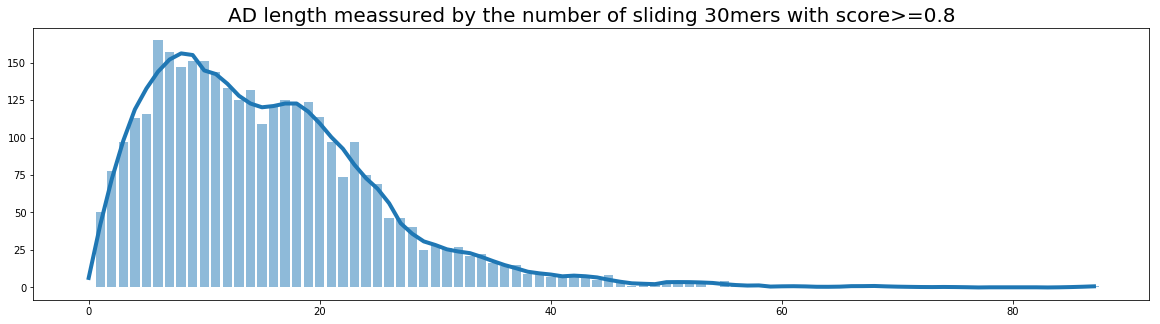

In [5]:
# Many ADs were recognized in a single protein. Here I toolk the longest.  

from scipy.signal import savgol_filter

#X = np.hstack([i for i in yeast_ADs.values()]).astype(int)
X = [np.max(i) for i in yeast_ADs.values() if i!=[]]
Y = np.zeros(np.max(X)+1)
for i in X:
    Y[i]+=1
f,ax = plt.subplots(1,1, figsize=(20,5))
plt.plot(np.arange(len(Y)), savgol_filter(Y, 9, 2), lw=4)
plt.bar(np.arange(len(Y)),Y,alpha=0.5);
plt.title('AD length meassured by the number of sliding 30mers with score>=0.8', fontsize=20);

#print(list(zip(np.arange(len(Y)),Y.astype(int))))
#print({n:int(i) for n,i in enumerate(Y)})

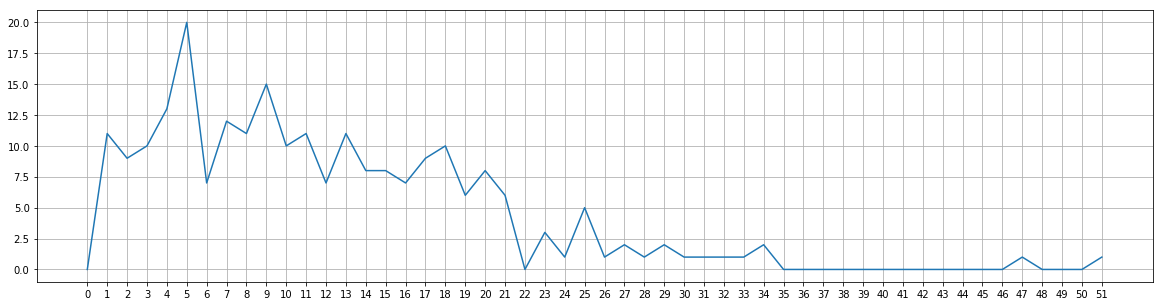

In [6]:
with open('data/TFs_small.csv','r') as f:
    tf = [i.split(',')[1] for i in f][1:]

TFs = {i:yeast_ADs[i] for i in set(tf).intersection(yeast_ADs.keys())}
X = np.hstack([i for i in TFs.values() if i!=[]]).astype(int)
Y = np.zeros(np.max(X)+1)
for i in X:
    Y[i] +=1
    
f,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(np.arange(len(Y)),Y)
ax.set_xticks(np.arange(len(Y)))
plt.grid();

### What if we sreen for ONLY regions with a defined structure in the pdb?

In [7]:
pdbs = {}

guessKey = {i.split(" ")[0]:i for i in proteome.keys()}

with open('review/structure.results.fasta','r') as f:
    while True:
        try:
            key, value = next(f).strip()[1:], next(f).strip()
            if key in yeast_ADs:
                pdbs[key] = np.array(value.split(',')).astype(int)
            
        except StopIteration:
            break
            
for k in yeast_ADs.keys():
    if k not in pdbs:
        vals = proteome[guessKey[k]]
        pdbs[k] = np.zeros(len(vals))

In [8]:
def find_AD_lenghts_considering_structure(locus):
    r=[]
    
    long = 0
    #for n,i in enumerate(proteome[guessKey[locus]]):  
    for n,i in enumerate(np.convolve( proteome[guessKey[locus]], np.ones(12)/12, "same")):
        try:
            if i<0.8:
                if long>=1: #5:
                    r.append(long)
                    long = 0
                else:
                    continue

            elif pdbs[locus][n]==0:
                long +=1
        except Exception as e:
            print(str(e))
    return r


yeast_ADs_considering_structure = {}
for k,v in proteome.items():

    if v==[] or v=='': continue

    yeast_ADs_considering_structure[k.split(" ")[0]] = find_AD_lenghts_considering_structure(k.split(" ")[0]) 

2873.0


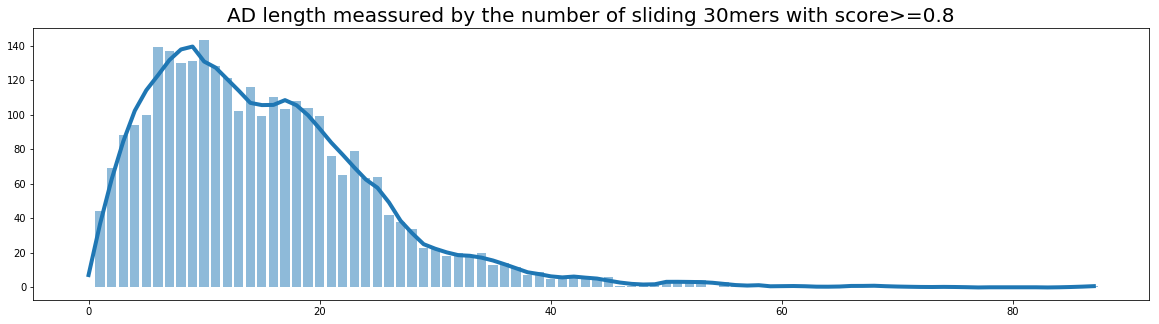

In [9]:
# Many ADs were recognized in a single protein. Here I toolk the longest.  

from scipy.signal import savgol_filter

#X = np.hstack([i for i in yeast_ADs.values()]).astype(int)
X = [np.max(i) for i in yeast_ADs_considering_structure.values() if i!=[]]
Y = np.zeros(np.max(X)+1)
for i in X:
    Y[i]+=1
f,ax = plt.subplots(1,1, figsize=(20,5))
plt.plot(np.arange(len(Y)), savgol_filter(Y, 9, 2), lw=4)
plt.bar(np.arange(len(Y)),Y,alpha=0.5);
plt.title('AD length meassured by the number of sliding 30mers with score>=0.8', fontsize=20);

#print(list(zip(np.arange(len(Y)),Y.astype(int))))
#print({n:int(i) for n,i in enumerate(Y)})
print(np.sum(Y))

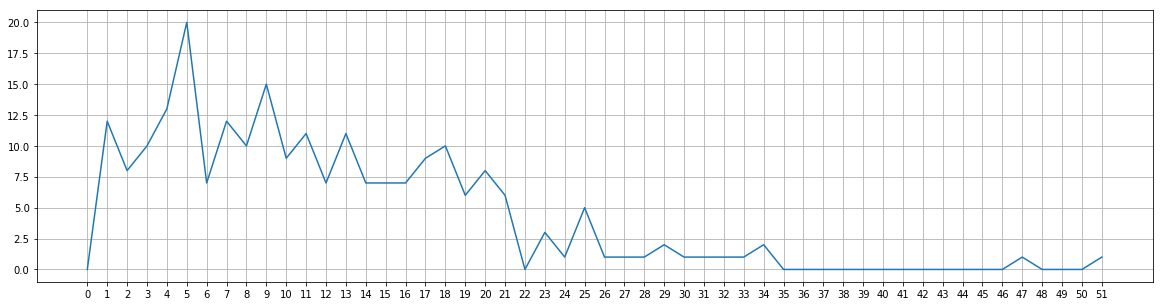

In [10]:
with open('data/TFs_small.csv','r') as f:
    tf = [i.split(',')[1] for i in f][1:]

TFs = {i:yeast_ADs_considering_structure[i] for i in set(tf).intersection(yeast_ADs_considering_structure.keys())}
X = np.hstack([i for i in TFs.values() if i!=[]]).astype(int)
Y = np.zeros(np.max(X)+1)
for i in X:
    Y[i] +=1
    
f,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(np.arange(len(Y)),Y)
ax.set_xticks(np.arange(len(Y)))
plt.grid();

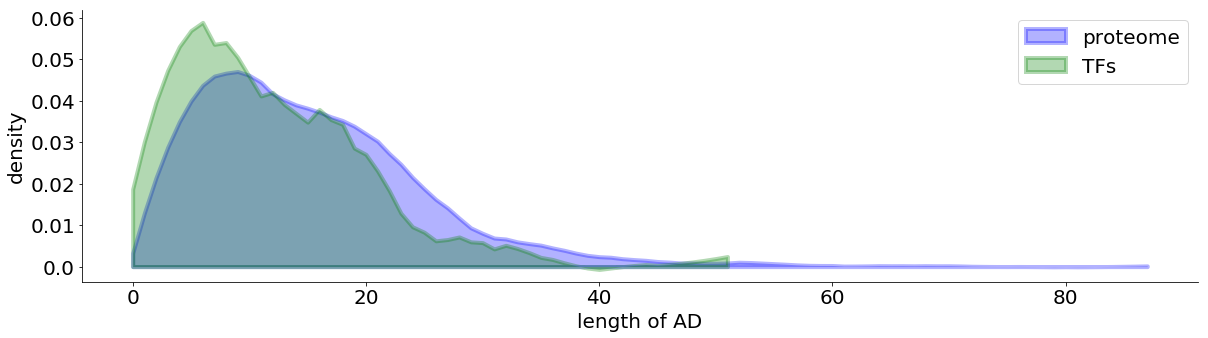

In [63]:
# Many ADs were recognized in a single protein. Here I toolk the longest.  
f,ax = plt.subplots(1,1, figsize=(20,5))
from scipy.signal import savgol_filter


X = [np.max(i) for i in yeast_ADs_considering_structure.values() if i!=[]]
Y = np.zeros(np.max(X)+1)
for i in X:
    Y[i]+=1
    
Y = savgol_filter(Y, 13, 2)
Y = Y / np.sum(Y) 
ax.fill_between(np.arange(len(Y)), Y, lw=4, color='b', alpha=0.3, label='proteome')
#ax.grid()
#ax.set_xticks(np.arange(len(Y)))

with open('data/TFs_small.csv','r') as f:
    tf = [i.split(',')[1] for i in f][1:]

TFs = {i:yeast_ADs_considering_structure[i] for i in set(tf).intersection(yeast_ADs_considering_structure.keys())}
X = np.hstack([i for i in TFs.values() if i!=[]]).astype(int)
Y = np.zeros(np.max(X)+1)
for i in X:
    Y[i] +=1
Y = savgol_filter(Y, 13, 2)
Y = Y / np.sum(Y) 
ax.fill_between(np.arange(len(Y)), Y, lw=4, color='g', alpha=0.3, label='TFs')

ax.set_xticklabels(plt.xticks()[0].astype(int), fontsize=20)
ax.set_yticklabels(np.round(plt.yticks()[0],3), fontsize=20)
ax.set_xlabel('length of AD', fontsize=20)
ax.set_ylabel('density', fontsize=20)
#plt.box(on=None);
sns.despine()
ax.legend(fontsize=20);

In [64]:
# I will consider here only ADs < 30 residues long
# So I take the middle point of the AD and include up to 15 residues on each side

def find_AD_positions_considering_structure(locus):
    r=[]
    
    long = 0
    #for n,i in enumerate(proteome[guessKey[locus]]):  
    for n,i in enumerate(np.convolve( proteome[guessKey[locus]], np.ones(12)/12, "same")):
        try:
            if i<0.8:
                if long>=1: #5:
                    r.append(n) #-long//2)
                    long = 0
                else:
                    continue

            elif pdbs[locus][n]==0:
                long +=1
        except Exception as e:
            print(str(e))
    return r


yeast_AD_positions_considering_structure = {}
for k,v in proteome.items():

    if v==[] or v=='': continue

    yeast_AD_positions_considering_structure[k.split(" ")[0]] = find_AD_positions_considering_structure(k.split(" ")[0]) 

#### Next cell is SLOW

In [116]:
sequences_to_test = []
for k,v in yeast_AD_positions_considering_structure.items():

    if v==[] or k not in tf: continue

    sequence = identifier2fasta(k)
    this_sequence = [k]
    for i in v:
        this_sequence.append(sequence[i-30:i+30])
        sequences_to_test.append(this_sequence)
        
with open('review/yeast_AD_positions_considering_structure_to_test_mutagenesis.csv', 'w') as f:
    f.write('\n'.join([','.join(i) for i in sequences_to_test]))

### Above I extracted regions from ADs found in real TFs in yeast. I computed saturated mutagenesis on these regions. Below are the results

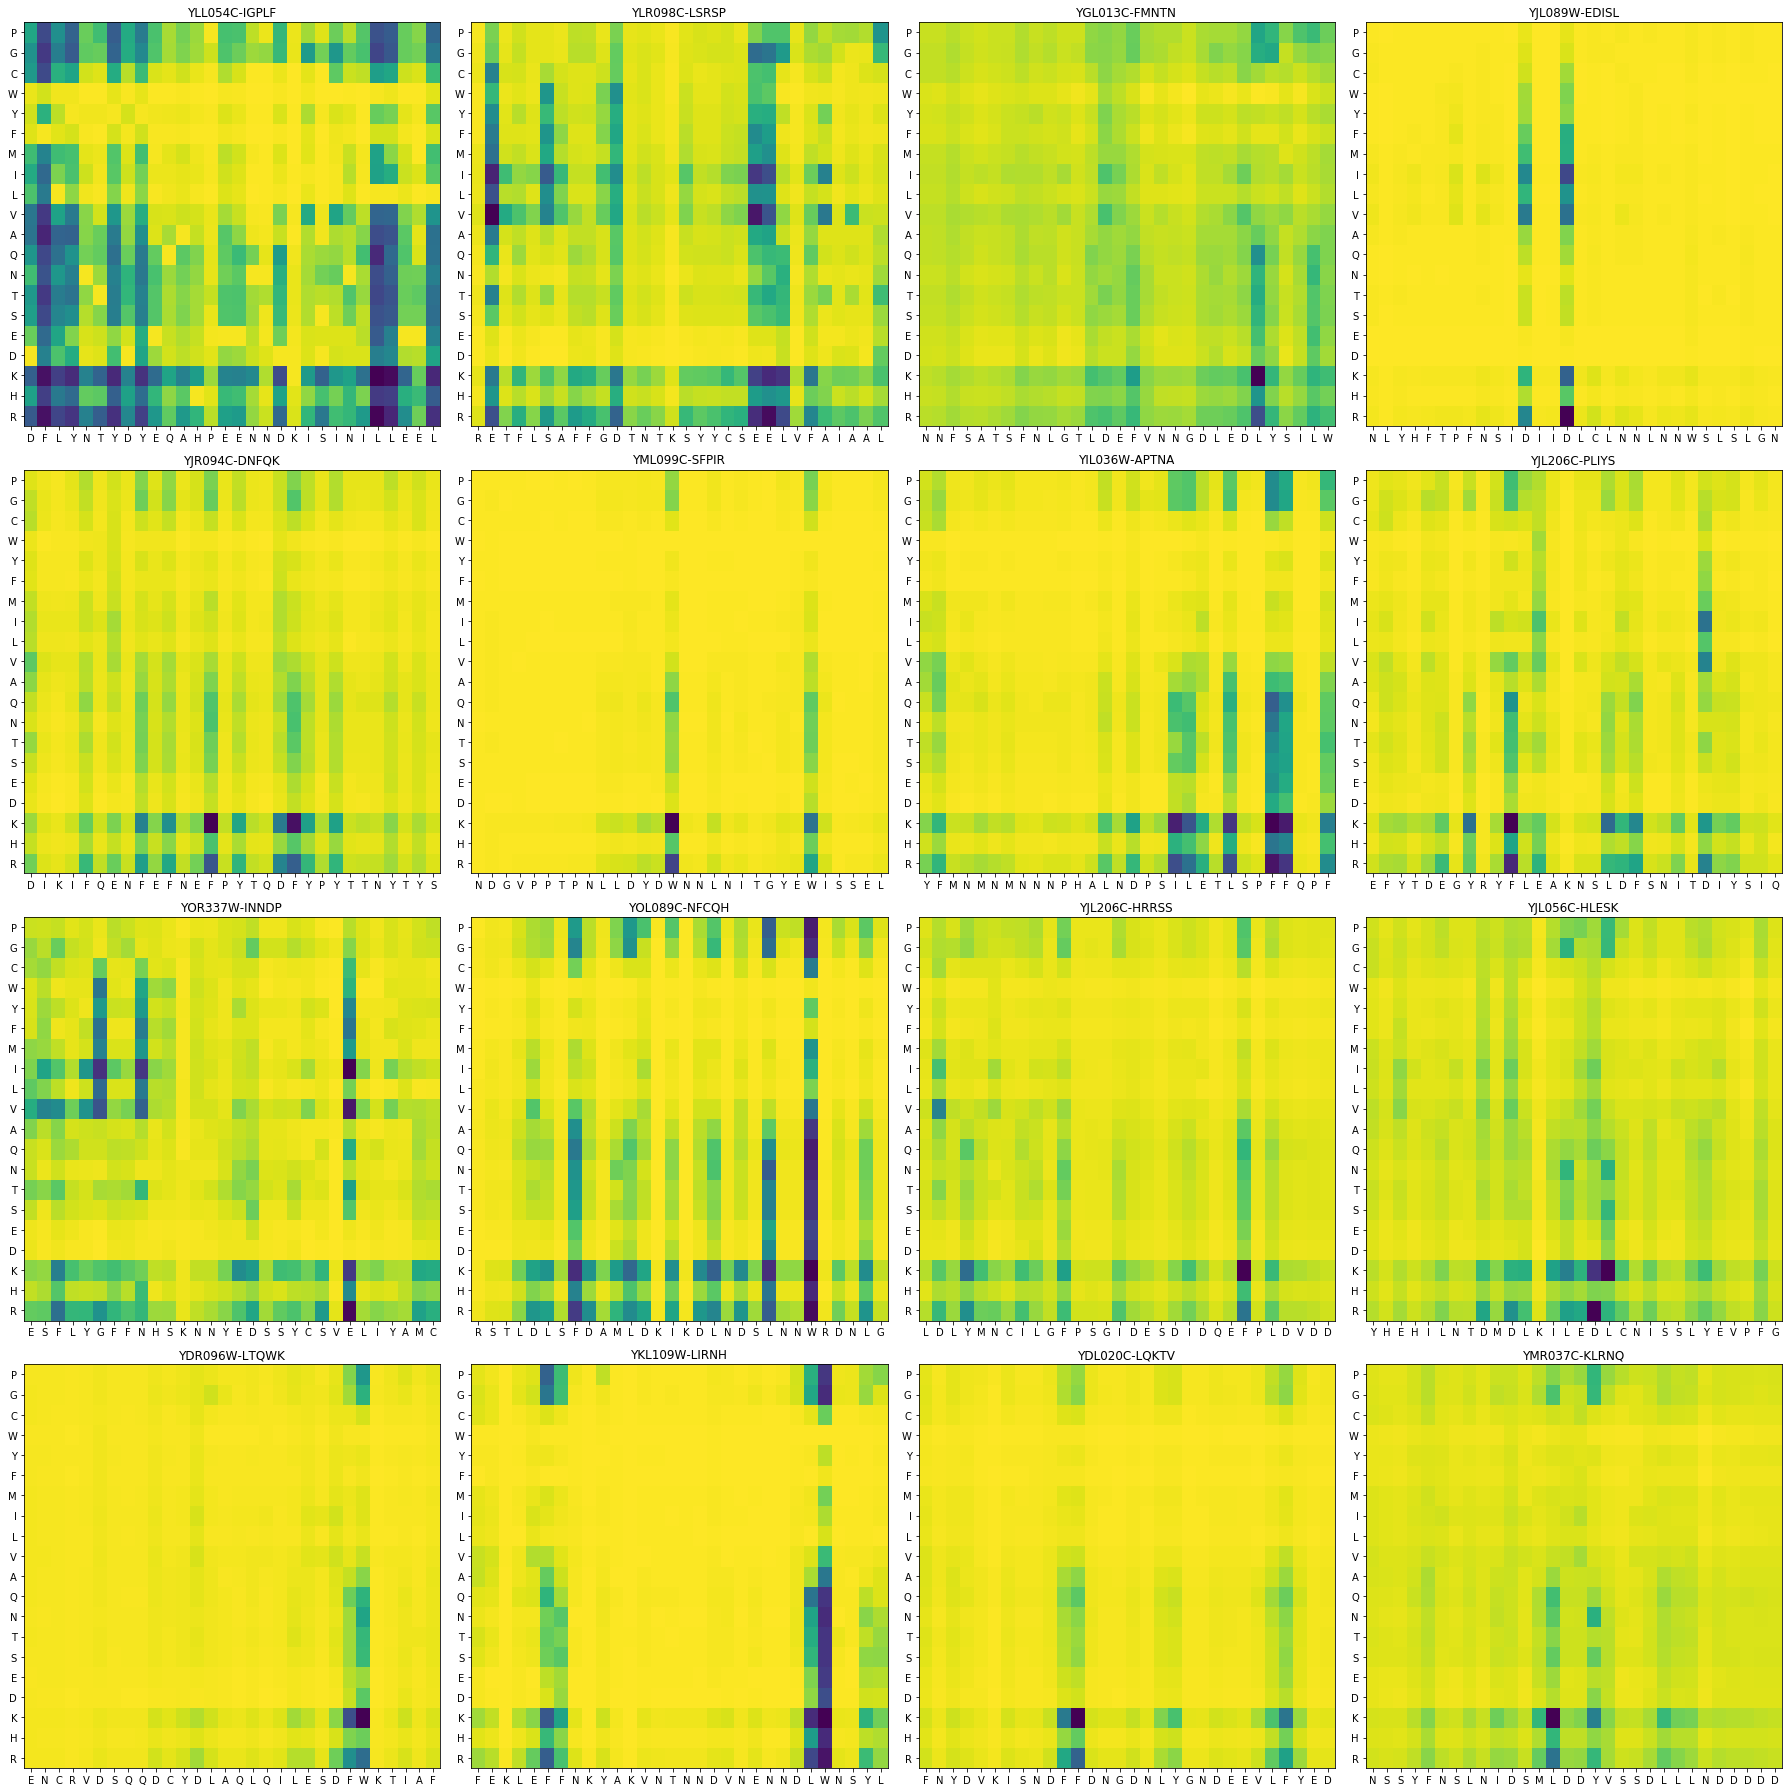

In [65]:
# Show 16 sample plots from the ~200 

Dir = 'review/mutanalysis_real_proteins_yeast/heatmaps/'
heat_files = [i for i in os.listdir(Dir) if re.search('results.pkl', i)]

heat_files = [heat_files[i] for i in np.random.randint(0,len(heat_files),16)]

for N in np.arange(0, len(heat_files),16): 

    f,ax = plt.subplots(4,4, figsize=(25,25))
    for n,i in enumerate(heat_files[N:N+16]):
        with open(Dir + i, 'rb') as f:
            a = pickle.load(f)

            ax1 = n//4
            ax2 = n%4        
            try:
                ax[ax1][ax2].pcolor(a['mutanalysis'])
                ax[ax1][ax2].set_xticks(np.arange(30)+0.5)
                ax[ax1][ax2].set_xticklabels(a['best30mer'])
                ax[ax1][ax2].set_yticks(np.arange(20)+0.5)
                ax[ax1][ax2].set_yticklabels(aa)
                ax[ax1][ax2].set_title(i.replace('.results.pkl',''));
            except Exception:
                continue
        plt.tight_layout()
        plt.savefig('heatmaps_of_ADS_in_TFs_from_yeast'+str(N//16)+'.png', dpi=300)

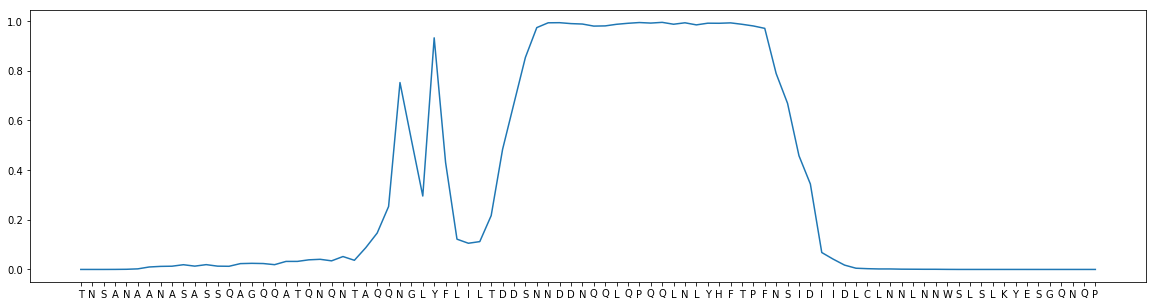

In [18]:
# 1)	Check if YJL089W-EDISL is one of the short ADs

seq = "TNSANAANASASSQAGQQATQNQNTAQQNG" + "LYFLILTDDSNNDDNQQLQPQQLNLYHFTPFNSIDIIDLCLNNLNNWSLSLKYESGQNQP" + "GNGNQNQTTSTSNASANANSGSQGTGSSSQ"
struct = psipred(seq)
ohe = prepare_ohe([seq, struct])

results = []
for i in np.arange(0, len(seq)-30, 1):
    results.append(ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0])

f,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(results)
ax.set_xticks(np.arange(len(seq)-30))
ax.set_xticklabels([i for i in seq[:-30]]);

### Visually looking at the examples above, take a few and best 30mer and start using combinations of stretches of 1,2,3,4...30 until we finid good adscore.

In [66]:
def find_position(full_seq, fragments):

    # sort fragments by their length
    inds = np.argsort([len(i) for i in fragments])[::-1]
    fragments = [fragments[i] for i in inds]
    
    starts = [
        re.search(i, full_seq).start()-1 for i in fragments
    ]    
    
#             ..............FFSSSTDSTPMFEYENLEDNSKEWTSLFD..............
#      x1            x2              x3                         x4         x5    
    
    left, right = [], []
    for start, frag in zip(starts, fragments):
        if start>=starts[0] and start<starts[0]+45:   # x3, x4
            l = start-starts[0]+15
        elif start>starts[0]+45:                    # x5 
                l = 45-len(frag)
        elif start<starts[0] and start>starts[0]-15:  # x2
            l = 15-(starts[0]-start)
        else:                                 # x1 
            l = 0
        
        left.append(l)
        right.append(60-l-len(frag))
        
    #left = [i-starts[0]+15 if i>=starts[0] else 0 for i in starts]
    #left = [i if i<=30-len(j) else 30-len(j) for i,j in zip(left, fragments)]
    #right= [30-i-len(j) for i,j in zip(left, fragments)]

    new_fragments = [
        ''.join([
            ''.join(["."]*i), j, ''.join(["."]*k) 
        ]) for i,j,k in zip(left, fragments, right)
    ]
    
    return new_fragments
    
def plot_lengths_profile(full_sequence, kmers, ax, positions=None):
    x, y = [], []
    
    for i in range(1, len(kmers)):
        tmp = [[k,v] for k,v in sorted(kmers[i].items(), key=lambda item: item[1])][-1]
        x.append(tmp[0])
        y.append(tmp[1])

    ax.barh(np.arange(len(x)),y, alpha=0.4)

    if positions == None: 
        for n,i in enumerate(y):
            ax.text(0.05, n-0.2, x[n], fontsize=12)
    else:
        seqs = find_position(full_sequence, x)[::-1]
        for n,i in enumerate(seqs):
            ax.text(0.05, n-0.2, i, fontsize=12, family='monospace')
    ax.set_yticks(np.arange(len(x)))
    ax.set_yticklabels(np.arange(len(x))+1)
    ax.set_xlabel('adpred score', fontsize=20)
    ax.set_ylabel('kmer', fontsize=20);
    
    #####print('\n'.join(find_position(gcn4, x)))
    
    return ax

YER184C-LGRII.results.pkl


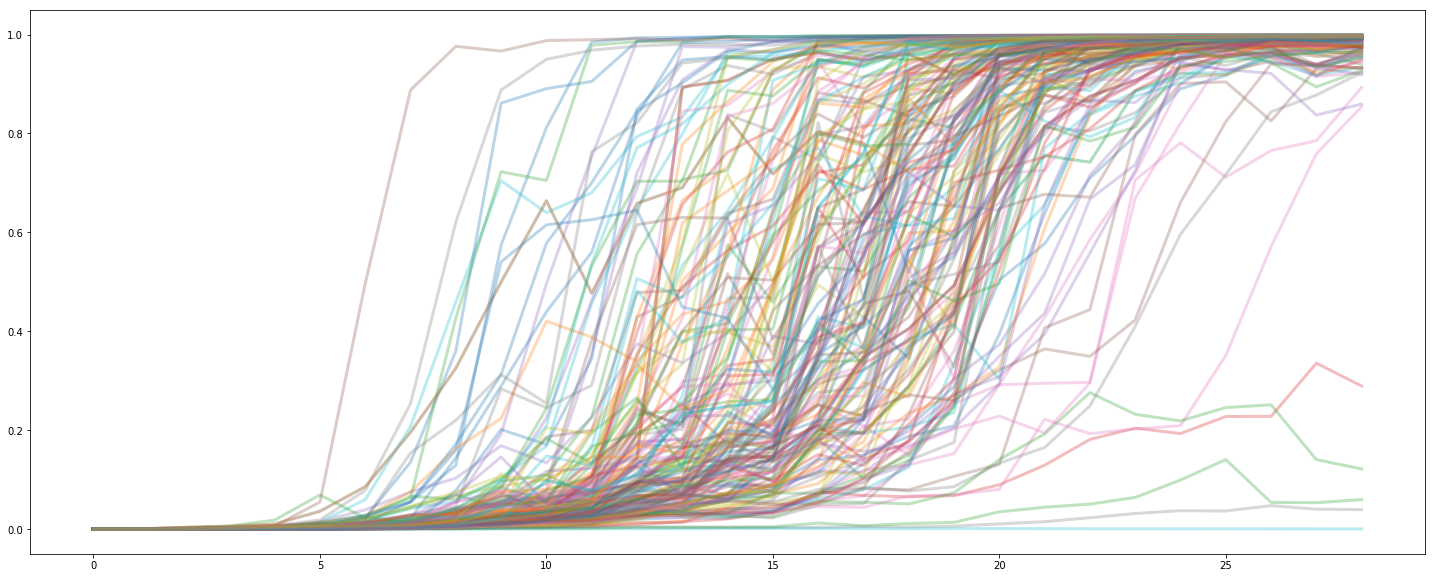

In [13]:
Dir = 'review/mutanalysis_real_proteins_yeast/lengths/'
lenght_files = [i for i in os.listdir(Dir) if re.search('results.pkl',i)]

plt.figure(figsize=(25,10))
for i in lenght_files:
    with open(Dir + i,'rb') as f:
        a=pickle.load(f)
        
        b = np.array(list(a[8].values()))
        if np.sum(b>0.8)>0: print(i)
        
    plt.plot([np.max(list(a[i].values())) for i in np.arange(1,30)], alpha=0.3, lw=3)

In [14]:
gcn4 = 'MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFDKFIKTEEDPIIKQDTPSNLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGER'

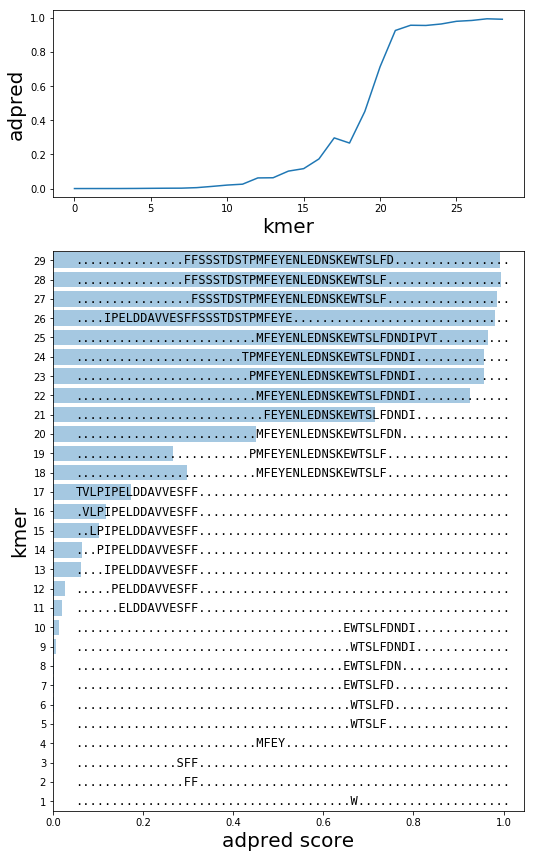

In [15]:
filename = 'review/mutanalysis_real_proteins_yeast/lengths/YEL009C-PDAKT.results.pkl'
with open(filename,'rb') as f:
        a=pickle.load(f)
        
f,ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(7.5,12))
ax[0].plot([np.max(list(a[i].values())) for i in np.arange(1,30)])
ax[0].set_xlabel('kmer', fontsize=20)
ax[0].set_ylabel('adpred', fontsize=20)

plot_lengths_profile(gcn4, a, ax[1], positions='lala')
ax[1].set_ylim(-0.5,28.5)
plt.tight_layout(pad=1)

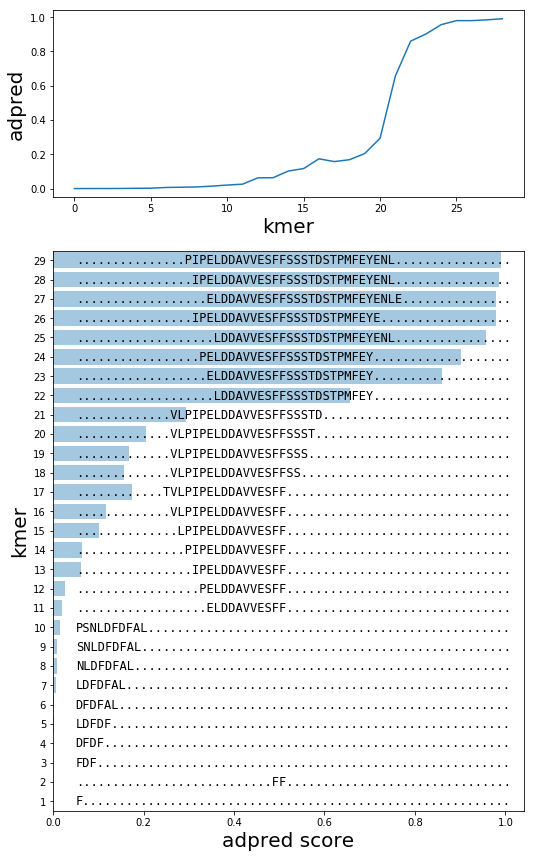

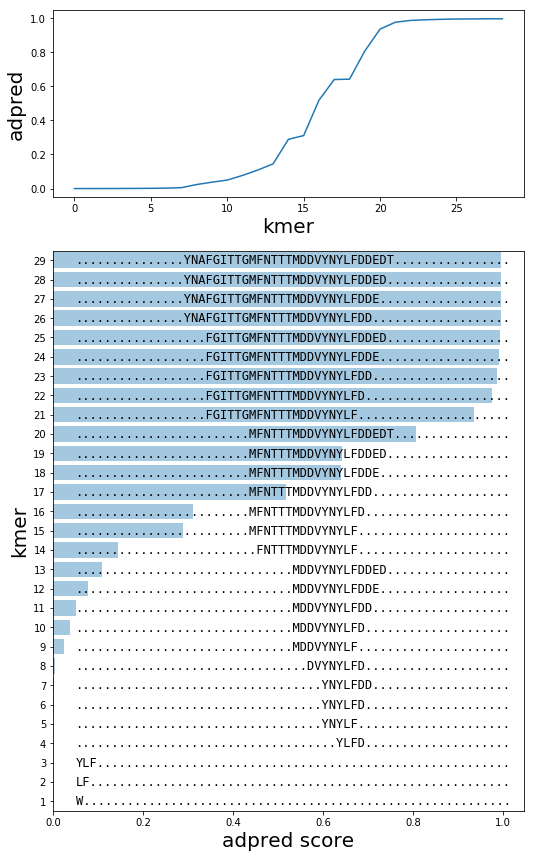

In [16]:
# testing known cases like gcn4 and gal4
# gcn4 = YEL009C  --> there are two regions. That used here is not the canonical gcn4 cAD
# gal4 = YPL248C

for file in ['YEL009C', 'YPL248C']:
    filename = [i for i in os.listdir('review/mutanalysis_real_proteins_yeast/lengths/') if re.search(file, i)][0]
    with open('review/mutanalysis_real_proteins_yeast/lengths/' + filename,'rb') as f:
        a=pickle.load(f)
    
    f,ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(7.5,12))
    ax[0].plot([np.max(list(a[i].values())) for i in np.arange(1,30)])
    ax[0].set_xlabel('kmer', fontsize=20)
    ax[0].set_ylabel('adpred', fontsize=20)

    full_sequence = identifier2fasta(file)
    plot_lengths_profile(full_sequence, a, ax[1], positions='lala')
    ax[1].set_ylim(-0.5,28.5)
    plt.tight_layout(pad=1)
    
    #plt.figure()
    #plt.plot([np.max(list(a[i].values())) for i in np.arange(1,30)])
    #plot_lengths_profile(a)

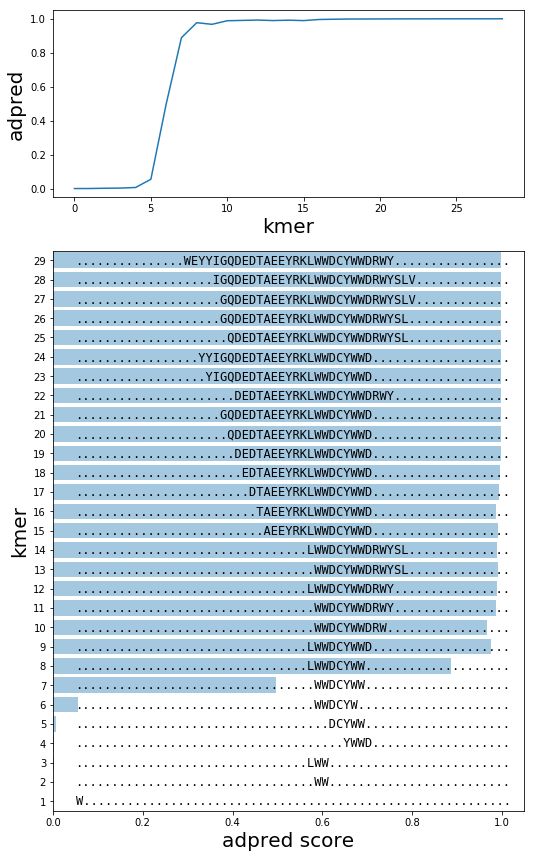

In [17]:
# look for the sequence that shows an AD 8mer

with open('review/mutanalysis_real_proteins_yeast/lengths/YER184C-LGRII.results.pkl','rb') as f:
    a=pickle.load(f)
    
    f,ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(7.5,12))
    ax[0].plot([np.max(list(a[i].values())) for i in np.arange(1,30)])
    ax[0].set_xlabel('kmer', fontsize=20)
    ax[0].set_ylabel('adpred', fontsize=20)

    full_sequence = identifier2fasta('YER184C')
    plot_lengths_profile(full_sequence, a, ax[1], positions='lala')
    ax[1].set_ylim(-0.5,28.5)
    plt.tight_layout(pad=1)
    
#plt.plot([np.max(list(a[i].values())) for i in np.arange(1,30)])
#plot_lengths_profile(a)

### Enrichment in yeast +/- structure from PDB and the 132 TFs from Titz et al

In [104]:
# first without structure
def find_AD_lenghts(result,length):
    r=[]
    
    long = 0
    for i in result:
        if i<0.8:
            if long>=length: #5:
                r.append(long)
                long = 0
            else:
                continue
        else:
            long +=1
    return r


def open_fasta(filename):
    adpreds = {}
    with open(filename,'r') as f:
        while True:
            try:
                name, adpred = next(f).strip(), next(f).strip()
                    
                # in case the header did not contain adpred results and the adpred line
                # is the next header
                if adpred == '': continue
                while adpred[0]==">":
                    name = adpred
                    adpred = next(f).strip()

                #name = re.search("[A-Z0-9]*\ ",name)
                name = name.split(' ')[0].replace(">","") #.replace("-A","").replace("-B","")
                
                if name == None: 
                    continue
                name = name #.group()

                assert name not in adpreds, "ups... {} repeatedd".format(name)

                adpreds[name] = np.array(adpred.split(',')).astype(float)
            except StopIteration:
                break
    return adpreds        


from scipy.stats import hypergeom
def enrichment(M,n,N, x):
    '''
        Calculates the enrichment of genes in a Pugh group
        
        M = total number of proteins (population size)
        n = group with score>cutoff longer than 5 residues (# of successes in population) 
        N = total of group taken into account (e.g. tf_full) (sample size)
        x = number of successes (withTAD) in that group (drawn successes)
    '''
    if N==0: N=N+0.5
    enriched = (x/N)/(n/M)
    p_val = hypergeom.sf(x-1, M, n, N)
    
    return enriched, p_val



adpreds = open_fasta('review/yeast_adpred.fasta')
f = open('review/Titz.complete.list','r')
TFs_ids = [i.strip() for i in f]

f = open('review/Titz.transcription.list','r')
tTFs_ids = [i.strip() for i in f]

thresholds = [5,10,15,20,25]  # [10,20,30,40,50]
TOTALs = {i:0 for i in thresholds}
TFs = {i:0 for i in thresholds}
tTFs = {i:0 for i in thresholds}

for threshold in thresholds:
    for k,v in adpreds.items():
        this_one = len(find_AD_lenghts(v, threshold)) > 0
        TOTALs[threshold] += this_one
        if k in TFs_ids:
            TFs[threshold] += this_one
        if k in tTFs_ids:
            tTFs[threshold] += this_one        

    print(enrichment(
        len(adpreds),
        TOTALs[threshold],
        len(TFs_ids),
        TFs[threshold]
    ))


(1.2888067421199951, 9.570548585171e-06)
(1.3284388832141643, 4.392487045977366e-05)
(1.3269051774287377, 0.00056013813488887)
(1.4181308364730605, 0.00015953510055276312)
(1.5230796335447498, 3.400804695328739e-05)


### New simple enrichment in humans

In [121]:
# first without structure
def find_AD_lenghts(result,length):
    r=[]
    
    long = 0
    for i in result:
        if i<0.8:
            if long>=length: #5:
                r.append(long)
                long = 0
            else:
                continue
        else:
            long +=1
    return r


def open_fasta(filename):
    adpreds = {}
    with open(filename,'r') as f:
        while True:
            try:
                name, adpred = next(f).strip(), next(f).strip()
                    
                # in case the header did not contain adpred results and the adpred line
                # is the next header
                if adpred == '': continue
                while adpred[0]==">":
                    name = adpred
                    adpred = next(f).strip()

                #name = re.search("[A-Z0-9]*\ ",name)
                name = name.split('|')[1].replace(">","") #.replace("-A","").replace("-B","")
                
                if name == None: 
                    continue
                name = name #.group()

                assert name not in adpreds, "ups... {} repeatedd".format(name)

                adpreds[name] = np.array(adpred.split(',')).astype(float)
            except StopIteration:
                break
    return adpreds        


from scipy.stats import hypergeom
def enrichment(M,n,N, x):
    '''
        Calculates the enrichment of genes in a Pugh group
        
        M = total number of proteins (population size)
        n = group with score>cutoff longer than 5 residues (# of successes in population) 
        N = total of group taken into account (e.g. tf_full) (sample size)
        x = number of successes (withTAD) in that group (drawn successes)
    '''
    if N==0: N=N+0.5
    enriched = (x/N)/(n/M)
    p_val = hypergeom.sf(x-1, M, n, N)
    
    return enriched, p_val



adpreds = open_fasta('review/enrichment_humans/uniprot_human_results.adpred.fasta')
f = open('review/enrichment_humans/hTFs_reviewed-ONLY.masked_isoforms.uniprot','r')
TFs_ids = [i.strip() for i in f]


thresholds = [5,10,15,20,25]  # [10,20,30,40,50]
TOTALs = {i:0 for i in thresholds}
TFs = {i:0 for i in thresholds}

for threshold in thresholds:
    for k,v in adpreds.items():
        this_one = len(find_AD_lenghts(v, threshold))  > 0  
        TOTALs[threshold] += this_one 
        if k in TFs_ids:
            TFs[threshold] += this_one

    print(enrichment(
        len(adpreds),
        TOTALs[threshold],
        len(TFs_ids),
        TFs[threshold]
    ))


(0.5152658665884068, 1.0)
(0.5062027978868094, 1.0)
(0.4914244955160473, 1.0)
(0.4854056489467243, 1.0)
(0.4439855720354803, 1.0)


### Enrichment of ADs in human TFs
* for all proteins in uniprot, calculate adpreds and structured regions from pdb (done on rhino).  
* TFs is the list from the publication in [Vaquerizas et al.](https://www.nature.com/articles/nrg2538).    
* Screen ADs in disordered regions and calculate enrichment of DAs in TFs compared to the proteome. 

In [122]:
h_structures = {}
with open('review/enrichment_humans/structures.human.fasta','r') as f:
    while True:
        try:
            name, struct = next(f).strip()[1:], next(f).strip().split(',')
            assert name not in h_structures, "ups... {} repeated".format(name)
            h_structures[name] = np.array(struct).astype(int)
        except StopIteration:
            break
            
h_adpreds = {}
with open('review/enrichment_humans/uniprot_human_results.adpred.fasta','r') as f:
    while True:
        try:
            name, adpred = next(f).strip(), next(f).strip()
            
            # in case the header did not contain adpred results and the adpred line
            # is the next header
            if adpred == '': continue
            while adpred[0]==">":
                name = adpred
                adpred = next(f).strip()
            
            name = re.search("\|.*\|",name)
            if name == None: 
                continue
            name = name.group().replace("|",'')
            adpred = adpred.split(',')
            
            assert name not in h_adpreds, "ups... {} repeatedd".format(name)
            
            h_adpreds[name] = np.array(adpred).astype(float)
        except StopIteration:
            break

#with open('review/enrichment_humans/hTFs.uniprot.masked_isoforms','r') as f:
#with open('review/enrichment_humans/hTFs_reviewed-ONLY.uniprot','r') as f:
with open('review/enrichment_humans/hTFs_reviewed-ONLY.masked_isoforms.uniprot','r') as f:
    h_TFs = {i.strip() for i in f}
    
# 0 = non nuclear; 1 = nuclear; 2 = possibly nuclear
nuclear = {}
with open('review/enrichment_humans/cellular_localizations.human','r') as f:
    for i in f:
        i = i.strip().split(",")
        nuclear[i[0]] = int(i[-1])
    
def find_AD_positions_considering_structure(locus, threshold=1):
    r=[]
    
    long = 0
    #for n,i in enumerate(proteome[guessKey[locus]]):  
    for n,i in enumerate(np.convolve( h_adpreds[locus], np.ones(12)/12, "same")):
        try:
            if i<0.8:
                if long>=threshold: #5:
                    r.append(n) #-long//2)
                    long = 0
                else:
                    continue

            elif h_structures[locus][n]==0:
                long +=1

        except Exception as e:
            print(str(e))
    return r  
    
all_proteins = (set(h_structures.keys()).union(h_TFs).union(set(nuclear.keys()))).intersection(set(h_adpreds.keys()))
tf_proteins = h_TFs.intersection(set(h_adpreds.keys()))
nuclear_proteins = {k for k,v in nuclear.items() if v>0}.intersection(set(h_adpreds.keys()))

len(all_proteins), len(tf_proteins), len(nuclear_proteins), len(nuclear_proteins.intersection(tf_proteins))

(11196, 1043, 1228, 439)

### The longer the sequence, the higher the chancess to find an AD. Hence, normalize number of ADs found by the total number of residues?

In [125]:
thresholds = np.arange(70) #[5,10,15,20,25]  # [10,20,30,40,50]
TOTALs = {i:0 for i in thresholds}

for threshold in thresholds:
    for k in nuclear_proteins:
        TOTALs[threshold] += len(find_AD_positions_considering_structure(k, threshold)) > 0
        #TOTALs[threshold] += len(find_AD_positions_considering_structure(k, threshold))
        
TFs = {i:0 for i in thresholds}        

for threshold in thresholds:
    for k in nuclear_proteins.intersection(tf_proteins):
        TFs[threshold] += len(find_AD_positions_considering_structure(k, threshold)) > 0
        #TFs[threshold] += len(find_AD_positions_considering_structure(k, threshold))  

In [128]:
from scipy.stats import hypergeom
def enrichment(M,n,N, x):
    '''
        Calculates the enrichment of genes in a Pugh group
        
        M = total number of proteins (population size)
        n = group with score>cutoff longer than 5 residues (# of successes in population) 
        N = total of group taken into account (e.g. tf_full) (sample size)
        x = number of successes (withTAD) in that group (drawn successes)
    '''
    if N==0: N=N+0.5
    enriched = (x/N)/(n/M)
    p_val = hypergeom.sf(x-1, M, n, N)
    
    return enriched, p_val

enrich, pval = [],[]
for i in thresholds:
    ep = enrichment(len(nuclear_proteins), TOTALs[i], len(nuclear_proteins.intersection(tf_proteins)), TFs[i])
    enrich.append(ep[0])
    pval.append(ep[1])
#    print(len(nuclear_proteins), TOTALs[i], len(nuclear_proteins.intersection(tf_proteins)), TFs[i])
#    print(enrichment(len(nuclear_proteins), TOTALs[i], len(nuclear_proteins.intersection(tf_proteins)), TFs[i]))

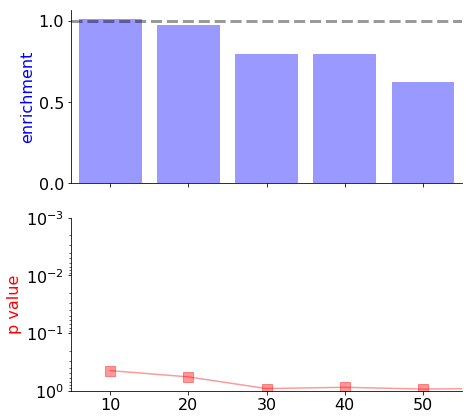

In [130]:
enrich2 = np.convolve(enrich, np.ones(4)/4, 'same')
pval2 = np.convolve(pval, np.ones(4)/4,'same')

    
ys = [np.mean(enrich2[i:i+10]) for i in np.arange(5, len(enrich2)-10, 10)]
ys2 = [np.mean(pval2[i:i+10]) for i in np.arange(5, len(pval2)-10, 10)]

####################
# plot enrichments #
####################

f,(ax1,ax2) = plt.subplots(2, sharex=True, figsize=(7,7))
ax1.bar(np.arange(len(ys)), ys, alpha=0.4, color='b')
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(np.arange(10,70,10))
ax2.scatter(np.arange(len(ys2)), ys2, alpha=0.4, color='r', s=100, marker='s')
ax1.set_ylabel('enrichment', color='b', fontsize=16)
ax1.plot(np.arange(6)-0.5, [1]*6, ls='--', alpha=0.4, color='k', lw=3)
ax2.plot(np.arange(len(ys2)), ys2, alpha=0.4, color='r')
ax2.set_ylabel('p value', color='r', fontsize=16)
ax2.set_yscale('log')
ax1.set_xlim(-0.5,4.5)

#print(ax2.get_ylim())
ax2.set_ylim((0.001,1)[::-1])
matplotlib.rcParams.update({'font.size': 20})
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

### second chance is about using data from ensembl instead of uniprot

In [108]:
uniprot_to_ensembl_translator = {}
with open('review/enrichment_humans/2nd_chance/ensembl_to_uniprot.csv','r') as f:
    while True:
        try:
            line = next(f).strip().split(',')
            uniprot_to_ensembl_translator[line[1]] = line[0]
        except StopIteration:
            break

h_structures = {}
with open('review/enrichment_humans/2nd_chance/human.proteome.2nd_chance.uniprot.structures','r') as f:
    while True:
        try:
            name, struct = next(f).strip()[1:], next(f).strip().split(',')
            
            if re.search('reviewed', name): continue                
            assert name not in h_structures, "ups... {} repeated".format(name)
            
            try:
                h_structures[name] = np.array(struct).astype(int)
            except Exception as e:
                continue
                #print('{} not included in h_structures'.format(re.sub(",.*","",name)))
                
        except StopIteration:
            break
            
h_adpreds = {}
with open('review/enrichment_humans/2nd_chance/results.proteome.adpred.csv','r') as f:
    while True:
        try:
            adpred = next(f).strip().split(',')
            name = adpred[0]
            adpred = adpred[1:]

            assert name not in h_adpreds, "ups... {} repeatedd".format(name)
            
            try:
                h_adpreds[name] = np.array(adpred).astype(float)
            except Exception:
                continue # in genera the message is protein name could not be extracted from uniprot site 'NoneType' object has no attribute 'group'
                
        except StopIteration:
            break

hTF_adpreds = {}
with open('review/enrichment_humans/2nd_chance/TFs.filtered.results.csv','r') as f:
    while True:
        try:
            adpred = next(f).strip().split(',')
            name = adpred[0]
            adpred = adpred[1:]

            assert name not in h_adpreds, "ups... {} repeatedd".format(name)
            
            try:
                hTF_adpreds[name] = np.array(adpred).astype(float)
            except Exception:
                continue # in genera the message is protein name could not be extracted from uniprot site 'NoneType' object has no attribute 'group'
                
        except StopIteration:
            break

def find_AD_positions_considering_structure(uniprot_id, threshold=1):
    r=[]
    
    ensembl_id = uniprot_to_ensembl_translator[uniprot_id]    
    
    long = 0
    #for n,i in enumerate(proteome[guessKey[locus]]):  
    for n,i in enumerate(np.convolve( h_adpreds[ensembl_id], np.ones(12)/12, "same")):
        try:
            if i<0.8:
                if long>=threshold: #5:
                    r.append(n) #-long//2)
                    long = 0
                else:
                    continue
            else:
                try:  # if n is larger than structures or doesn't exists...
                    if h_structures[uniprot_id][n]==0:
                        long+=1
                except Exception:
                     long+=1

        except Exception as e:
            print(str(e),'****', str(i))
    return r  
    
#len(h_TFs.intersection(h_adpreds.keys()).intersection(h_structures.keys()))

In [109]:
# 0 = non nuclear; 1 = nuclear; 2 = possibly nuclear
nuclear = {}
with open('review/enrichment_humans/cellular_localizations.human','r') as f:
    for i in f:
        i = i.strip().split(",")
        nuclear[i[0]] = int(i[-1])

nuclear_ensembl = {uniprot_to_ensembl_translator[re.sub("-.*", "", k)]:v for \
                   k,v in nuclear.items() if k in uniprot_to_ensembl_translator}

In [110]:
# available datasets: 
# -------------------
# h_structures -> dict[uniprot]
# h_adpreds -> dict[ensembl]
# h_TFadpreds -> dict[ensembl]
# uniprot_to_ensembl_translator -> dict
# find_AD_positions_considdering_structure -> function

# for the sake of keeping things consistent, I will join hTFadpreds with h_adpreds and will have a set of ids for TFs
h_adpreds = {**hTF_adpreds, **h_adpreds}

TFs = set([k for k,v in uniprot_to_ensembl_translator.items() if v in hTF_adpreds])
TOTs= set([k for k,v in uniprot_to_ensembl_translator.items() if v in h_adpreds])

thresholds = [5,10,20,30,40,50]
TOTALs = {i:0 for i in thresholds}

nuclear_proteins = {k for k,v in nuclear.items() if v==1}.intersection(TOTs) #{k for k,v in nuclear_ensembl.items() if v==1}
tf_proteins = TFs.intersection(nuclear_proteins)
all_proteins = TOTs

for threshold in thresholds:
    for k in all_proteins:
        TOTALs[threshold] += len(find_AD_positions_considering_structure(k, threshold)) > 0
        #TOTALs[threshold] += len(find_AD_positions_considering_structure(k, threshold))
        
TF = {i:0 for i in thresholds}        

for threshold in thresholds:
    for k in tf_proteins:
        TF[threshold] += len(find_AD_positions_considering_structure(k, threshold)) > 0
        #TF[threshold] += len(find_AD_positions_considering_structure(k, threshold)) 

In [540]:
for i in thresholds:
    print(len(nuclear_proteins), TOTALs[i], len(tf_proteins), TF[i])
    print(enrichment(len(all_proteins), TOTALs[i], len(tf_proteins), TF[i]))

2002 34545 214 766
(0.7947077672653009, 1.0)
2002 27882 214 604
(0.7763845794833528, 1.0)
2002 16398 214 384
(0.8392748853780687, 0.999976731110337)
2002 9802 214 209
(0.7641796583339127, 0.9999954579475202)
2002 5905 214 103
(0.6251456418264209, 0.9999999775453006)
2002 3675 214 61
(0.5948896001957227, 0.9999982619224036)


In [119]:
# table to filter out unreviewed samples

table = {}
with open('review/enrichment_humans/2nd_chance/uniprot-yourlist_second_chance.tab','r') as f:
    while True:
        try:
            line = next(f).strip()#.split('\t')
            
            # avoid unreviewed
            if re.search("unreviewed", line): 
                continue
            
            
            # deal with different isoforms
            if re.search("->", line):
                matches = ([i.group() for i in re.finditer("ENSG[0-9]{,12}\ ->\ [A-Z,0-9,-]{,10}",line)])
                for i in matches: 
                    k = re.sub(" ->.*$","", i)
                    v = re.sub("^.*-> ","", i)
                    v = re.sub("-.*", "", v)
                    table[k] = v
            
            # if only one isoform
            else:
                line = line.split('\t')
                try:
                    k,v = line[0], line[1]
                    table[k] = v
                except Exception as e:
                    print(str(e), "***", line)
                    
        except StopIteration:
            break

### Same enrichment studies in fly

In [131]:
Dir = '/Users/aerijman/Desktop/AD_summary/publication/analysis/review/enrichment_fly/'

f_structures = {}
with open(Dir + 'fly.structures.results.uniprot','r') as f:
    while True:
        try:
            name, struct = next(f).strip()[1:], next(f).strip().split(',')
            #assert name not in h_structures, "ups... {} repeated".format(name)
            f_structures[name] = np.array(struct).astype(int)
        except StopIteration:
            break
            
f_adpreds = {}
with open(Dir + 'fly.adpred.results.uniprot','r') as f:
    while True:
        try:
            name, adpred = next(f).strip(), next(f).strip()
            
            # in case the header did not contain adpred results and the adpred line
            # is the next header
            if adpred == '': continue
            while adpred[0]==">":
                name = adpred
                adpred = next(f).strip()
                
                if len(adpred) == 0:
                    adpred = [">"]
            
            name = re.search("\|.*\|",name)
            if name == None: 
                continue
            name = name.group().replace("|",'')
            adpred = adpred.split(',')
            
            #assert name not in h_adpreds, "ups... {} repeatedd".format(name)
            
            f_adpreds[name] = np.array(adpred).astype(float)
        except StopIteration:
            break

with open(Dir + 'all','r') as f:
    f_proteome = {i.strip() for i in f}

with open(Dir + 'tfs','r') as f:
    f_TFs = {i.strip() for i in f}
    
fly2uniprot = {}
with open(Dir + 'all_dict.tsv','r') as f:
    while True:
        try:
            line=next(f).strip().split('\t')
            fly2uniprot[line[0]] = line[1]
            
        except StopIteration:
            break

            
# 0 = non nuclear; 1 = nuclear; 2 = possibly nuclear
nuclear = {}
with open('review/enrichment_fly/cellular_localizations.fly','r') as f:
    for i in f:
        i = i.strip().split(",")
        nuclear[i[0]] = int(i[-1])            
    
def find_AD_positions_considering_structure(uniprot_id, threshold=1):
    r=[]
    
    long = 0
    #for n,i in enumerate(proteome[guessKey[locus]]):  
    for n,i in enumerate(np.convolve( f_adpreds[uniprot_id], np.ones(12)/12, "same")):
        try:
            if i<0.8:
                if long>=threshold: #5:
                    r.append(n) #-long//2)
                    long = 0
                else:
                    continue

            else:
                long+=1
                #try:  # if n is larger than structures or doesn't exists...
                #    if h_structures[uniprot_id][n]==0:
                #        long+=1
                #except Exception:
                #     long+=1
                

        except Exception as e:
            print(str(e))
    return r  
    
f_TFsfix = {fly2uniprot[i] for i in f_TFs if i in fly2uniprot}
len(f_TFsfix.intersection(f_adpreds.keys()).intersection(f_structures.keys()))
f_proteomefix = {fly2uniprot[i] for i in f_proteome if i in fly2uniprot}


all_proteins = f_proteomefix.intersection(f_adpreds)
tf_proteins = f_TFsfix.intersection(f_adpreds)
nuclear_proteins = {k for k,v in nuclear.items() if v==1}.intersection(f_adpreds)

In [132]:
nuclear_proteins = {k for k,v in nuclear.items() if v>0}.intersection(f_adpreds)
len(all_proteins), len(nuclear_proteins), len(tf_proteins), len(nuclear_proteins.intersection(tf_proteins))

(13631, 4242, 632, 550)

In [133]:
thresholds = [5,10,20,30,40,50]
TOTALs = {i:0 for i in thresholds}

with open(Dir + 'filtered_flybase.ids','r') as f:
    Filter = [fly2uniprot[i.strip()] for i in f if i.strip() in fly2uniprot.keys()]

Filtered = [k for k in fly2uniprot.values() if k not in Filter]

for threshold in thresholds:
    for k in nuclear_proteins: #.intersection(set(f_adpreds.keys())).intersection(Filtered):
        TOTALs[threshold] += len(find_AD_positions_considering_structure(k, threshold)) > 0
        #TOTALs[threshold] += len(find_AD_positions_considering_structure(k, threshold))
        
TF = {i:0 for i in thresholds}        

for threshold in thresholds:
    for k in tf_proteins: #.intersection(set(f_adpreds.keys())).intersection(set(f_structures)).intersection(Filtered):
        TF[threshold] += len(find_AD_positions_considering_structure(k, threshold)) > 0
        #TF[threshold] += len(find_AD_positions_considering_structure(k, threshold)) 

In [134]:
#M = len(total_idx)
#n = len(tf_full_idx)
#N = len(nuclear_idx)
#x = len(nuclear_idx.intersection(tf_full_idx))
#e,p = enrichment(M,n,N,x)

print(TOTALs,"\n",TF, "\n", len(f_TFsfix.intersection(Filtered)), len(f_proteomefix.intersection(Filtered)), "\n")

for i in thresholds:
    print(enrichment(
                    len(nuclear_proteins), #.intersection(set(f_adpreds.keys())).intersection(Filtered)), 
                    TOTALs[i], 
                    len(tf_proteins), #.intersection(f_TFsfix).intersection(Filtered)), 
                    TF[i]
                    ))

{5: 1909, 10: 1463, 20: 863, 30: 504, 40: 294, 50: 189} 
 {5: 193, 10: 149, 20: 76, 30: 36, 40: 13, 50: 8} 
 168 6963 

(0.6785861110926922, 0.9999999999997432)
(0.6835897280600811, 0.9999999999462404)
(0.5910937706264576, 0.9999999989041316)
(0.47943037974683544, 0.99999999438454)
(0.29679023508137425, 0.9999999993003638)
(0.2841068917018284, 0.9999996379400664)


In [573]:
# point 3 here

# results list to serialize
pickledResults = []

# set a maximum length of the insert
lenght = 50

# set numbere of sequences to analyze
N = 10 #00

# store in cell number that correspond to length of sequence,
# a list of lengths of ADs foind
correlation_lengths = [[] for i in range(lenght)]

# define function to find long ADs in sequence and keep their lenght in a list
def find_AD_lenghts(result):
    r=[]
    
    long = 0
    for i in result:
        if i<0.8:
            if long>=1: #5:
                r.append(long)
                long = 0
            else:
                continue
        else:
            long +=1
    return r


# Initially, try with equal probability for all aminoacids = non-biased towards AD (figure 2B)
insert_lenghts = np.random.randint(1,lenght,N)

for lenght in insert_lenghts:
    
    # define sequence and structure 
    insert = ''.join([aa[i] for i in np.random.randint(0,20,lenght)])
    sequence = ''.join([Nterm, insert, Cterm])
    structure= psipred(sequence)
    
    # compute ADPred score
    result = []
    for i in range(0, len(sequence)-30):
        ohe_data = prepare_ohe([sequence[i:i+30], structure[i:i+30]]).reshape(1,30,23,1)
        result.append(ADPred.predict(ohe_data)[0][0])
    
    #result = np.convolve([i if i>0.8 else 0 for i in result], np.ones(12)/12, "same")
    #correlation_lengths[lenght].append(find_AD_lenghts(result))

    # save sequence and structure
    pickledResults.append(
        {
            'sequence': sequence,
            'structure': structure,
            'adpred': result,
            'correlaltion_lenghts': find_AD_lenghts(result)
        }
    ) 

In [574]:
hist=[]
for n,i in enumerate(correlation_lengths):
    try:
        a = np.hstack(i)
        if np.sum(a)>0:
            print(n,' '.join([str(j) for j in a]))
            for j in a:
                hist.append(j)
    except Exception as e:
        #print(n,e)
        continue

### Previous cells from this notebook have been computed in rhino

(array([1073.,  979., 1037., 1007.,  836., 1047., 1029., 1056.,  956.,
         980.]),
 array([ 61. ,  65.8,  70.6,  75.4,  80.2,  85. ,  89.8,  94.6,  99.4,
        104.2, 109. ]),
 <a list of 10 Patch objects>)

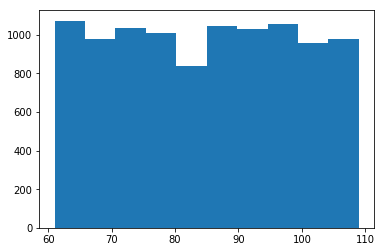

In [341]:
plt.hist([len(i['sequence']) for i in results])

In [165]:
# open resutls consissting of a list of dics with keys:
# sequence, structure, adpred and correlation_lenghts
with open('review/results.pkl', 'rb') as f:
    results = pickle.load(f)

### General info: 
1. lenghts of inserts?
2. How many ADs?
3. Correlation ADs with lenght of insert 

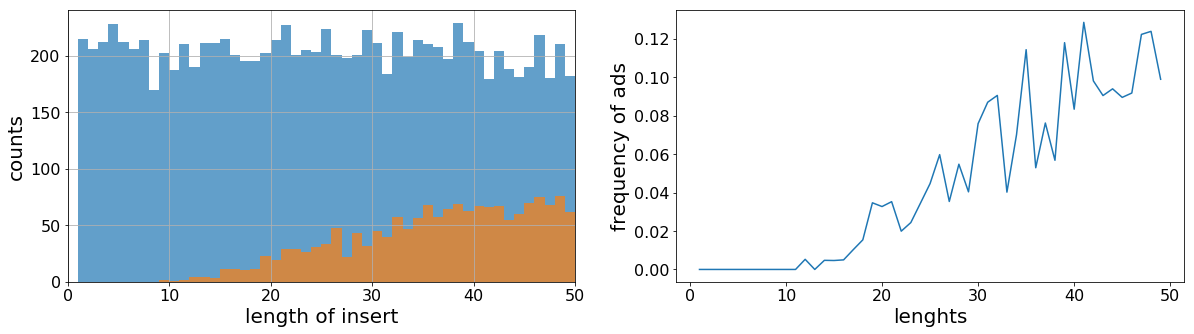

In [166]:
#1
f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))

X = np.array([len(i['sequence'])-60 for i in results])
ax1.hist(X, bins = np.arange(0,51), alpha=0.7)

X = np.array([len(i['sequence'])-60 for i in results if np.sum(i['adpred'])>0])
ax1.hist(X, bins = np.arange(0,51), alpha=0.7)
ax1.set_xlabel('length of insert', fontsize=20)
ax1.set_ylabel('counts', fontsize=20)
ax1.set_xlim(0,50)
ax1.grid()

totals = np.zeros(50)
contain_ad = np.zeros(50)

for i in results:
    l = len(i['sequence'])-60
    ad = 1 if i['correlation_lenghts'] != [] else 0
    
    totals[l] +=1
    contain_ad[l] += ad 

ax2.plot(contain_ad/totals)
ax2.set_xlabel('lenghts', fontsize=20)
ax2.set_ylabel('frequency of ads', fontsize=20);

As I expected, lenghts are picked from a random uniform distribution and the longer the fragment, the higher tha chance to find an AD.  

12


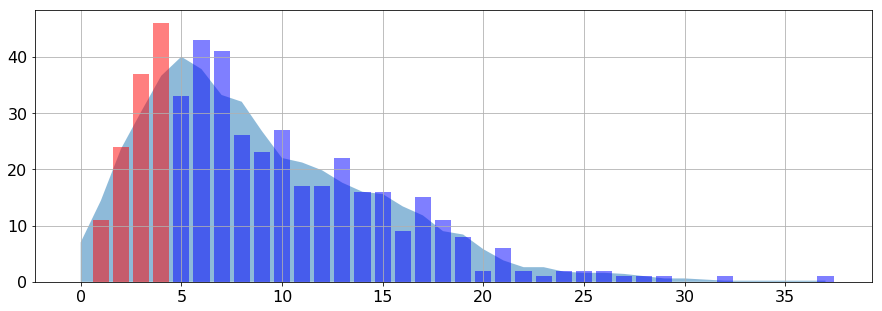

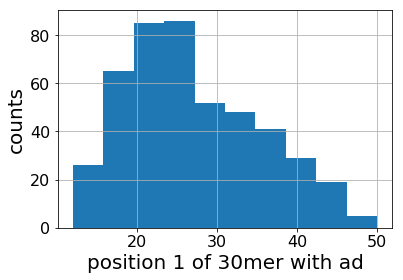

In [167]:
X = np.hstack( [i['correlation_lenghts'] for i in results] ).astype(int)

y = np.zeros( int(np.max(X))+1 )
for i in X:
    y[i] +=1
x = np.arange(np.max(X)+1)

cols = ['r']*5 + ['b']*33
plt.figure(figsize=(15,5))
plt.bar(x,y, alpha=0.5, color=cols)
plt.fill_between(x, np.convolve(y, np.ones(5)/5, "same"), alpha=0.5)
plt.grid()


plt.figure()
firsts = []
ids = []
for N,i in enumerate(results):
    if i['correlation_lenghts'] != []:
        for n,ad in enumerate(i['adpred']):
            if ad >0.8:
                firsts.append(n)
                ids.append(N)
                break
                
plt.hist(firsts)
plt.xlabel('position 1 of 30mer with ad', fontsize=20)
plt.ylabel('counts', fontsize=20)
MIN = np.min(firsts)
print(MIN)
plt.grid()

#IDS = np.array(ids)[np.where(np.array(firsts)==MIN)]
#for i in IDS:
#    print(results[i])

In [10]:
#2 
total_samples = len(results)

total_ads = np.sum(
    np.hstack( 
        [ len(i['correlation_lenghts']) for i in results if i['correlation_lenghts'] !=[] ] 
    )
)

total_seqs_ads = np.sum( 
    [ 1 for i in results if i['correlation_lenghts'] !=[] ] 
)

multiple_ads = np.max(
    np.hstack( 
        [ len(i['correlation_lenghts']) for i in results if i['correlation_lenghts'] !=[] ] 
    )
)

print(
    'from {} sequences with uniform-randomly distributed lenghts (1-50 residues), {} ADs were found in {} samples, with a max of {} ADs in a sequence'.format(
        total_samples, total_ads, total_seqs_ads, multiple_ads
    )
)

from 10000 sequences with uniform-randomly distributed lenghts (1-50 residues), 464 ADs were found in 456 samples, with a max of 2 ADs in a sequence


### In general, what are the preferred lengths of ADs (measured as #residues with score>0.8)? 

In [3]:
def find_AD_lenghts(result):
    r=[]
    
    long = 0
    for i in result:
        if i<0.8:
            if long>=1: #5:
                r.append(long)
                long = 0
            else:
                continue
        else:
            long +=1
    return r


with open('review/full_results.pkl', 'rb') as f:
    result = pickle.load(f)

lenght of results_0: 0 sequences with ADs
lenght of results_1: 0 sequences with ADs
lenght of results_2: 0 sequences with ADs
lenght of results_3: 0 sequences with ADs
lenght of results_4: 0 sequences with ADs
lenght of results_5: 0 sequences with ADs
lenght of results_6: 1 sequences with ADs
lenght of results_7: 6 sequences with ADs
lenght of results_8: 9 sequences with ADs
lenght of results_9: 34 sequences with ADs
lenght of results_10: 62 sequences with ADs
lenght of results_15: 368 sequences with ADs
lenght of results_20: 971 sequences with ADs
lenght of results_25: 1677 sequences with ADs
lenght of results_30: 2351 sequences with ADs
lenght of results_35: 2877 sequences with ADs
lenght of results_40: 3260 sequences with ADs


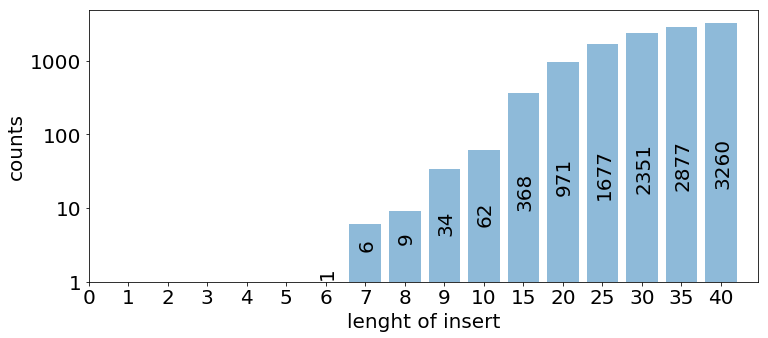

In [174]:
keys = list(result.keys())
ids = [int(i.replace('results_','')) for i in keys]
k_ids = np.argsort(ids)

plot = []

for n,k in enumerate([keys[i] for i in k_ids]):
    r = [find_AD_lenghts(i['adpred']) for i in result[k]]
    r = len([ i for i in r if i!=[] ])
    print('lenght of {}: {} sequences with ADs'.format(k, r))
    plot.append([int(k.replace('results_','')),r])

plot = np.array(plot)
f,ax = plt.subplots(1,1,figsize=(12,5))
ax.bar(np.arange(len(plot[:,1])), np.log10(plot[:,1]), alpha=0.5)

for n,i in enumerate(plot):
    if i[1]>0:
        ax.text(n-0.2,np.log10(i[1])*0.5, i[1], fontsize=20, rotation=90)

ax.set_xticks(np.arange(len(plot[:,1])))
ax.set_xticklabels(plot[:,0], fontsize=20)
ax.set_yticks(np.arange(0,4,1))
ax.set_yticklabels(10**np.arange(0,4,1), fontsize=20)
ax.set_ylabel('counts', fontsize=20)
ax.set_xlabel('lenght of insert', fontsize=20)

plt.savefig('lengths.eps', dpi=300, format='eps')

# list of sequences analysed with heatmap. Show insert indifferent color and important residues bold.

In [21]:
N=10
r = [find_AD_lenghts(i['adpred']) for i in result['results_'+str(N)]]
r = np.vstack([ (n,i[0]) for n,i in enumerate(r) if i!=[] ])
for i in r:
    print('{:<11}{:<11}{:.4f}{:>3}{:>3}'.format(
              result['results_'+str(N)][i[0]]['sequence'][31:31+N], 
              result['results_'+str(N)][i[0]]['structure'][31:31+N], 
              np.max(result['results_'+str(N)][i[0]]['adpred']),
              i[1],
              np.argmax(result['results_'+str(N)][i[0]]['adpred'])
            )
         )

LGELWWAWFA HHHHHHHHHH 0.9907  8 11
FLYNMWNFMA EHHHHHHHH- 0.9144  1 11
EFELEWWLFA EEEEEEEEEE 0.9896 15 13
WSKIYNFWWA HHHHHHHHH- 0.8258  1 10
LPFYEFWCEA --HHHHHHH- 0.8635  2 13
LWFHSWYWPA EEEEEEEE-- 0.9046  3 11
WDSLPWWATA -----HHHH- 0.9127  6 12
DFGHWLWACA ---HHHHHH- 0.9565  5 11
TFISFWDMFA EEEEEHHHH- 0.9406  3 10
AFAWGWLFLA HHHHHHHHH- 0.9505  4 10
DWWMMWNHIA HHHHHHHHHH 0.9839  9 11
LDDCYMWWKA HHHHHHHHH- 0.8608  1 13
WEWWITSMYA HHHHHHHHH- 0.9691  6 10
VWCMWFLYSA HHHHHHHHH- 0.9700  5 10
PAWIWCIWFA --EEEEEEE- 0.9219  2 11
MMDWFYEWTA HHHHHHHH-- 0.8422  2 10
FYDYLMLYYA HHHHHHHHH- 0.8852  1 10
LYGFWFKWIA HHHHHHHHH- 0.8313  1 10
FLWLYIVFYA EEEEEEEEEE 0.9374  2  9
IMYVWEFCYA EEHHHHHHH- 0.9014  2 10
WGDVWAWLAA HHHHHHHHHH 0.9897  9 11
AIFLWFDFWA EEEEEEEEE- 0.9533  5 10
FWYWYCWDHA EEEEEEE--- 0.9811  8  9
SCWLFTMDWA EEEEEEEE-- 0.9380  6 11
YLQMLYWLDA HHHHHHHH-- 0.8449  1 10
PWTWAMLLWA HHHHHHHHHH 0.9727  3 10
PWIWACWLFA -HHHHHHHHH 0.9943  7 10
FGDWTYWPFA -----EEE-- 0.9794  8 10
WFLMGAEWWA EEEE--EE-

In [22]:
# pick this + flanking residues and do mutagenesis --> [ Take the 30mer that ADpred finds as maximum ]

def mutate(sequence, position, to_aa):
    sequence = [i for i in sequence]
    sequence[position] = to_aa
    return ''.join(sequence)


def mut_analysis(sequence, adpred_wt):
    adpred_results = np.ones(shape=(len(sequence), len(aa))) * adpred_wt
    
    for n_pos, pos in enumerate(sequence):
        seq = [i for i in sequence]  # make a new copy to work with so all other positions are wild type
        
        for n_res, res in enumerate(aa):
            if res == pos:  # don't compute when it's wild type 
                continue  
            else:
                seq[n_pos] = res
                Seq = ''.join(seq)
                struct = psipred(Seq)
                ohe = prepare_ohe([Seq, struct]).reshape(1,30,23,1)
                adpred_results[n_pos, n_res] = ADPred.predict(ohe)

    return adpred_results


N = 10
S = r[0,0] # sequence in results with AD
sequence = result['results_'+str(N)][S]['sequence']
adpred = result['results_'+str(N)][S]['adpred']
for n,i in enumerate(adpred):
    if i>=0.8:
        print('{:.4f} {:>35}'.format(i, sequence[n:n+30]))

0.9815      QNGATQGGTQASQTGAQSSNHLGELWWAWF
0.9907      NGATQGGTQASQTGAQSSNHLGELWWAWFA
0.9785      GATQGGTQASQTGAQSSNHLGELWWAWFAG
0.9740      ATQGGTQASQTGAQSSNHLGELWWAWFAGS
0.9638      TQGGTQASQTGAQSSNHLGELWWAWFAGSQ
0.9474      QGGTQASQTGAQSSNHLGELWWAWFAGSQQ
0.8777      GGTQASQTGAQSSNHLGELWWAWFAGSQQQ
0.8001      GTQASQTGAQSSNHLGELWWAWFAGSQQQT


KeyboardInterrupt: 

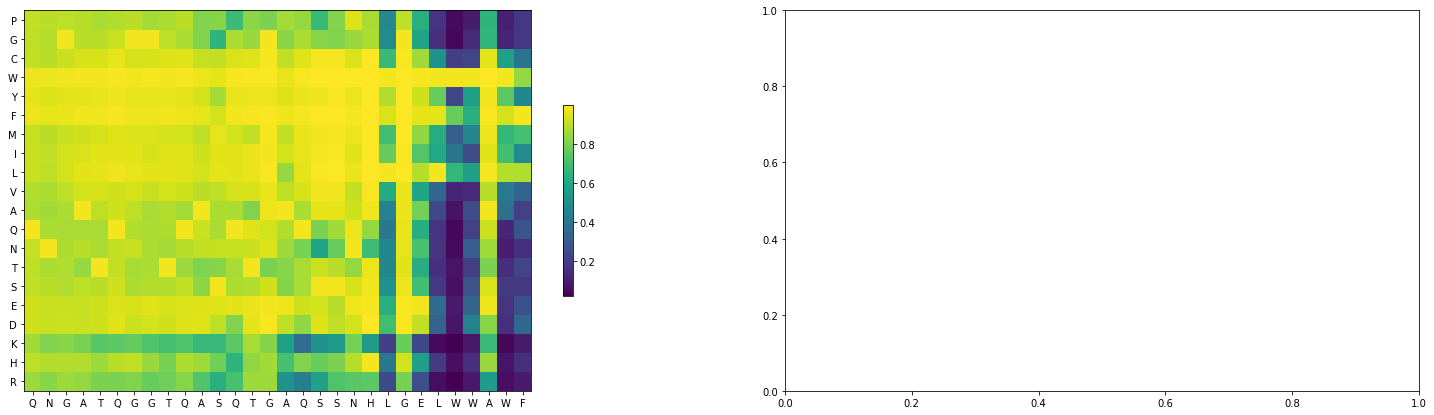

In [856]:
f, ax = plt.subplots(1,2,figsize=(25,7))

sequence= 'QNGATQGGTQASQTGAQSSNHLGELWWAWF'
a = mut_analysis(sequence, 0.9815)


im = ax[0].pcolor(a.T)
ax[0].set_xticks(np.arange(30)+0.5)
ax[0].set_yticks(np.arange(20)+0.5)
ax[0].set_xticklabels([i for i in sequence])
ax[0].set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax[0])

sequence= 'GTQASQTGAQSSNHLGELWWAWFAGSQQQT'
a = mut_analysis(sequence, 0.8001)

im = ax[1].pcolor(a.T)
ax[1].set_xticks(np.arange(30)+0.5)
ax[1].set_yticks(np.arange(20)+0.5)
ax[1].set_xticklabels([i for i in sequence])
ax[1].set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax[1])

In [161]:
N=169
r='results_10'
result[r][N]
for n,i in enumerate(result[r][N]['adpred']):
    print(result[r][N]['sequence'][n:n+30], i)

QANAATNNNAQNGATQGGTQASQTGAQSSN 3.7827947e-05
ANAATNNNAQNGATQGGTQASQTGAQSSNV 3.450759e-05
NAATNNNAQNGATQGGTQASQTGAQSSNVE 4.4467684e-05
AATNNNAQNGATQGGTQASQTGAQSSNVEF 0.00012355176
ATNNNAQNGATQGGTQASQTGAQSSNVEFE 0.00017258554
TNNNAQNGATQGGTQASQTGAQSSNVEFEL 0.00043662792
NNNAQNGATQGGTQASQTGAQSSNVEFELE 0.00080421276
NNAQNGATQGGTQASQTGAQSSNVEFELEW 0.0050379704
NAQNGATQGGTQASQTGAQSSNVEFELEWW 0.056061674
AQNGATQGGTQASQTGAQSSNVEFELEWWL 0.22411773
QNGATQGGTQASQTGAQSSNVEFELEWWLF 0.9500332
NGATQGGTQASQTGAQSSNVEFELEWWLFA 0.9816554
GATQGGTQASQTGAQSSNVEFELEWWLFAG 0.98757577
ATQGGTQASQTGAQSSNVEFELEWWLFAGS 0.9895739
TQGGTQASQTGAQSSNVEFELEWWLFAGSQ 0.9871251
QGGTQASQTGAQSSNVEFELEWWLFAGSQQ 0.9813116
GGTQASQTGAQSSNVEFELEWWLFAGSQQQ 0.9746971
GTQASQTGAQSSNVEFELEWWLFAGSQQQT 0.9558515
TQASQTGAQSSNVEFELEWWLFAGSQQQTQ 0.9365244
QASQTGAQSSNVEFELEWWLFAGSQQQTQG 0.9227364
ASQTGAQSSNVEFELEWWLFAGSQQQTQGN 0.90398264
SQTGAQSSNVEFELEWWLFAGSQQQTQGNA 0.90477383
QTGAQSSNVEFELEWWLFAGSQQQTQGNAS 0.8835086
TGAQSSNVEFELEWWLFAGSQ

In [110]:
goodones = []
for n,i in enumerate(results):
    if i['correlation_lenghts'] != []:
        goodones.append(n)
        

for i in goodones:
    if results[i]['correlation_lenghts']==[2]:
        N = np.where(results[i]['adpred']>0.8)[0][0]
        print(results[i]['sequence'])
        print(results[i]['sequence'][N+15:N+17])

NNAQQNGGATNAGSATQNSANSATNGNTAAALHTQSDCLVAFLYPEPNYYFWDRMANWLHPKHRQIKFPRMGHNQNAASNATGGTQGGQNGSTQTNQNSQQAA
LY
NNAQQNGGATNAGSATQNSANSATNGNTAAIEGQKFFPHEGYNGQLDEYVMVTRECFDHLMQIMPINLTNQNAASNATGGTQGGQNGSTQTNQNSQQAA
VT
NNAQQNGGATNAGSATQNSANSATNGNTAADLFEELSNHSFHYDWLSVRSNQNAASNATGGTQGGQNGSTQTNQNSQQAA
SN
NNAQQNGGATNAGSATQNSANSATNGNTAAQKIEMMQSKKWNDVFDWPTDMKLVSVDFVVWGNMLPYNLPKANPLNQNAASNATGGTQGGQNGSTQTNQNSQQAA
KL
NNAQQNGGATNAGSATQNSANSATNGNTAANDMTKDLGEELEELWPEYLGSQHMPGSNAMKQVNQNAASNATGGTQGGQNGSTQTNQNSQQAA
LE
NNAQQNGGATNAGSATQNSANSATNGNTAALFIFWYELMDAWVAAFSVEAKGDNSLGLRDNPNDNQNAASNATGGTQGGQNGSTQTNQNSQQAA
AL
NNAQQNGGATNAGSATQNSANSATNGNTAAMPFFVVPSQEQLVQEEYDSPQYMWLCYGVVANPPNPMPYYTNYPQVDGNQNAASNATGGTQGGQNGSTQTNQNSQQAA
EY
NNAQQNGGATNAGSATQNSANSATNGNTAAEWFVVQAKMVDKAATDFDPMSPYCQALLLCYCNEGMMGGCYINAQRCNQNAASNATGGTQGGQNGSTQTNQNSQQAA
LL
NNAQQNGGATNAGSATQNSANSATNGNTAAMSWWKYFPFHDWWPAMQFTTYIMMQLFNQNAASNATGGTQGGQNGSTQTNQNSQQAA
WK
NNAQQNGGATNAGSATQNSANSATNGNTAADRQCGQDYPIEMCIELRDWVQHWTWNQNAASNATGGTQGGQNGSTQTNQNSQQAA
IE

In [213]:
seq = Nterm + 'MRTHTQERPYKCPEDDCGKAFTASHHLKTHRRTHTGEKPYPCQEDSCQKSFSTSHSLKSH \
KKTHQRQLQNKGRKKRPLKTQQTKCSDQEQKDPQQEEQEEEEFIKEDQPEMTLLNPGSHC \
SETTSTDSGVVLQTLTPQDHLSNVFILQGNEPLILPETSQAYQLSYAAEEEIPSPWIDAG \
VLVSKPIIPMAPLTDACVALPTEMPSFVNLKPTFGNAVSGNMGDPQPETMDVDPTVETSL \
PTPTLELNQPNIEELLKQDSFENEEDMETESLLNDILMTIDNNSALLQATLQQASQVPSD \
ASGLVELDIRDNKPTLKQITADAGICNCTNCKCDQTKSCHGGDCGAAAAQQTTRTGAPTT \
TTTTTTMNSSGGKRICGSVVPTKKVSKRETEMNQNIEDVALLLQNLASMSSGGSSGGGGG \
CCGGGAVKPAPSGGGCCGEPKAPKPVNAGCGCARPSAPSSGGCCGSGVASTPKPTGGCCS \
GNQKPAPTATAASSPSCCCSGKGEVQEPPVISSASSAPAAAVKGNACTCKSPAEGVANGC \
CVVICIKTLQALRKVLTRRNLNLMLCPQQN'.replace(' ','') + Cterm

struct = psipred(seq)
ohe = prepare_ohe([seq, struct])  #.reshape(1,30,23,1)


predictions = []
for i in range(0,len(seq)-30):
    prediction = ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0]
    predictions.append(prediction)

# IMPORTANT
In the above plot, position 1 correspond to the the position 1 in sequence NOT IN INSERT!!  
Position 1 of insert is included when the 30mer starts at position 2.

# Reviewer2 #2

In [230]:
# frequenciess of positives and negatives that make the whole dataset
all_sequences = np.hstack([positives[:,0],negatives[:,0]])
freqs = np.mean(np.hstack(get_aa_frequencies(all_sequences)).T, axis=0)


# frequencies of yeast proteome
proteome = []
tmp=[]
with open('data/orf_trans_all.fasta', 'r') as f:
    while True:
        try:
            line = next(f)
            if line[0]==">":
                if 'tmp' in locals():
                    proteome.append(''.join(tmp).replace('*',''))
                tmp = []
            else:
                tmp.append(line.strip())
        except StopIteration:
            break
            
proteome_freq = np.mean(np.hstack( get_aa_frequencies(proteome[1:])).T, axis=0)

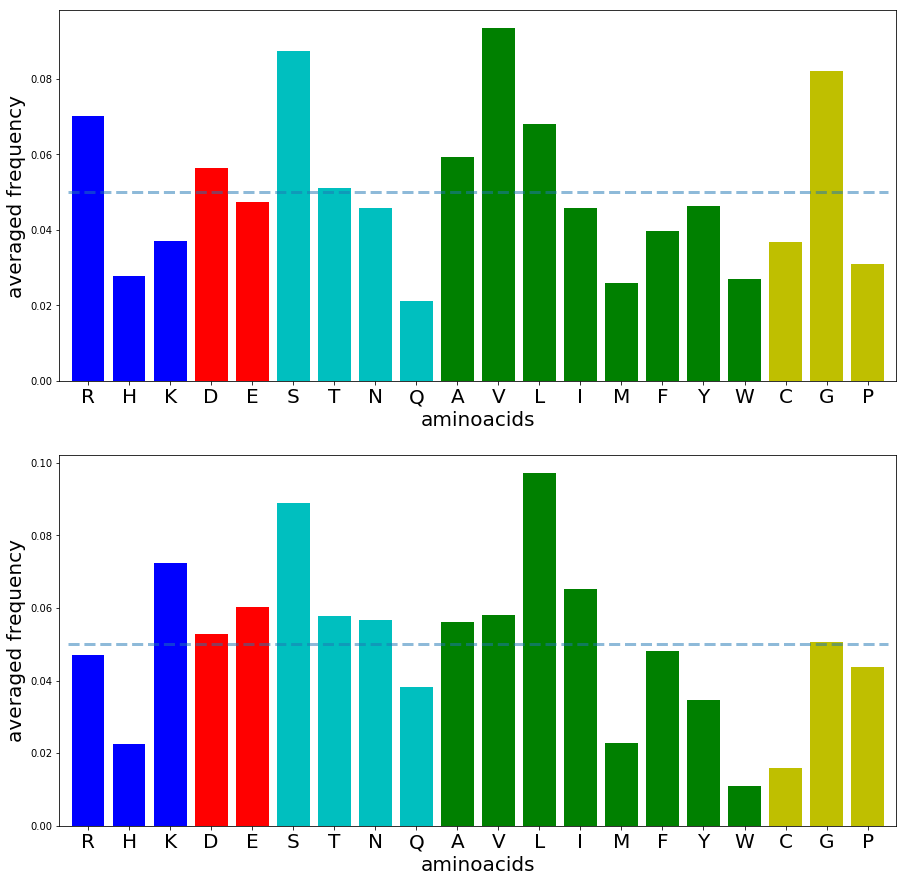

In [295]:
f, (ax1,ax2) = plt.subplots(2,1, figsize=(15,15))

cols = ['b']*3 + ['r']*2 + ['c']*4 + ['g']*8 + ['y']*3
ax1.bar(aa, freqs, color=cols)

ax2.bar(aa, proteome_freq, color=cols)

for i in [ax1,ax2]:
    #i.set_xticks(aa)
    i.set_xticklabels(aa, fontsize=20)
    i.set_xlabel('aminoacids', fontsize=20)
    i.set_ylabel('averaged frequency', fontsize=20)
    i.plot([-0.5,19.5],[0.05, 0.05], ls='--', alpha=0.5, lw=3)
    i.set_xlim(-0.7,19.7)

In [310]:
# dipeptides
freqs2 =  np.mean(np.vstack(get_dipeptide_frequencies(all_sequences)), axis=0)
proteome_freq2 = np.mean(np.vstack( get_dipeptide_frequencies(proteome[1:])), axis=0)

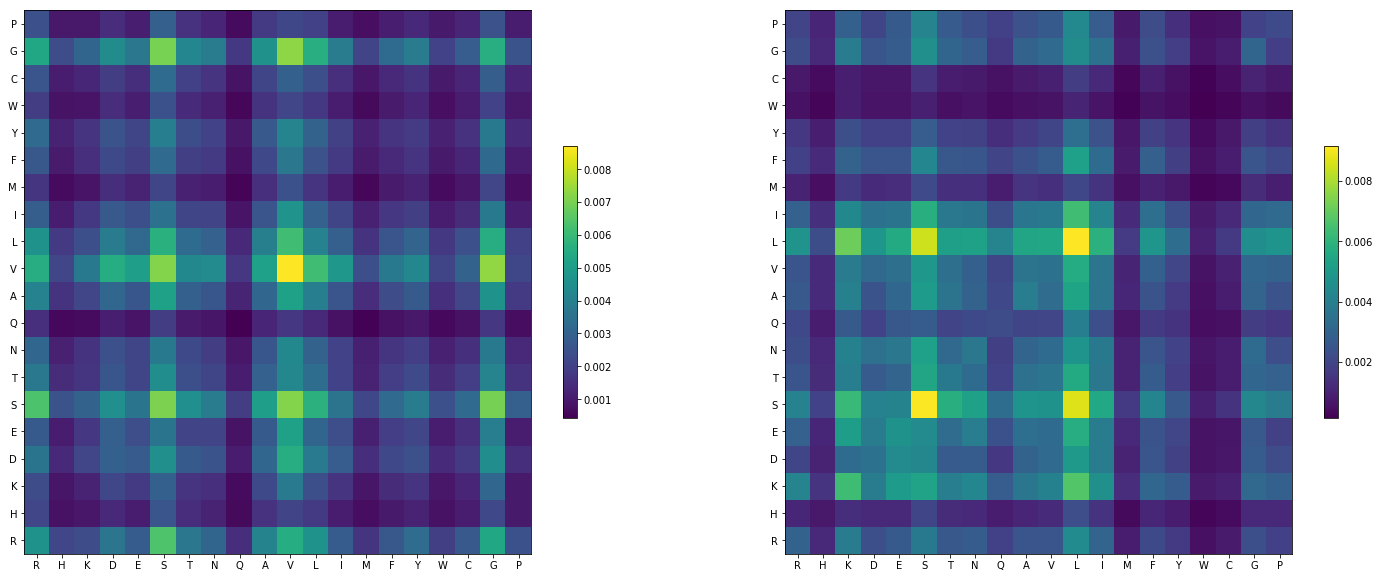

In [336]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(25,10))

im = ax1.pcolor(freqs2.reshape(20,20), cmap='viridis')
plt.colorbar(im, shrink=0.5, ax=ax1)
im = ax2.pcolor(proteome_freq2.reshape(20,20), cmap='viridis')
plt.colorbar(im, shrink=0.5, ax=ax2)

for i in ax1,ax2:
    i.set_xticks(np.arange(0,20)+0.5)
    i.set_yticks(np.arange(0,20)+0.5)
    
    i.set_xticklabels(aa)
    i.set_yticklabels(aa)

### Rivewer2 #3

In [353]:
with open('review/ARG_O1.df.pkl', 'rb') as f:
    arg3_1 = pickle.load(f)
    
with open('review/ARG_O2.df.pkl', 'rb') as f:
    arg3_2 = pickle.load(f)

In [354]:
arg3_1_freq = np.mean(np.hstack( get_aa_frequencies(list(arg3_1.index))).T, axis=0)
arg3_2_freq = np.mean(np.hstack( get_aa_frequencies(list(arg3_2.index))).T, axis=0)

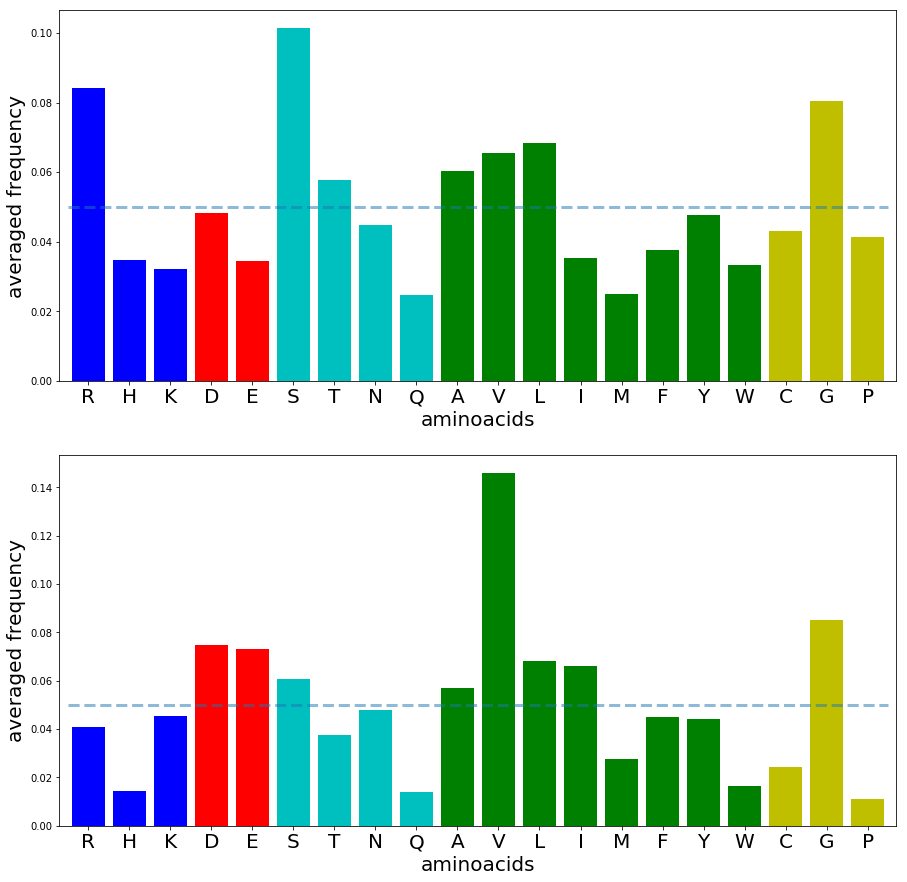

In [357]:
f, (ax1,ax2) = plt.subplots(2,1, figsize=(15,15))

cols = ['b']*3 + ['r']*2 + ['c']*4 + ['g']*8 + ['y']*3
ax1.bar(aa, arg3_1_freq, color=cols)
ax2.bar(aa, arg3_2_freq, color=cols)

for i in [ax1,ax2]:
    i.set_xticklabels(aa, fontsize=20)
    i.set_xlabel('aminoacids', fontsize=20)
    i.set_ylabel('averaged frequency', fontsize=20)
    i.plot([-0.5,19.5],[0.05, 0.05], ls='--', alpha=0.5, lw=3)
    i.set_xlim(-0.7,19.7)

In [10]:
files = os.listdir('review/mutanalysis/')

[23 25 28 29]
[22 24 27 28]
[21 23 26]
[20 22 25 26 27]


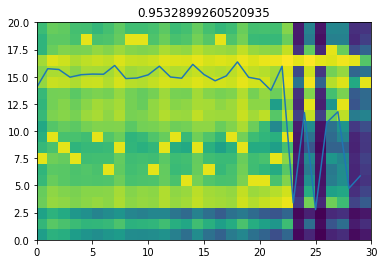

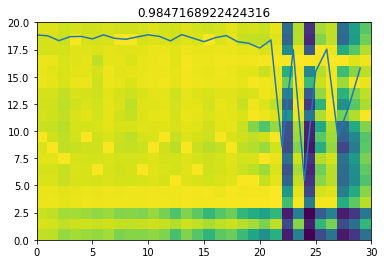

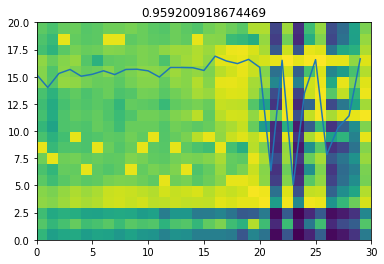

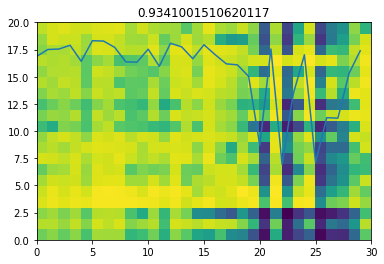

In [14]:
with open('review/mutanalysis/' + files[1], 'rb') as f:
    b = pickle.load(f)
    
for i in b.keys():
    m = b[i]
    plt.figure()
    plt.pcolor(m)
    n = np.sum(m,axis=0)
    plt.plot(n)
    plt.title(get_score(b[i]))
    print(np.where(n<=n[0]-5)[0])

ValueError: not enough values to unpack (expected 2, got 1)

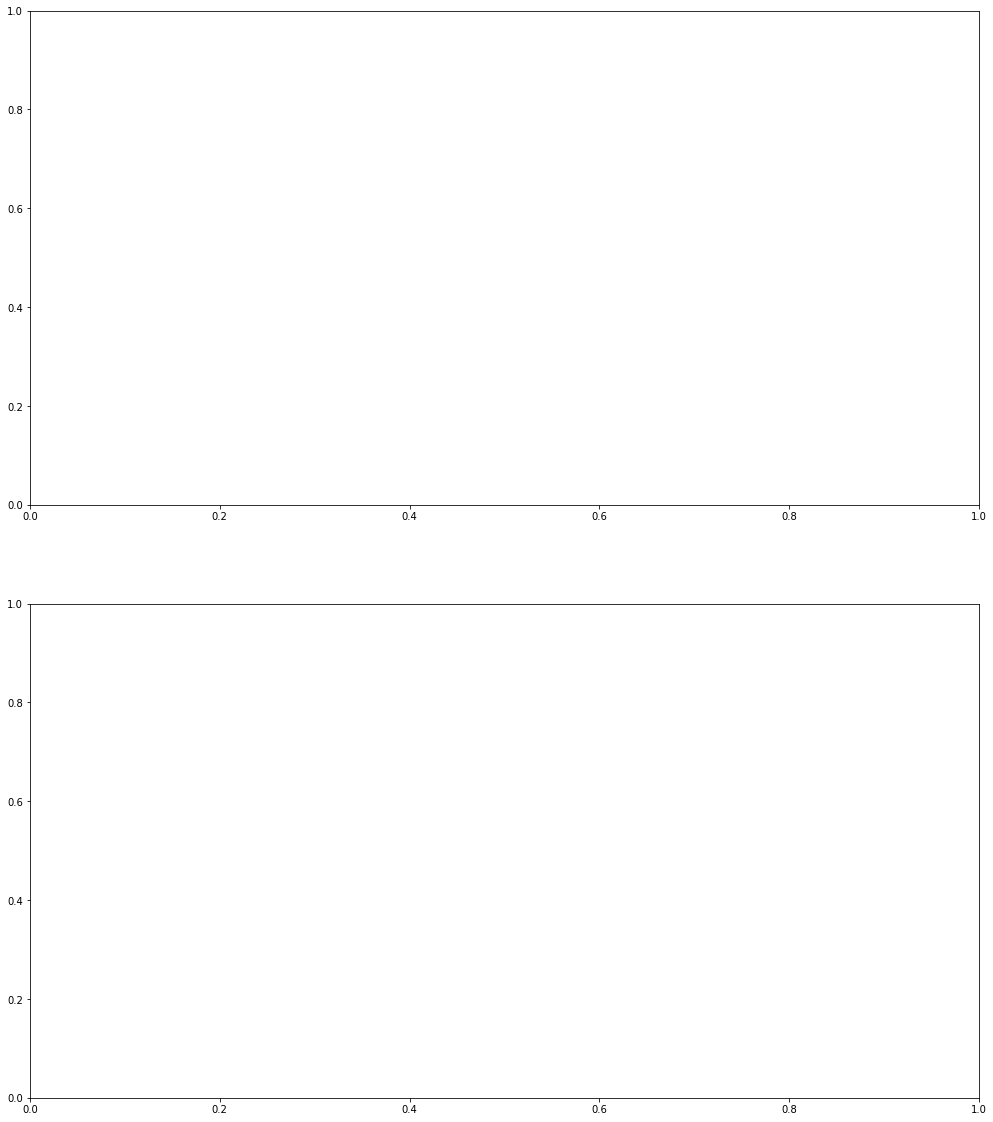

In [15]:
for file in files:
    
    with open('review/mutanalysis/' + file, 'rb') as f:
        b = pickle.load(f)
    
    N=len(b)
    if N>1:
        f, axs = plt.subplots(N, 1, figsize=(17, 10*N))
        for ax, (sequence, a) in zip(axs, b.items()):

            im = ax.pcolor(a)
            ax.set_xticks(np.arange(30)+0.5)
            ax.set_yticks(np.arange(20)+0.5)
            ax.set_xticklabels([i for i in sequence])
            ax.set_yticklabels(aa)
            plt.colorbar(im, shrink=0.5, ax=ax)
        plt.savefig(file[:-4] + '_' + str(N) + '.png')
        plt.close()
    else:
        print(N, file)
        f, ax = plt.subplots(1,1, figsize=(17, 10))
        im = ax.pcolor(a)
        ax.set_xticks(np.arange(30)+0.5)
        ax.set_yticks(np.arange(20)+0.5)
        ax.set_xticklabels([i for i in sequence])
        ax.set_yticklabels(aa)
        plt.colorbar(im, shrink=0.5, ax=ax)
        plt.savefig(file[:-4] + '_' + str(N) + '.png')
        plt.close()

In [13]:
def get_score(b_item):
    d = {}
    for i in np.sort(np.hstack(b_item)):
        if i in d:
            d[i] = d[i]+1
        else:
            d[i] = 1

    for k,v in d.items():
        if v>=30:
            score = float(k)
    if 'score' not in locals():
        print(d)

    return score

In [16]:
# highlight the residues from the insert to distinguish them from the flanking regions
Nt = 'QANAATNNNAQNGATQGGTQASQTGAQSSN'
Ct = 'AGSQQQTQGNASSANTSTGTGSTAQSQGSN'

class pcols:
    S = '\033[0m' #Stop
    B = '\33[1m'  #Bold
    H = '\x1b[0;30;42m' #Hilighted 
    HB= '\x1b[1;30;42m' #Hilighted 
    
print('\t'.join(['filename', 'insert_length', 'AD length(score>0.8)', 'sequence', '\t\tscore']))
print(''.join(['-']*90))

files = os.listdir('review/mutanalysis/')
figures = ['_'.join(i[:-4].split('_')[:2]) for i in os.listdir('figures/') if i[0:3]=='res' and len(i[:-4].split('_'))>2]
figures_splits_dict = {
    '_'.join(i[:-4].split('_')[:2]): i[:-4].split('_')[-1] for i in os.listdir('figures/') if i[0:3]=='res' and len(i[:-4].split('_'))>2
}

adlen_id, prnt = [],[]
for file in files:
    
    # only work with sequences that we have results of mutagenesis.
    if file[:-4] not in figures: continue
    
    # What is the random sequence?
    n_length, n_sample = file[8:-4].split('-') 
    insert = result['results_'+n_length][int(n_sample)]['sequence'][30:30+int(n_length)]
        
    # analyse the snapshots of that file 
    with open('review/mutanalysis/' + file, 'rb') as f:
        b = pickle.load(f)
        
        score=0
        seq=''
        
        for b_seq, b_val in b.items():
            new_score = get_score(b_val)
            if new_score>score:
                seq = str(b_seq)
                score = new_score
                
                # now find the AD = positions observed as AD in the heatmap
                m = np.sum(b_val, axis=0)
                #AD = np.where(m<= m[0]-5)[0]
                AD = np.where(m<np.mean(m)/1.25)[0]

        while re.search(insert, seq) == None: # somtimes 1 or 2 residues from the insert are missing here
            insert = insert[:-1]

        # where does the insert starts?
        start = re.search(insert, seq).start()-1
        
        formatted_seq = []
        # format each position accordingly
        for n,i in enumerate(seq):
            if n <= start and n not in AD:
                formatted_seq.append(pcols.S + i + pcols.S)
            elif n <= start and n in AD:
                formatted_seq.append(pcols.B + i + pcols.S)
            elif n >= start and n not in AD:
                if n > start+len(insert):
                    formatted_seq.append(pcols.S + i + pcols.S)
                else:
                    formatted_seq.append(pcols.H + i + pcols.S)
            elif n >= start and n in AD:
                if n > start+len(insert):
                    formatted_seq.append(pcols.B + i + pcols.S)
                else:
                    formatted_seq.append(pcols.HB + i + pcols.S)
        seq = ''.join(formatted_seq)
        #seq = seq[:start] + pcols.HB + seq[start:start+int(n_length)] + pcols.S + seq[start+int(n_length):]
        
        insert_length = file[:-4].split('_')[1].split('-')[0]
        #print('{:<20} {:<11} {:<10} {} {:>10.4f}'.format(file[:-4], insert_length, figures_splits_dict[file[:-4]], seq, score))
        prnt.append('{:<20} {:<11} {:<10} {} {:>10.4f}'.format(file[:-4], insert_length, figures_splits_dict[file[:-4]], seq, score))
        adlen_id.append(insert_length)
ids = np.argsort(np.array(adlen_id).astype(int))
for i in ids:
    print(prnt[i])

filename	insert_length	AD length(score>0.8)	sequence			score
------------------------------------------------------------------------------------------
results_7-2115       7           1          NAQNGATQGGTQASQTGAQSSNLLYWAWWA     0.8070
results_7-242        7           6          AQNGATQGGTQASQTGAQSSNLEWWLFFAG     0.9495
results_7-664        7           2          AQNGATQGGTQASQTGAQSSNYNFWWIWAG     0.9035
results_7-169        7           5          NAQNGATQGGTQASQTGAQSSNELWWAWFA     0.9617
results_7-1403       7           5          NNAQNGATQGGTQASQTGAQSSNWWWLILM     0.9918
results_7-4618       7           1          QNGATQGGTQASQTGAQSSNLWFDFWVAGS     0.8446
results_8-148        8           8          NAQNGATQGGTQASQTGAQSSNLWWAWFLY     0.9919
results_8-1969       8           4          QNGATQGGTQASQTGAQSSNFAWGWLFLAG     0.9524
results_8-1964       8           2          AQNGATQGGTQASQTGAQSSNFISFWDMFA     0.8318
results_8-4044       8           7          QNGATQGGTQASQTGAQSSNIFLWFDFWAG

QASQTGAQSSAWIWCIWFLAGSQQQTQGN 0.2045


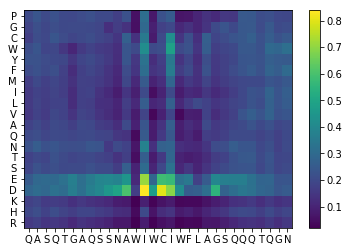

AQNGATQGGTQASQTGAQSSAWIWCIWFL 0.9256


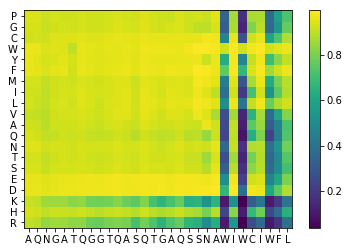

In [58]:
for seq in ['QASQTGAQSSNAWIWCIWFLAGSQQQTQGN', 'AQNGATQGGTQASQTGAQSSNAWIWCIWFL']:
    insert = 'AWIWCIWFL'

    assert len(seq)==30, 'ups... length of sequence < 30'

    struct = psipred(seq)
    ohe = prepare_ohe([seq, struct]).reshape(1,30,23,1)
    score = ADPred.predict(ohe)[0][0]

    a = mut_analysis(seq, score).T

    # now find the AD = positions observed as AD in the heatmap
    m = np.sum(a, axis=0)
    AD = np.where(m<= np.mean(m)/1.25)[0]


    start = re.search(insert, seq).start()-1
    assert start>0 or start>30, 'ups... start==0? or > 30?' # sanity check

    formatted_seq = []
    # format each position accordingly
    for n,i in enumerate(seq):
        if n < start and n not in AD:
            formatted_seq.append(pcols.S + i + pcols.S)
        elif n <= start and n in AD:
            formatted_seq.append(pcols.B + i + pcols.S)
        elif n > start and n not in AD:
            if n > start+len(insert):
                formatted_seq.append(pcols.S + i + pcols.S)
            else:
                formatted_seq.append(pcols.H + i + pcols.S)
        elif n >= start and n in AD:
            if n > start+len(insert):
                formatted_seq.append(pcols.B + i + pcols.S)
            else:
                formatted_seq.append(pcols.HB + i + pcols.S)
    sequence = ''.join(formatted_seq)
    print(sequence, np.round(score,4))
    
    f,ax = plt.subplots(1)
    im = plt.pcolor(a)
    #ax.plot(np.arange(len(m))+0.5, m)
    plt.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(30)+0.5)
    ax.set_xticklabels([i for i in seq])
    ax.set_yticks(np.arange(20)+0.5)
    ax.set_yticklabels(aa)
    plt.show(); plt.close()
    

NameError: name 'm6' is not defined

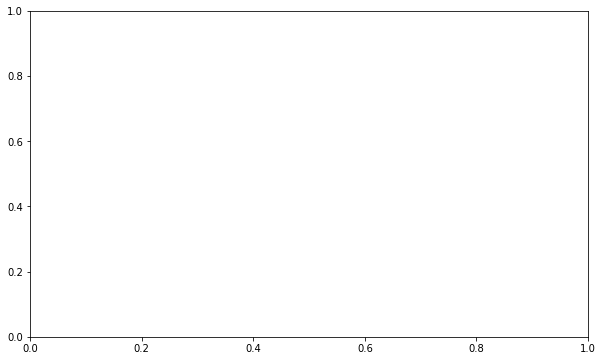

In [17]:
# Add here the 6mer that has a AD
seq6 = 'NNAQNGATQGGTQASQTGAQSSNWWWLILA'
struct6 = psipred(seq6)
ohe6 = prepare_ohe([seq6, struct6]).reshape(1,30,23,1)
#adpred6 = ADPred.predict(ohe6)[0][0]
#m6 = mut_analysis(seq6, adpred6)
f,ax = plt.subplots(1, figsize=(10,6))
ax.pcolor(m6.T)
ax.set_xticks(np.arange(30)+0.5)
ax.set_xticklabels([i for i in seq6]);
ax.plot(np.arange(30)+0.5, np.sum(m6.T, axis=0))

print(seq6[:23] + pcols.HB + seq6[23:29] + pcols.S + seq6[29])

## Experimental setup for Steve

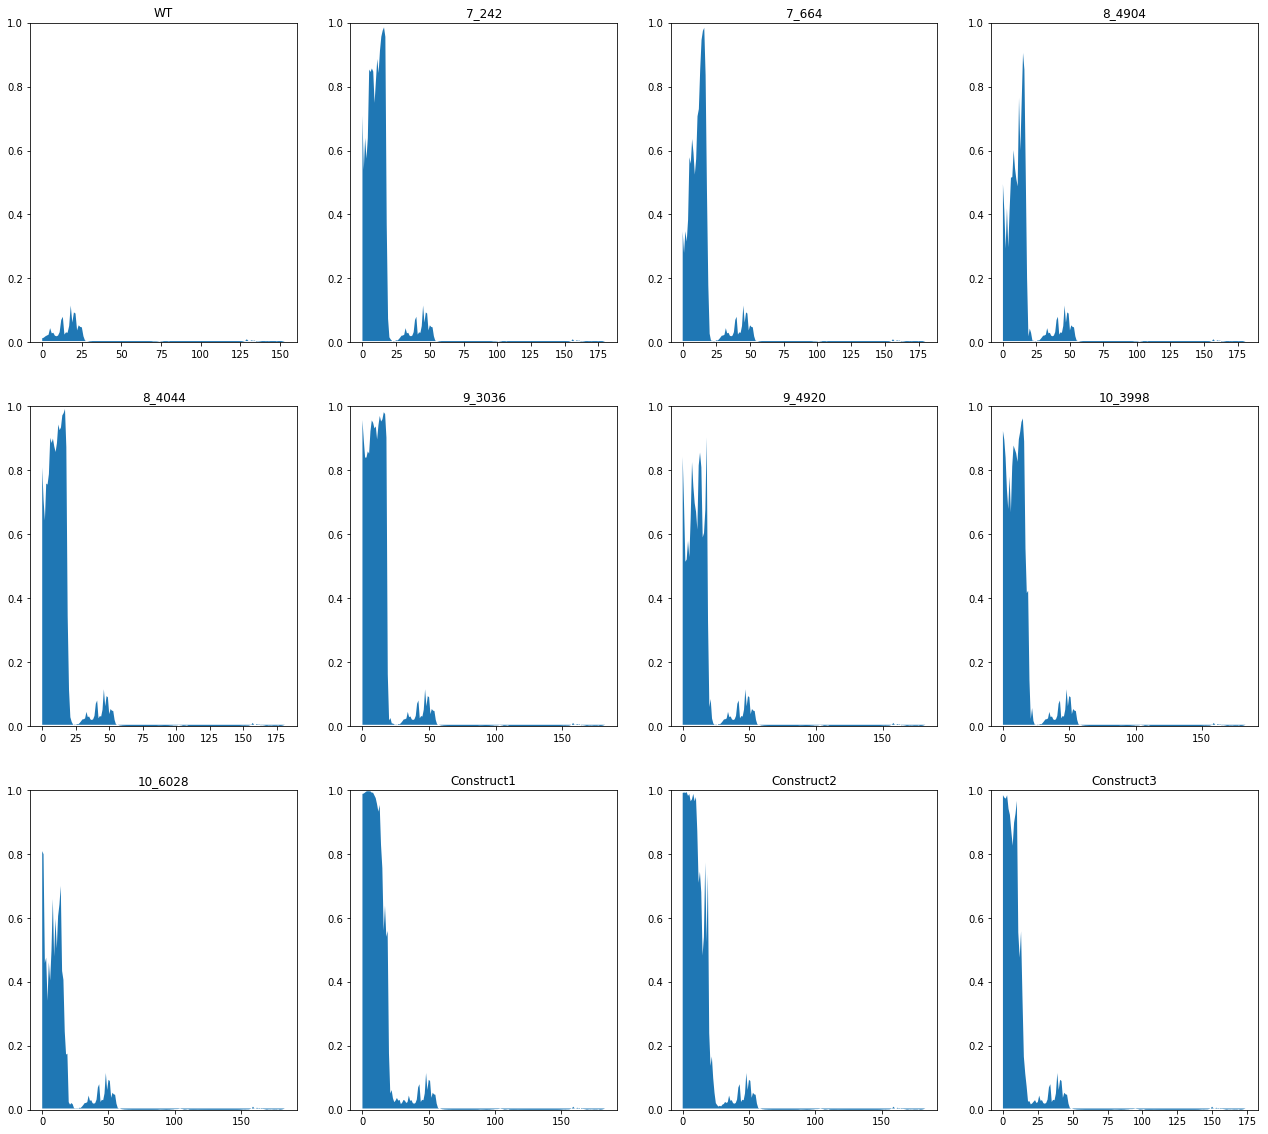

In [793]:
Steves = {
    'WT': 'MSAGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK',
    '7_242': 'MSAgtqasqtgaqssnLEWWLFFagsqqqtGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK',
    '7_664': 'MSAgtqasqtgaqssnYNFWWIWagsqqqtGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK',
    '8_4904': 'MSAgtqasqtgaqssnWIWACWLFagsqqqtGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK',
    '8_4044': 'MSAgtqasqtgaqssnIFLWFDFWagsqqqtGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK',
    '9_3036': 'MSAgtqasqtgaqssnMDWWMFTDWagsqqqtGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK',
    '9_4920': 'MSAgtqasqtgaqssnCCLWGWDWYagsqqqtGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK',
    '10_3998': 'MSAgtqasqtgaqssnWFGDWTYWPFagsqqqtGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK',
    '10_6028': 'MSAgtqasqtgaqssnCWCWQLGFCWagsqqqtGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK',

    'Construct1': 'MSAQDSFENEEDMETESLLNDILMTIDNNSALLGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK',
    'Construct2': 'MSAELLKQDSFENEEDMETESLLNDILMTIDNNGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK',
    'Construct3': 'MSAFENEEDMETESLLNDILMTIDGDNDIPAGTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGERMDYKDHDGDYKDHDIDYKDDDDK'
}

f,ax = plt.subplots(3, 4, figsize=(22,20))
for n, (k,v) in enumerate(Steves.items()):
    seq = v.replace(' ','').upper()
    struct = psipred(seq)
    ohe = prepare_ohe([seq, struct])
    predictions = []
    
    for i in range(0,len(seq)-30):
        predictions.append(ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0])
    
    ax1, ax2 = n//4, n%4 
    ax[ax1][ax2].set_title(k)
    ax[ax1][ax2].fill_betweenx(predictions, np.arange(len(predictions)))
    ax[ax1][ax2].set_ylim(0,1)
    
plt.savefig('Steves_sequences.png', dpi=300)

In [59]:
test_samples = {
    'A1m':'msaFYSTKYMRWAARWYFTQTRPSSGDNRSRPCgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'A1p':'msaYQKTRGATARSPRRSSSNPTWWFDYFYCMRgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'B1m':'msaIHWRPLVYLKWHRFNTTLSQGNCSEPENWPgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'B1p':'msaHRRTHNYEKSCTSLEPWWQFGINLVNWPPLgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'B2m':'msaWILRRGARSWRLFRATHLSIKDDECSEPYNgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'B2p':'msaRRKRARGSRPTHWDLLWDEYSEISAFCNLIgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'C1m':'msaIACFLYYVVHYQTNGYVHSCGAWNDSSHDDgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'C1p':'msaHHGNSSCTVSCDYIWYDLQYHFYGVDNAAVgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'C2m':'msaLLCWYFVVVGKTYKDGVGNRWMGDDNETTTgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'C2p':'msaVKNTCVREGTTGKGTDYLVMNWWDGFYDVLgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'D1m':'msaLIISFVEFAMGDIATGKDTGDSDDSDDRYVgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'D1p':'msaSTKGVALDDVEGDDDFYMFDIDIIASRSTGgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'D2m':'msaICGLLLVLVSIVTDENINESPGNEDADYDLgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'D2p':'msaNNGTSIEGCSENIDVVLEADLDLPLDYLIVgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'E1m':'msaFYASVGVYWDRYFGEEEGRSDEDEDDNEDDgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'E1p':'msaRSARDDGVGEEEEDDYGVYYDFDEWFDENSgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'E2m':'msaFVFACAVLIEGEGHTKDFEVNDDDEEDDNLgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    'E2p':'msaDNEFCLDVEIFEEFDDLDEKVAVGDTGNAHgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    '9_9304':'msaLCWWWTMVYgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    '9_188':'msaFELEWWLFFgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    '9_2212':'msaLCWWWTMVYgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    '10_1345':' msaWDFGHWLWACgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    '10_1992':'msaSWEWWITSMYgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk',
    '10_7574':'msaWEIFWAYYWTgdndipagtddvsladkaiesteevslvpsnlevsttsflptpvledakltqtrkvkkpnsvvkkshhvgkddesrldhlgvvaynrkqrsiplspivpessdpaalkrarnteaarrsrarklqrmkqledkveellsknyhlenevarlkklvgermdykdhdgdykdhdidykddddk'
}

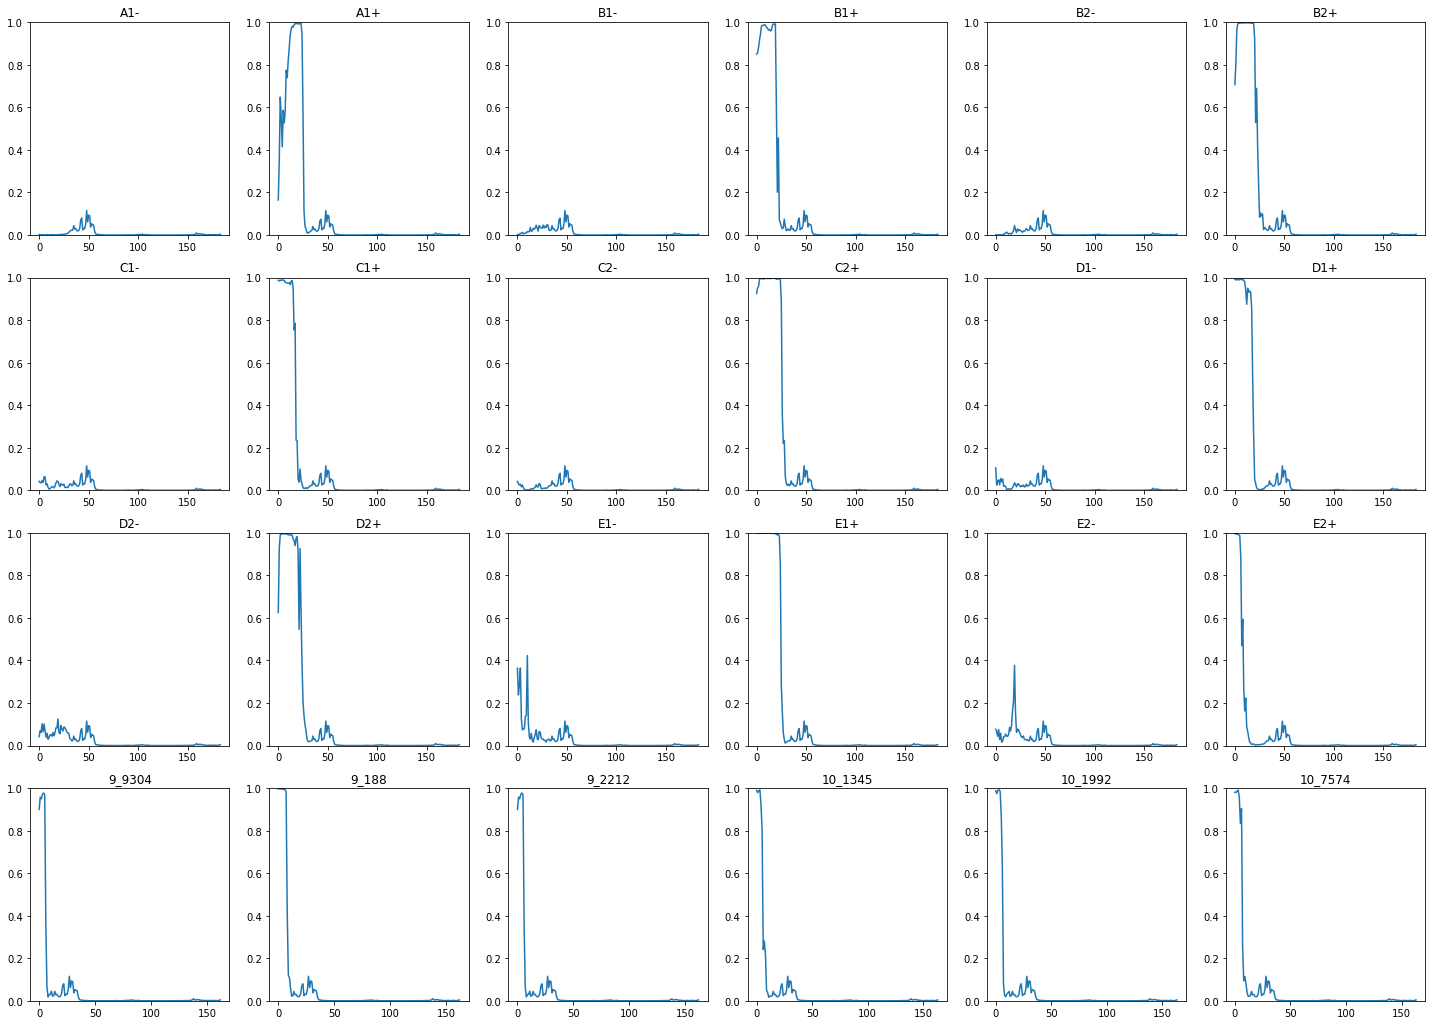

In [824]:
fig, ax = plt.subplots(4,6, figsize=(25,18))

for n, (k,sample) in enumerate(test_samples.items()):
    seq = sample.upper().replace(' ','')
    struct = psipred(seq)
    ohe = prepare_ohe([seq, struct])

    predictions = []
    for i in range(0,len(seq)-30):
        predictions.append(ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0])

    ax1, ax2 = n//6, n%6
    ax[ax1][ax2].plot(predictions)
    ax[ax1][ax2].set_ylim(0,1)
    ax[ax1][ax2].set_title(k.replace('m','-').replace('p','+'))

    # 8AM -> R107G 900 building ocus pocus restaurant mexican cummings
    np.max(predictions)
    
plt.savefig('not_convinced.png')

In [801]:
a = mut_analysis(sequence, np.max(predictions))

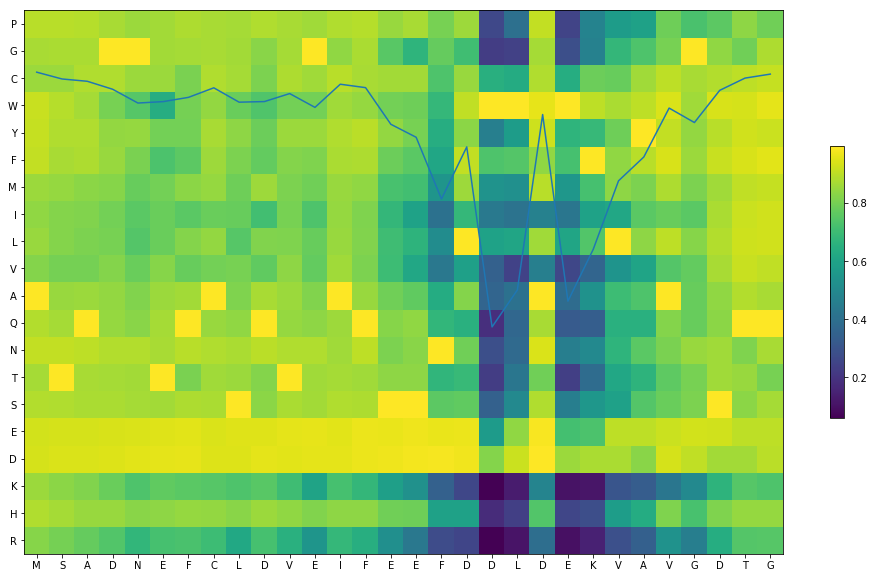

In [805]:
f, ax = plt.subplots(1,1,figsize=(17,10))
im = ax.pcolor(a.T)
ax.set_xticks(np.arange(30)+0.5)
ax.set_yticks(np.arange(20)+0.5)
ax.set_xticklabels([i for i in seq])
ax.set_yticklabels(aa)
plt.colorbar(im, shrink=0.5, ax=ax)
plt.plot(np.arange(0.5, 30.5), np.sum(a, axis=1))

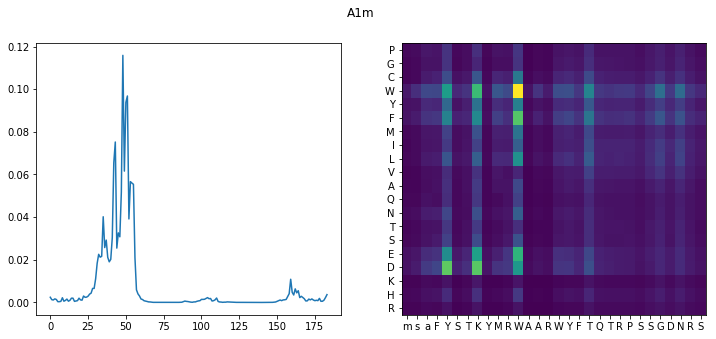

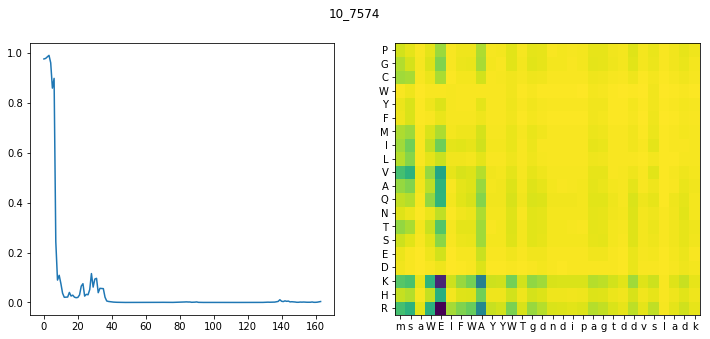

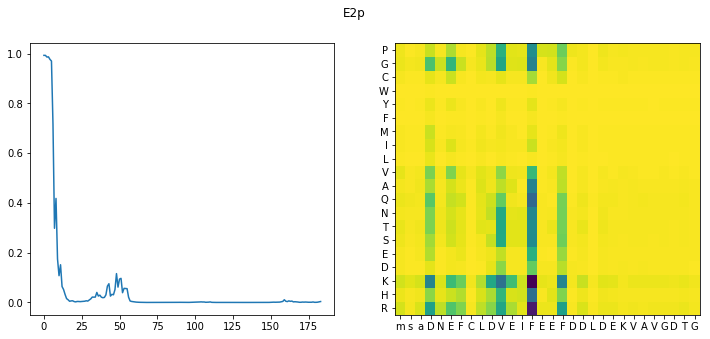

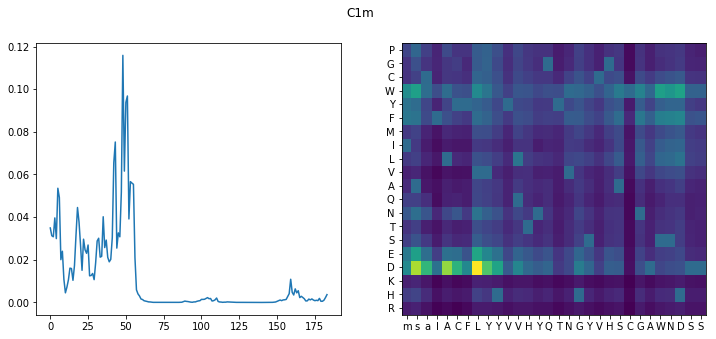

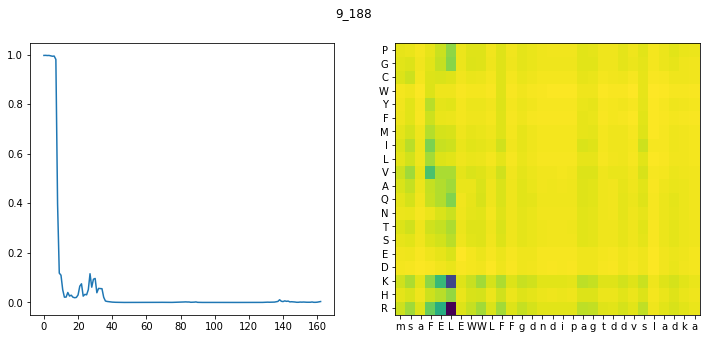

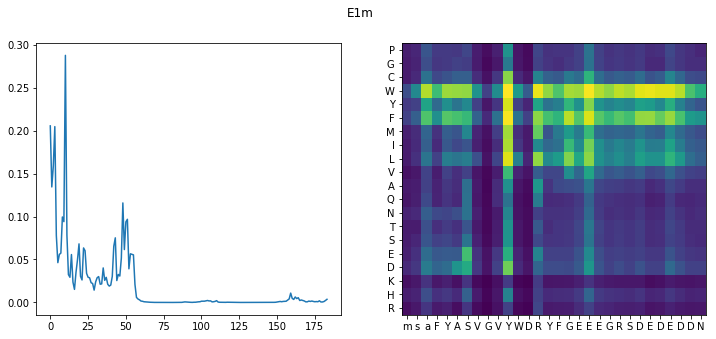

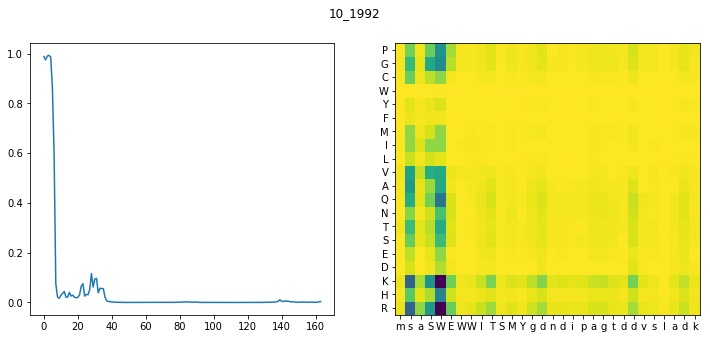

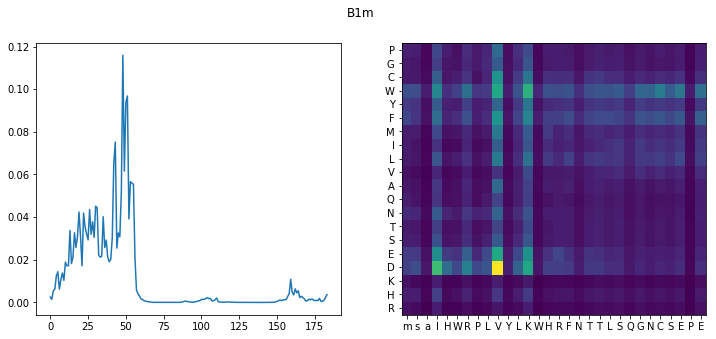

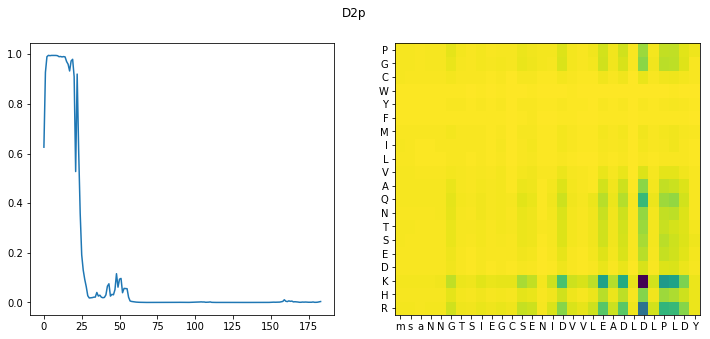

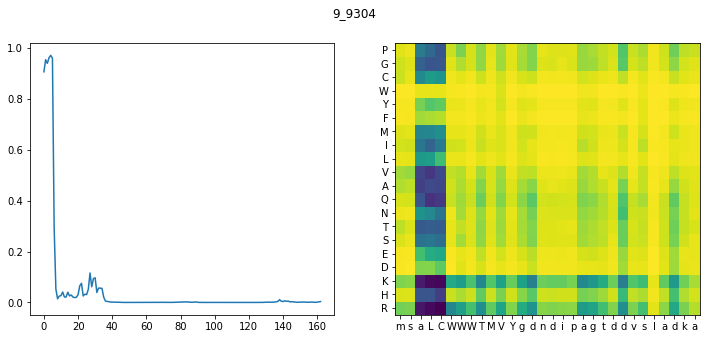

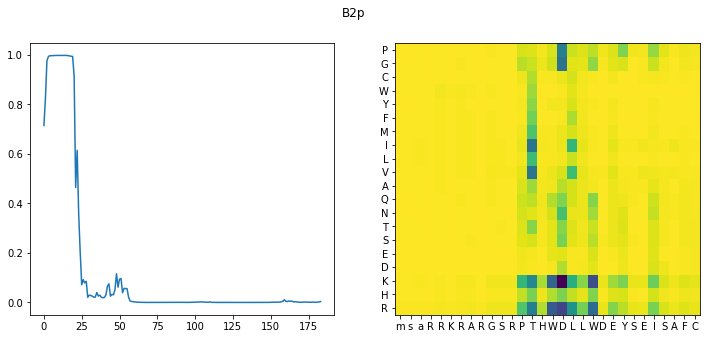

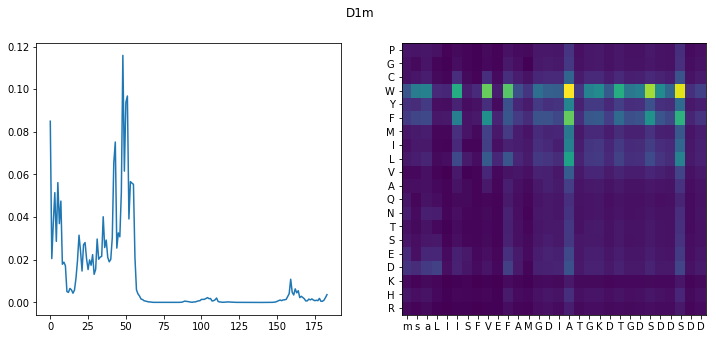

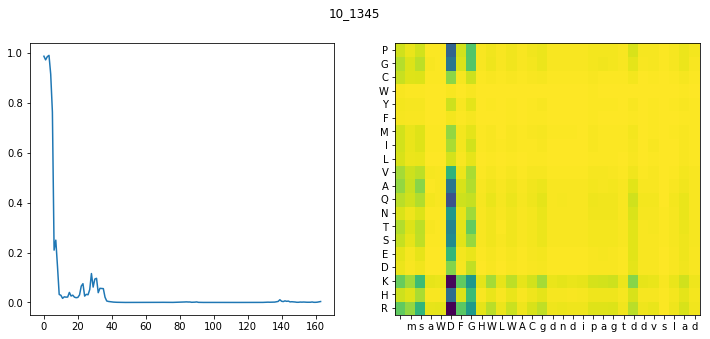

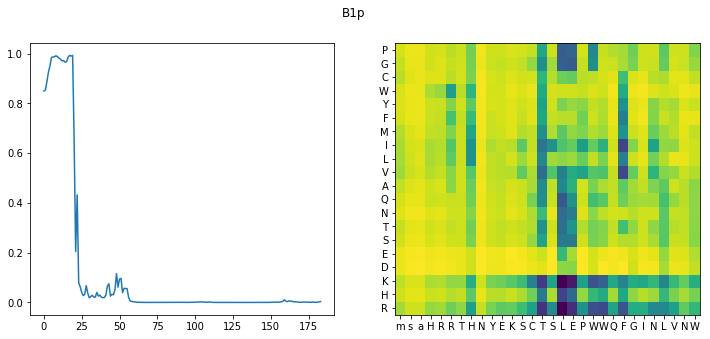

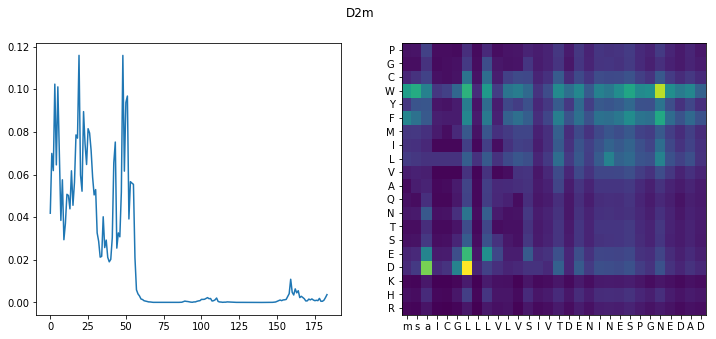

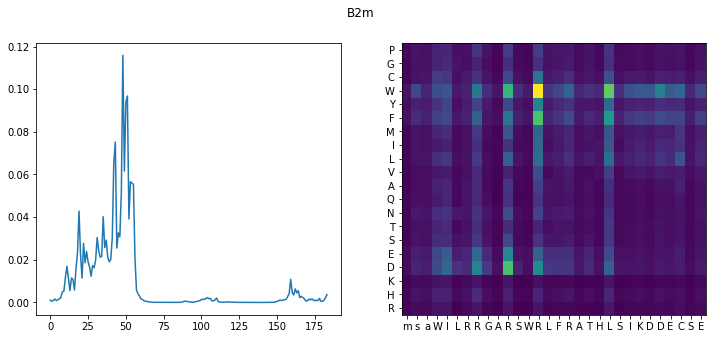

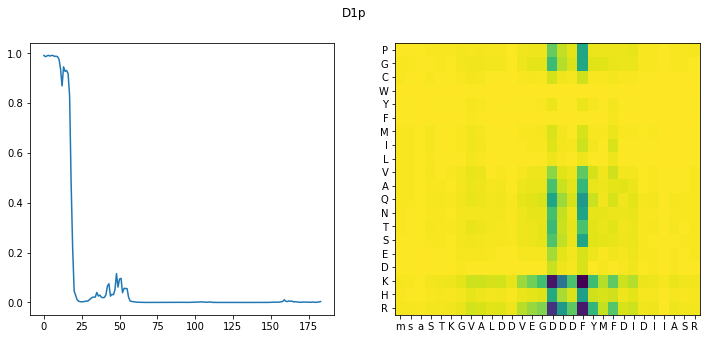

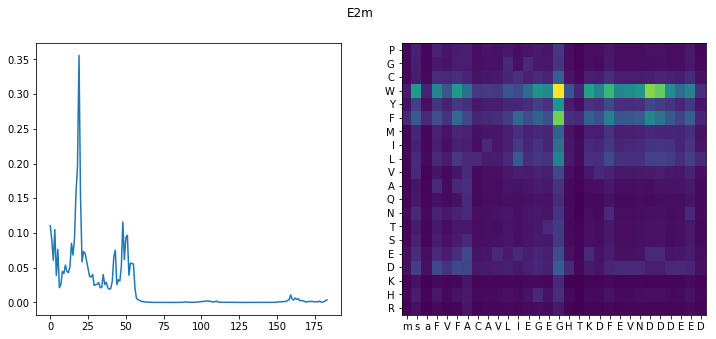

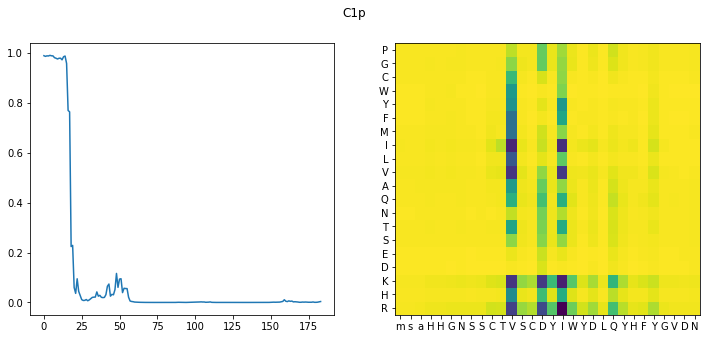

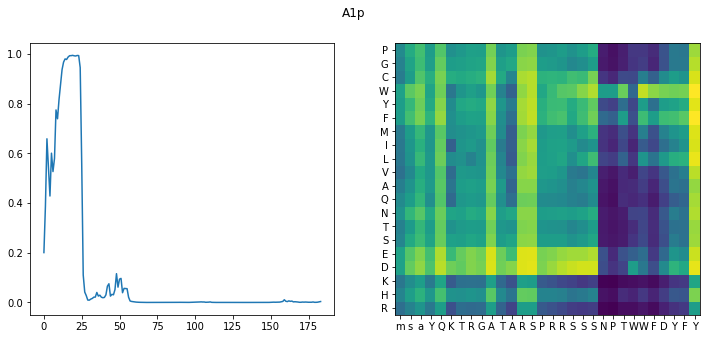

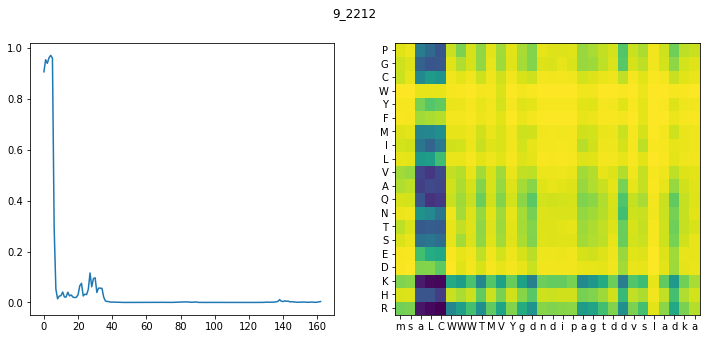

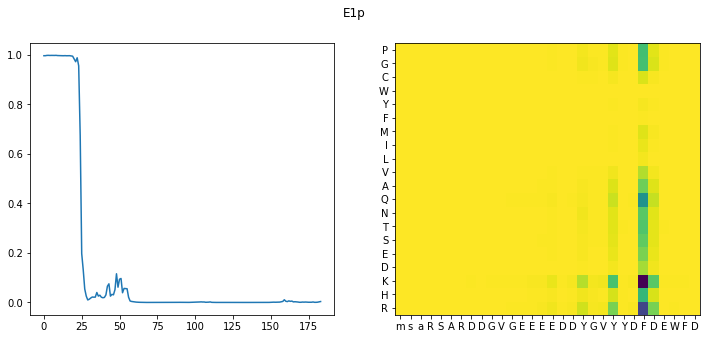

In [837]:
for i in os.listdir('review/mutanalysis/'):
    if not re.search('results', i) and re.search('pkl',i):
        with open('review/mutanalysis/'+i, 'rb') as f:
            a = pickle.load(f)

        seq = test_samples[i[:-4]]
        
        f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
        ax1.plot(a['adpred_profile_protein'])
        ax2.pcolor(a['mutanalysis'])
        ax2.set_xticks(np.arange(30)+0.5)
        ax2.set_yticks(np.arange(20)+0.5)
        ax2.set_xticklabels([i for i in seq])
        ax2.set_yticklabels(aa)
        plt.colorbar(im, shrink=0.5, ax=ax)
        plt.suptitle(i[:-4])

In [858]:
with open('data/test/test.pkl','rb') as f:
    a = pickle.load(f)
    
a.keys()

dict_keys(['adpred_profile_protein', 'mutanalysis'])

In [53]:
staller = pd.read_csv('review/Staller.complete.csv').values
plt.pcolor(staller[:,1:])

### Reviewer2 general
---
- Applying adpred to the complete humana proteome and compute enrichment in a list of TFs from [Vaquerizas et al.](https://www.nature.com/articles/nrg2538).   
- Applying adpred to the complete proteome of fly and compute emrichment in a list of TFs from [Hammonds et al.](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2013-14-12-r140)
- Select few well known ADs from human (or fly), compute adpred and compare with what's known. 

In [6]:
import requests

# functions to download fastas
def clean_input(fasta):
    if fasta[0]==">":
        fasta = ''.join(fasta.split('\n')[1:])
    return fasta.replace('\n','').replace('\r','').upper()


def identifier2fasta(sequence):
    page1 = 'https://www.uniprot.org/uniprot/'+ sequence.replace(' ','').replace('\n','') +'.fasta'
    page2 = 'https://www.uniprot.org/uniprot/?query='+ sequence.replace(' ','').replace('\n','') +'&sort=score'
    page='  '
    
    # case is a uniprot systematic name 
    try:
        page = requests.get(page1).text
    except Exception as e:
        print('fasta page could not be downloaded in the first exception',str(e))
        
    # case is a common name (e.g. gcn4)
    if page[0] == ">":
        return clean_input(page)

    else:
        try:
            page = requests.get(page2).text
            identifier = re.search("<tr id=\".{1,10}\"", page).group()[7:].replace('"','')
            return clean_input(requests.get('https://www.uniprot.org/uniprot/'+ identifier +'.fasta').text)

        except Exception as e:
            print('protein name could not be extracted from uniprot site',str(e))

    return -1

def get_tf(ID):
    sequence = identifier2fasta(ID)
    struct = psipred(sequence)
    ohe = prepare_ohe([sequence, struct])
    adpred = np.array([ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0] for i in range(len(sequence)-30)])
    
    return {'adpred': adpred, 'sequence':sequence}

In [3]:
def get_pfam(pfam_json_line):
    '''
        function extract description and coordinates within protein sequence of 
        pfamA matches
    '''
    domains = [i.group() for i in re.finditer('"env":{"to":"[0-9]*","from":"[0-9]*"}',line)]

    descriptions_off = [i.start()-2 for i in re.finditer('"hmm":{"to":"[0-9]*","from":"[0-9]*"}',line)]
    descriptions_on  = [i.end()+1 for i in re.finditer('"desc":',line)]
    descriptions = [line[i:j] for i,j in zip(descriptions_on, descriptions_off)]

    starts, ends = [],[]
    for i in domains:
        starts.append(re.search('"from":"[0-9]*"',i).group()[8:].replace('"',''))
        ends.append(re.search('"to":"[0-9]*"',i).group()[6:].replace('"',''))
    
    domains = {}
    for i,j,k in zip(descriptions, starts, ends):
        domains[i] = {
            'start':int(j), 
            'end':int(k)
        }
    
    return domains

In [29]:
# get pfam for all samples

pfam = {}

with open('review/pfamA.fastp','r') as f:
    while True:
        try:
            line = next(f)
            if line[0]==">":
                name=line.strip()[1:]
            elif 'name' in locals():
                pfam[name] = get_pfam(line)
                del name
        except StopIteration:
            break

In [30]:
pfam['p53']

{'P53 transactivation motif': {'start': 6, 'end': 30},
 'Transactivation domain 2': {'start': 35, 'end': 59},
 'P53 DNA-binding domain': {'start': 99, 'end': 289},
 'P53 tetramerisation motif': {'start': 319, 'end': 358}}

In [51]:
for k,v in pfam.items():
    print(pcols.B + k + pcols.S)
    for k2,v2 in v.items():
        print('{:<50}: {:<4}-{:>4}'.format(k2,v2['start'], v2['end']))
    print()

p53
P53 transactivation motif                         : 6   -  30
Transactivation domain 2                          : 35  -  59
P53 DNA-binding domain                            : 99  - 289
P53 tetramerisation motif                         : 319 - 358

fos
bZIP transcription factor                         : 135 - 197

myc
Myc amino-terminal region                         : 1   - 345
Helix-loop-helix DNA-binding domain               : 355 - 407
Myc leucine zipper domain                         : 408 - 438

P05412
Jun-like transcription factor                     : 5   - 241
bZIP transcription factor                         : 250 - 313

P10275
Androgen receptor                                 : 6   - 449
Zinc finger, C4 type (two domains)                : 558 - 627
Ligand-binding domain of nuclear hormone receptor : 690 - 881

nfkb1
Rel homology DNA-binding domain                   : 44  - 242
Rel homology dimerisation domain                  : 251 - 353
Ankyrin repeats (3 copies)       

> p53 
 MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD
> fos 
 MMFSGFNADYEASSSRCSSASPAGDSLSYYHSPADSFSSMGSPVNAQDFCTDLAVSSANFIPTVTAISTSPDLQWLVQPALVSSVAPSQTRAPHPFGVPAPSAGAYSRAGVVKTMTGGRAQSIGRRGKVEQLSPEEEEKRRIRRERNKMAAAKCRNRRRELTDTLQAETDQLEDEKSALQTEIANLLKEKEKLEFILAAHRPACKIPDDLGFPEEMSVASLDLTGGLPEVATPESEEAFTLPLLNDPEPKPSVEPVKSISSMELKTEPFDDFLFPASSRPSGSETARSVPDMDLSGSFYAADWEPLHSGSLGMGPMATELEPLCTPVVTCTPSCTAYTSSFVFTYPEADSFPSCAAAHRKGSSSNEPSSDSLSSPTLLAL
> myc 
 MPLNVSFTNRNYDLDYDSVQPYFYCDEEENFYQQQQQSELQPPAPSEDIWKKFELLPTPPLSPSRRSGLCSPSYVAVTPFSLRGDNDGGGGSFSTADQLEMVTELLGGDMVNQSFICDPDDETFIKNIIIQDCMWSGFSAAAKLVSEKLASYQAARKDSGSPNPARGHSVCSTSSLYLQDLSAAASECIDPSVVFPYPLND

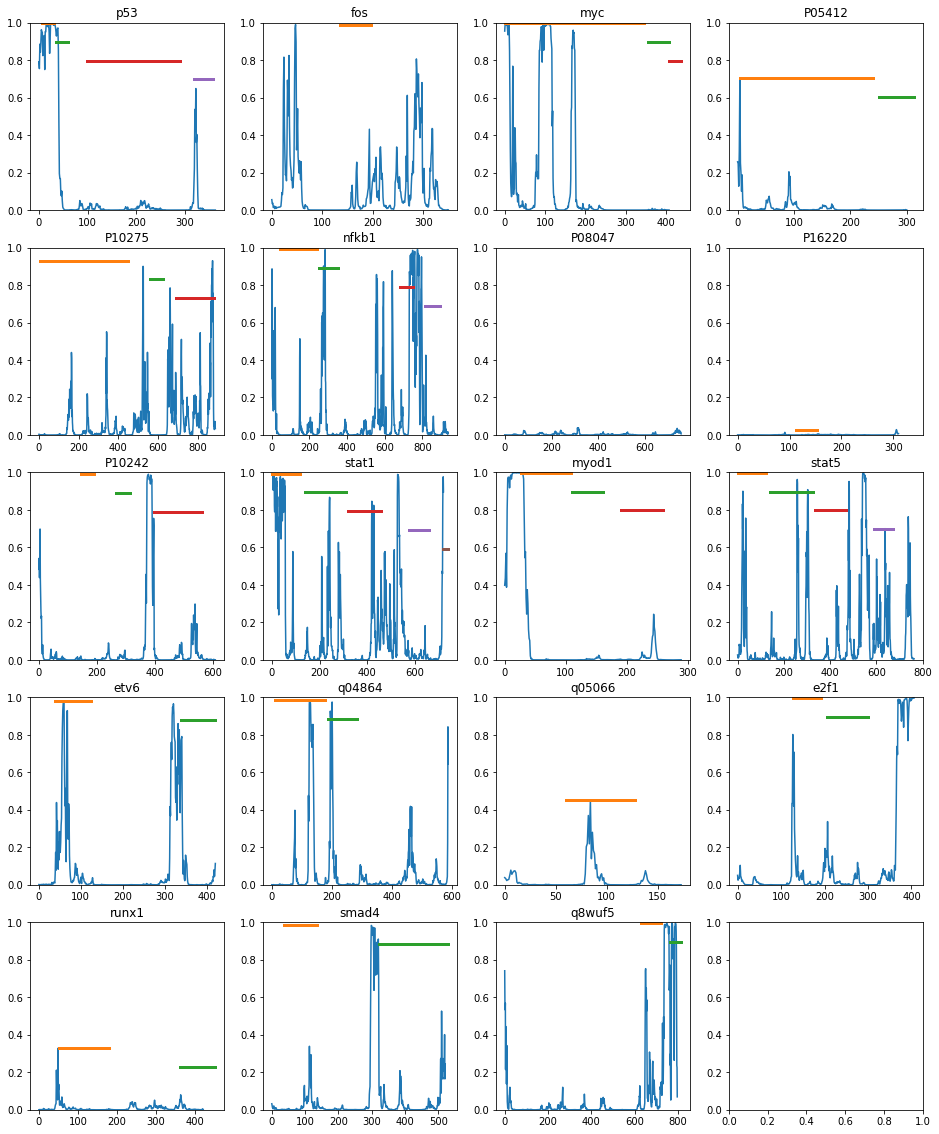

In [33]:
tfs = ['p53','fos', 'myc', 'P05412', 'P10275', 'nfkb1', 'P08047', 'P16220', 'P10242', 'stat1', 'myod1', 'stat5', 'etv6', 'q04864', 'q05066', 'e2f1', 'runx1', 'smad4', 'q8wuf5']

f,ax = plt.subplots(5,4, figsize=(16,20))
for n,i in enumerate(tfs):
    # get sequence and adpred score
    vars()[i] = get_tf(i)
    ax1, ax2 = n//4, n%4
    
    # plot adpred scores
    smoothed = eval(i)['adpred']  # actually not smoothed on purpose. ADs doesn't seem to be long enough...
    ax[ax1][ax2].plot(smoothed)
    ax[ax1][ax2].set_ylim(0,1)
    ax[ax1][ax2].set_title(i)
    
    # plot regions with a match on a pfamA domain/motif
    ymax = np.max(smoothed)
    for c, k in enumerate(pfam[i]):
        X = [pfam[i][k]['start'], pfam[i][k]['end']]
        Y = [ymax-c/10, ymax-c/10]
        ax[ax1][ax2].plot(X,Y, lw=3)
        #ax[ax1][ax2].text(X[0],Y, k)

    print('>',i,'\n', get_tf(i)['sequence'])

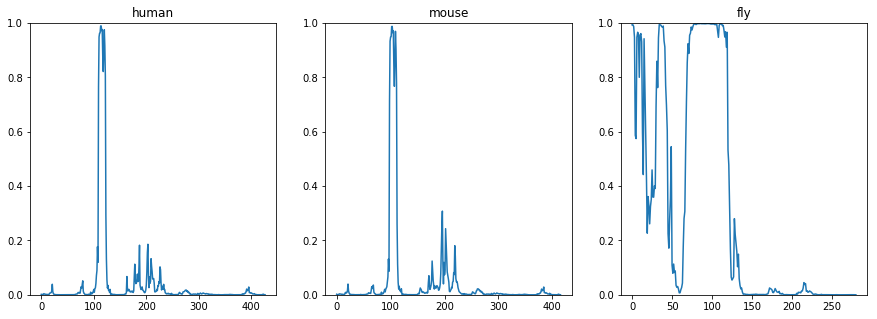

In [147]:
#bteb2
human_bteb2 = 'Q13887'
mouse_bteb2 = 'Q9Z0Z7'
fly_bteb2 = 'Q0IGQ2'

tfs = ['Q13887', 'Q9Z0Z7', 'Q0IGQ2']
names = ['human', 'mouse', 'fly']

f,ax = plt.subplots(1, 3, figsize=(15,5))
for n,i in enumerate(tfs):
    vars()[i] = get_tf(i)
    ax1 = n%3
    smoothed = eval(i)['adpred']  # actually not smoothed on purpose. ADs doesn't seem to be long enough...
    ax[ax1].plot(smoothed)
    ax[ax1].set_ylim(0,1)
    ax[ax1].set_title(names[n])

(0, 1)

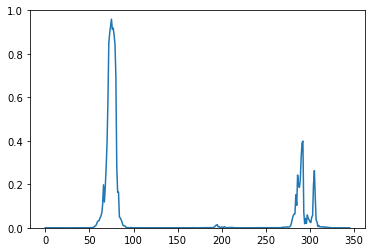

In [140]:
# HLH3b
hlh3b = get_tf('hlh3b')

plt.plot(hlh3b['adpred'])
plt.ylim(0,1)

(0, 1)

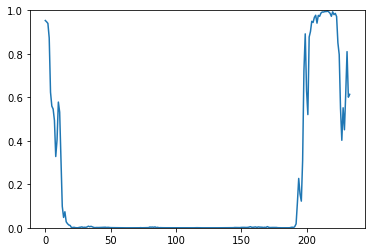

In [141]:
# cg14451
cg14451 = get_tf('cg14451')

plt.plot(cg14451['adpred'])
plt.ylim(0,1)

(0, 1)

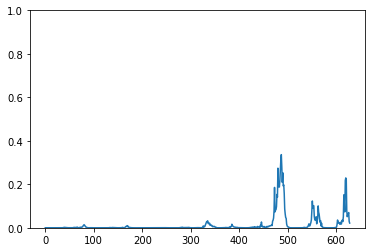

In [142]:
# slou
slou = get_tf('slou')

plt.plot(slou['adpred'])
plt.ylim(0,1)

(0, 1)

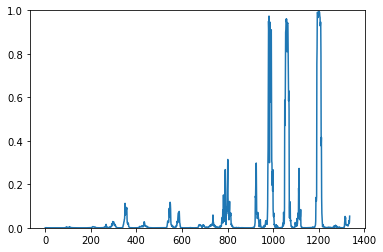

In [143]:
# bin
Bin = get_tf('bin')

plt.plot(Bin['adpred'])
plt.ylim(0,1)

(0, 1)

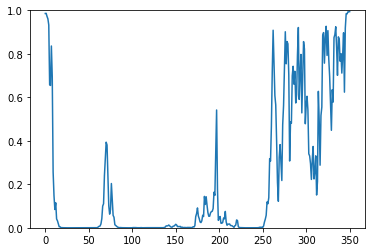

In [144]:
# cg17186

cg17186 = get_tf('cg17186')

plt.plot(cg17186['adpred'])
plt.ylim(0,1)

(0, 1)

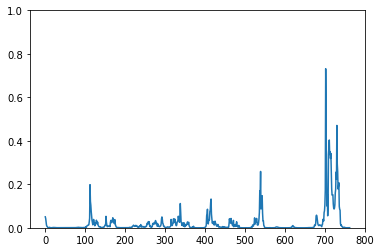

In [145]:
# cas

Q7M3M8 = get_tf('Q7M3M8')

plt.plot(Q7M3M8['adpred'])
plt.ylim(0,1)

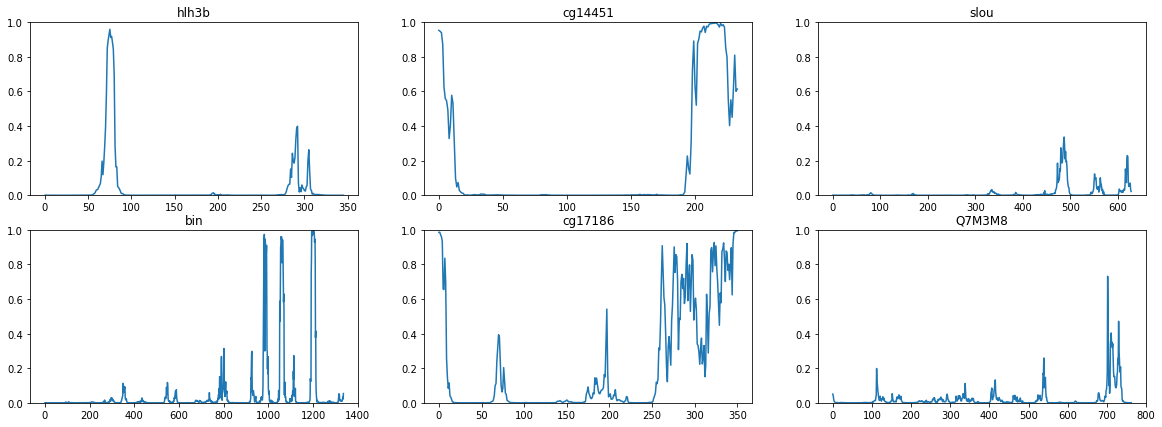

In [167]:
f,ax = plt.subplots(2,3, figsize=(20,7))
for n,i in enumerate(['hlh3b', 'cg14451', 'slou','bin', 'cg17186', 'Q7M3M8']):
    ax1, ax2 =  n//3, n%3
    ax[ax1][ax2].plot(eval(i)['adpred'])
    ax[ax1][ax2].set_ylim(0,1)
    ax[ax1][ax2].set_title(i)

In [4]:
def make_mutant(wt_sequence, mutations_list):
    mutant = [i for i in wt_sequence]
    
    for mutation in mutations_list:
        wt = mutation[0]
        mut = mutation[-1] 
        pos = int(mutation[1:-1]) -1  # substract 1 since here is 0-based but in publication is 1-based
        
        assert mutant[pos]==wt, "ups... missmatch in protein position..." + mutation
        mutant[pos] = mut
    return ''.join(mutant)        

VP16_HHV1F
list index out of range
P53_HUMAN
MYC_HUMAN
FOS_HUMAN
JUN_HUMAN
AP2A1_HUMAN
AP2A2_HUMAN
E2F1_HUMAN
MYOD1_HUMAN
SMAD4_HUMAN
Q8Wvf5
RUNX1_HUMAN
NFKB1_HUMAN
ETV6_HUMAN
SP1_HUMAN
MYB_HUMAN
EPAS1_HUMAN


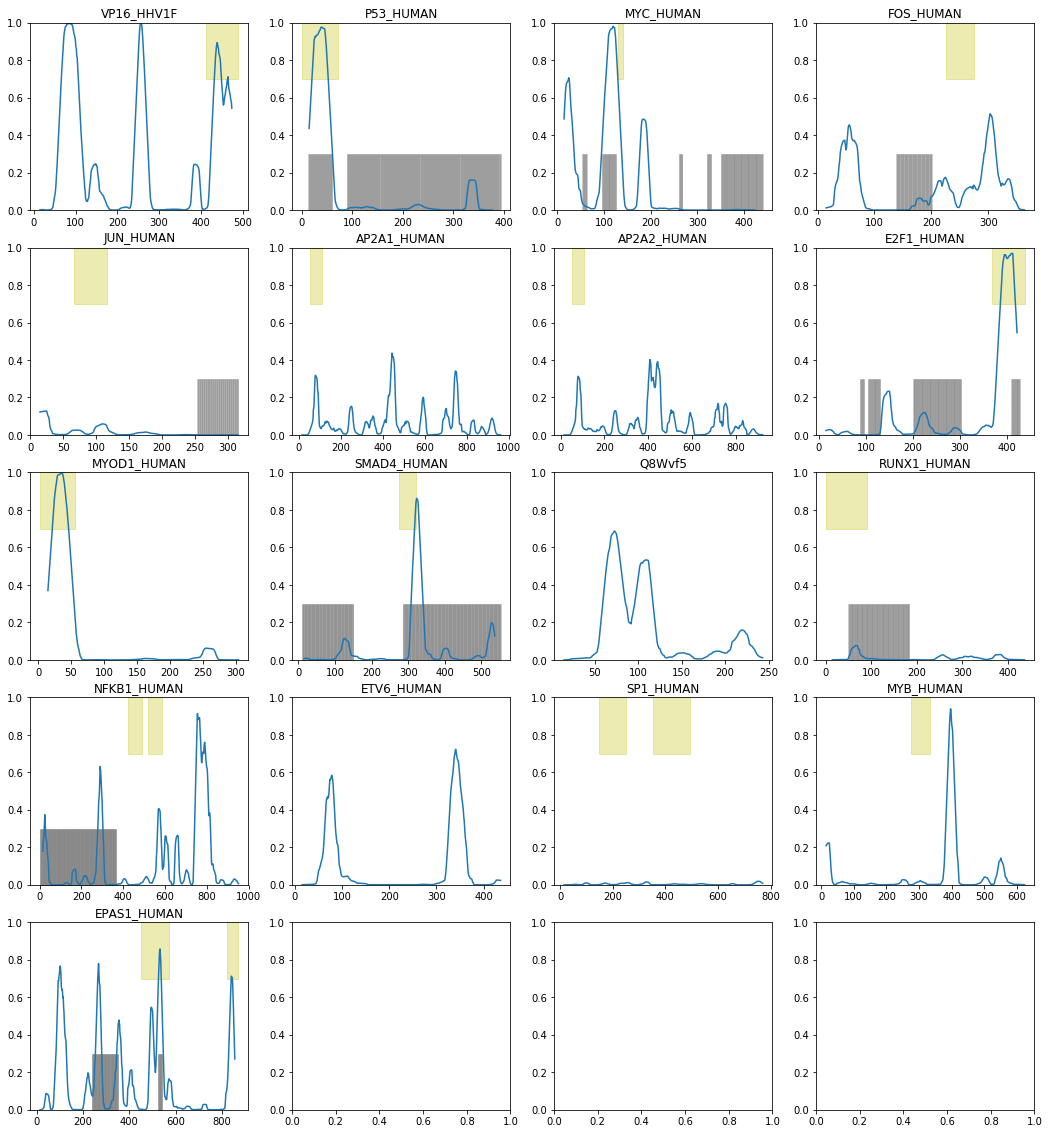

In [48]:
# look at TFs that Steve sent me earlier

experimental_ADs = {
    'VP16_HHV1F':['413-490'], 
    'P53_HUMAN':['1-73'], 
    'MYC_HUMAN':['130-140'], 
    'FOS_HUMAN':['226-276'], 
    'JUN_HUMAN':['67-117'], 
    'AP2A1_HUMAN':['52-108'], 
    'AP2A2_HUMAN':['52-108'],
    'E2F1_HUMAN':['368-437'],
    'MYOD1_HUMAN':['3-56'],
    'SMAD4_HUMAN':['275-322'], 
    'Q8Wvf5':[], 
    'RUNX1_HUMAN':['1-92'],
    'NFKB1_HUMAN':['425-490', '518-587'],
    'ETV6_HUMAN':[], 
    #'TEL1_HUMAN':[], 
    'SP1_HUMAN':['146-251', '352-494'], 
    'MYB_HUMAN':['275-335'],  # double check. Steve wrote 275-235 
    'EPAS1_HUMAN':['450-572', '820-870'] # HIF2A
}


def structured_regions(protein_id):
    '''
        function retrieves residues that are structured in a protein
        INPUT: protein_id and sequence where id_page is the front page of the uniprot id
        OUTPUT: array with zeros where no structure was found and 1 if structure was found.
    '''
    query_page = 'https://www.uniprot.org/uniprot/?query='+ protein_id.replace(' ','').replace('\n','') +'&sort=score'
    page = requests.get(query_page)

    
    try:
        if page.status_code == 200:
            identifier = protein_id
            id_page = page.text

        else:
            identifier = re.search("<tr id=\".{1,10}\"", page.text).group()[7:].replace('"','')
            id_page = requests.get('https://www.uniprot.org/uniprot/' + identifier).text

        sequence = requests.get(
            'https://www.uniprot.org/uniprot/'+ identifier.replace(' ','').replace('\n','') +'.fasta'
        ).text
     
        sequence = ''.join(sequence.split('\n')[1:])   

    except Exception as e:
        sys.stderr.write(str(e))
        return 


    # output array
    structured_regions = np.zeros(len(sequence), dtype=int)
    
    if re.search("<td>Method</td>", id_page) == None: 
        return structured_regions

    else:   
        try:
            start_section_pdb = re.search("<td>Method</td>", id_page).end()
            end_section_pdb = [i.start() for i in re.finditer(
                                                              "Protein-protein interaction databases", id_page[start_section_pdb:]
                                                             )][-1] + start_section_pdb
        except Exception as e:
            print(e)
            return structured_regions
            
        pdb_raw = id_page[start_section_pdb:end_section_pdb]
        rows = [i for i in pdb_raw.split('<tr>')]

        for i in rows:
            cols = i.split('<td>')
            if len(cols)<6: continue  # header has <6 columns
            if cols[2] == 'X-ray</td>':
                region = np.array((re.search("[0-9]*-[0-9]*", cols[5]).group()).split("-")).astype(int)
                structured_regions[region[0]:region[1]+1] = 1

            
        return structured_regions


def get_tf_with_pdb(ID):
    sequence = identifier2fasta(ID)
    struct = psipred(sequence)
    ohe = prepare_ohe([sequence, struct])
    adpred = np.array([ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0] for i in range(len(sequence)-30)])
    pdb = structured_regions(ID)
    
    return {'adpred': adpred, 'sequence':sequence, 'pdb':pdb}


f,ax = plt.subplots(5,4, figsize=(18,20))

TFs = {}

for n, (tf_name, ads) in enumerate(experimental_ADs.items()):
    ax1, ax2 = n//4, n%4
    print(tf_name)
    TF = get_tf_with_pdb(tf_name)
    
    TFs[tf_name] = TF
    
    ax[ax1][ax2].plot(np.arange(15, len(TF['adpred'])+15), np.convolve(TF['adpred'], np.ones(20)/20, 'same'))
    ax[ax1][ax2].set_ylim(0,1)
    ax[ax1][ax2].set_title(tf_name)
    
    if ads == []: continue
        
    for i in ads:
        x = np.array(i.split('-')).astype(int)
        ax[ax1][ax2].fill_between(x,0.7,1, color='y',alpha=0.3)
    for pos, i in enumerate(TF['pdb']):
        if i==1:
            ax[ax1][ax2].fill_between([pos,pos+1], 0,0.3, alpha=0.3, color='grey')

In [77]:
gcn4 = identifier2fasta('gcn4')[:101]  # In Jackson et al it's important to test activation of the nAD without the influence of the cAD

In [63]:
mutants = [
    ['M1M'],
    ['F45S'],
    ['G41R','F45L'],
    ['F45Y','D90E'],
    ['S24P','F45I','A80T'],
    ['F48I'],
    ['F48S'],
    ['F48L','Q59R'],
    ['E27K','F48I','E53V'],
    ['V40D','F48I','L84S'],
    ['F48L','V94G','E95N'],
    ['E27K','V29A','F48I'],
    ['T33A','F48S','L65H'],
    ['K37I','Q42K','F67L','A80T'],
    ['T33I','K37R','E52G','S63P','F67S','D68G'],
    ['F69L','L84P','D91G'],
    ['T25A','M39V','P55T','F69S'],
    ['V40A','D66V','F69S','A80V'],
    ['M39K','F69Y','D79N'],
    ['P38S','F69L','P78S','E88K'],
    ['E27V','K37E','I44T','F69S','T76A','L84S'],   # originally was ['E27V','K37E','I45T','F69S','T76A','L84S'], but 44 is I... not 45
    ['K23R','N28T','M39V','D46N','D54G','F69S','A80G','I86T'],
    ['F67A','F69A'],
    ['G41S','F67L','F69L','D79G'],
    ['F97S'],
    ['T25A','F97S'],
    ['N28I','F97S'],
    ['F98S'],
    ['F98V'],
    ['F98 '],  # leave space for the delta in the publication. later clean with str.replace(' ','') 
    ['V94K'],
    ['V40A','I86T'],
    ['D46G','T74K'],
    ['E88K','S99A'],
    ['D46G','D60G','N64S'],
    ['T51P','E53G','D54V'],
    ['N28Y','S34P','Q42H','D54V','Q73R']
]
experimental_scores = [5,0,2,2,2,2,1,3,3,0,1,3,0,3,-1,3,2,0,0,-1,1,1,-1,3,1,1,2,0,4,1,4,2,-1,2,0,3,2]

assert len(experimental_scores) == len(mutants), 'ups...' + str(len(experimental_scores) + str(len(mutants)))

maxs, means = [], []
adpred_profiles = {}
for m in mutants:
    sequence = make_mutant(gcn4, m).replace(' ','')
    struct = psipred(sequence)
    ohe = prepare_ohe([sequence, struct])
    adpred = np.array([ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0] for i in range(len(sequence)-30)])
    
    adpred_profiles[sequence] = adpred
    
    maxs.append(np.max(adpred))
    means.append(np.mean(adpred))

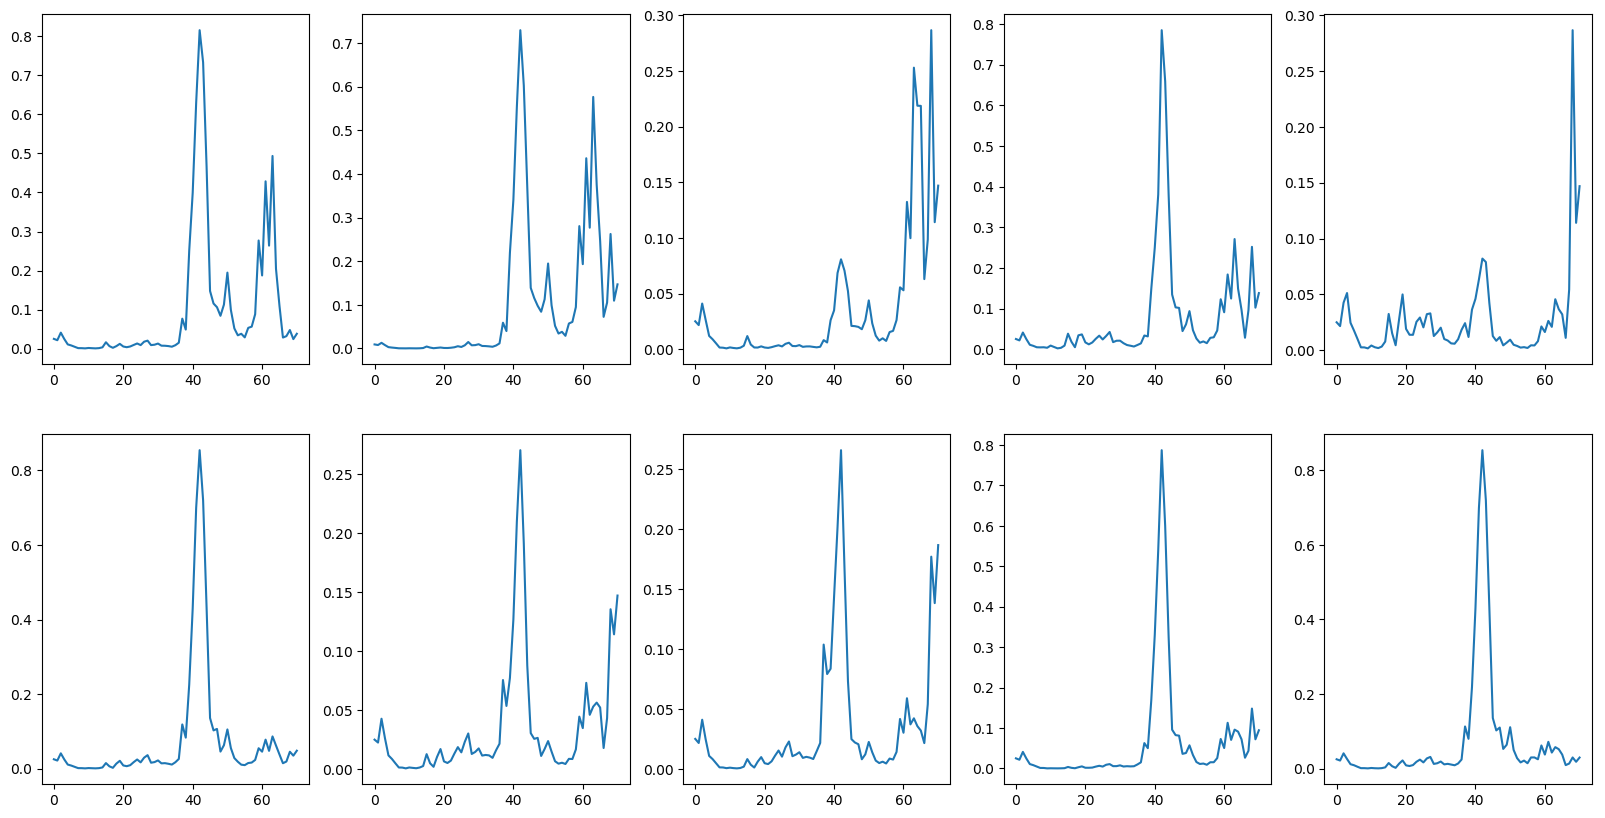

In [868]:
f, ax = plt.subplots(2,5, figsize=(20,10))
for i in range(10):
    ax1,ax2 = i//5, i%5
    k = list(adpred_profiles.keys())[i+10]
    ax[ax1][ax2].plot(adpred_profiles[k])

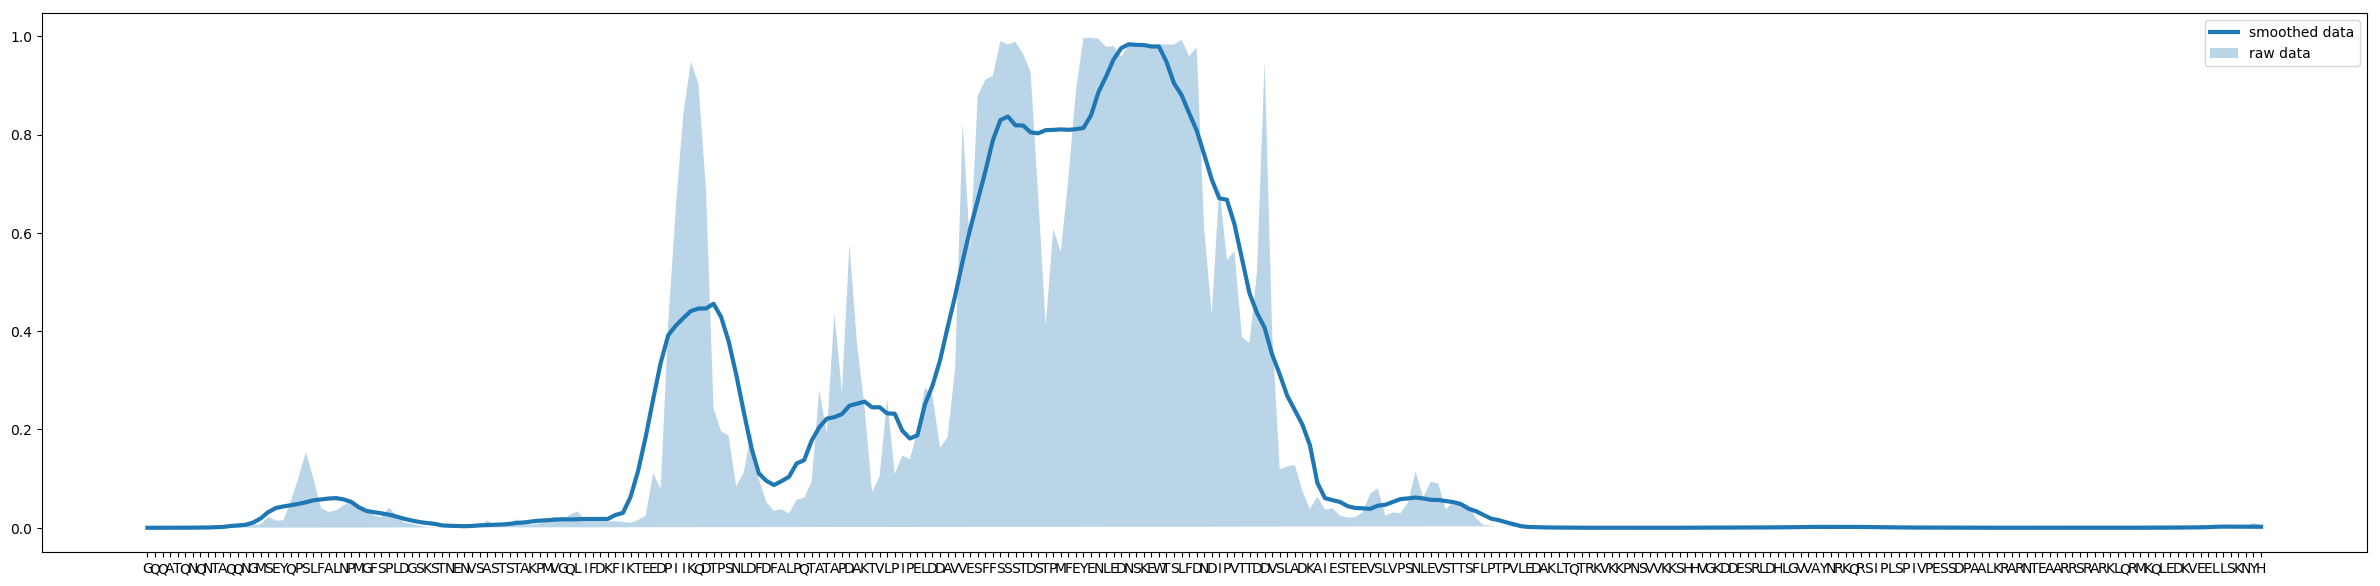

In [869]:
sequence = identifier2fasta('gcn4')
sequence = 'TNSANAANASASSQAGQQATQNQNTAQQNG' + sequence
struct = psipred(sequence)
ohe = prepare_ohe([sequence, struct])
adpred = np.array([ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0] for i in range(len(sequence)-30)])
f,ax = plt.subplots(1,1,figsize=(30,7))
ax.plot(np.convolve(adpred, np.ones(12)/12, 'same'), lw=3, label='smoothed data')
ax.fill(adpred, alpha=0.3, label='raw data')
ax.legend()
ax.set_xticks(np.arange(len(sequence)-30))
ax.set_xticklabels(sequence[15:-15]);
#plt.xlim(0,90)

[[1.       0.946364]
 [0.946364 1.      ]]


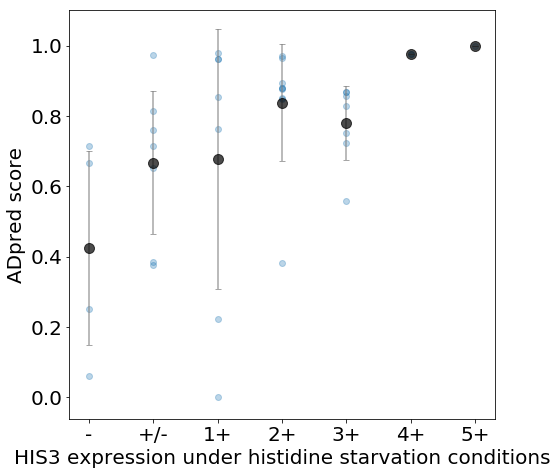

In [66]:
#%matplotlib inline
#plt.style.use('default')

matplotlib.rcParams.update({'font.size': 20})
f,ax = plt.subplots(1,1,figsize=(8,7))

y = normalize(np.log(means))

ax.scatter(experimental_scores, y, alpha=0.3)
#print(np.corrcoef(experimental_scores, np.log(means))) # R = 0.45

#plt.scatter(experimental_scores, [np.log(p/(1-p)) for p in means])
#print(np.corrcoef(experimental_scores, [np.log(p/(1-p)) for p in means])) # R = 0.45

'''
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.array(experimental_scores).reshape(-1,1), np.log(means))
y_hat = reg.predict(np.array([[-1],[4]]))
plt.plot([-1,4], y_hat, c='k', ls='--')
'''

a = np.vstack([experimental_scores, y]).T
jackson_means = np.array([np.mean(a[np.where(a[:,0]==i)[0],1]) for i in np.unique(a[:,0])])
jackson_stds = np.array([np.std(a[np.where(a[:,0]==i)[0],1]) for i in np.unique(a[:,0])])
#plt.scatter(np.unique(a[:,0]), jackson_means, c='r')
print(np.corrcoef(np.unique(a[:,0]), jackson_means))
ax.errorbar(x=np.unique(a[:,0]), y=jackson_means, yerr=jackson_stds, fmt='ok', alpha=0.7, ecolor='grey', capthick=1, capsize=3, markersize=10)
ax.set_ylabel('ADpred score')
ax.set_xlabel('HIS3 expression under histidine starvation conditions')
ax.set_xticks(np.arange(-1,6))
ax.set_xticklabels(["-", "+/-", "1+","2+","3+","4+","5+"])
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 16})

In [50]:
staller = pd.read_csv('review/Staller.complete.csv', header=None).values  # ADpred scores
Nt = 'QANAATNNNAQNGATQGGTQASQTGAQSSN'
Ct = 'AGSQQQTQGNASSANTSTGTGSTAQSQGSN'

In [51]:
df = pd.read_csv('/Users/aerijman/Desktop/AD_summary/publication/analysis/review/1-s2.csv')
ids = df.replace([np.inf, -np.inf], np.nan).dropna().index  #Lot's of missing values
#df = df.loc[ids]
df.columns

Index(['Index', 'ActivationDomainSeq',
       'ActivityCompleteMediaReplicate1_Normalized',
       'ActivityCompleteMediaReplicate2_Normalized', 'Induction',
       'ActivityCompleteMediaReplicate1_Raw',
       'ActivityCompleteMediaReplicate2_Raw', 'ActivityAAStarvation_Raw',
       'MutationClass', 'Charge', 'Hydrophobicity', 'Kappa', 'Disorder',
       'HighStringencySet', 'VeryHighStringencySet', 'mCherryOnly_Raw'],
      dtype='object')

In [52]:
df = df.iloc[:,[0,1,4,5,6,7]]
df = df.loc[ids]
seqs = set(df['ActivationDomainSeq'])

# before collecting Staller indexes, make the adpred matrix correlate with the table. 
# => correlate the indexes by making it a dictionary with same indices=sequences
staller_adpred_dict = {}
for i in df.index:
        staller_adpred_dict[df.loc[i, 'ActivationDomainSeq']] = staller[i,1:]

# lots of repeated sequences in staller's data. Use mean in those.        
df2 = {}
for i in seqs:
    df2[i] = df[df['ActivationDomainSeq']==i][df.columns[2:]].mean(axis=0).values

# make if table again so it's wasy to print
df = pd.DataFrame(df2.values(), index=df2.keys(), columns = df.columns[2:])
df.sample(2)

Induction  \
STDGTPMFEYENLIDNSKEWTSLFDNDHPVTTDDVDLADHAIES   1.003993   
SPQDLFLSDNFMSAPNSTALTTLTSPSLYNGSPDFGDSYDVSPN   1.189569   

                                              ActivityCompleteMediaReplicate1_Raw  \
STDGTPMFEYENLIDNSKEWTSLFDNDHPVTTDDVDLADHAIES                          70822.69629   
SPQDLFLSDNFMSAPNSTALTTLTSPSLYNGSPDFGDSYDVSPN                          52783.56123   

                                              ActivityCompleteMediaReplicate2_Raw  \
STDGTPMFEYENLIDNSKEWTSLFDNDHPVTTDDVDLADHAIES                          55018.59446   
SPQDLFLSDNFMSAPNSTALTTLTSPSLYNGSPDFGDSYDVSPN                          44186.97677   

                                              ActivityAAStarvation_Raw  
STDGTPMFEYENLIDNSKEWTSLFDNDHPVTTDDVDLADHAIES               71105.50178  
SPQDLFLSDNFMSAPNSTALTTLTSPSLYNGSPDFGDSYDVSPN               62789.69882

In [53]:
# staller adpred dict -> only max values --> check that mutations lay on the area meassured !!!
#staller_max_dict = {k: v[40] for k,v in staller_adpred_dict.items()}
staller_max_dict = {k: np.mean(v) for k,v in staller_adpred_dict.items()}

# make it table and append it to df table
df_adpred = pd.DataFrame(staller_max_dict.values(), index=staller_max_dict.keys())
df_complete = pd.concat([df_adpred, df], axis=1)

# correct column labels
df_complete.columns = ['adpred'] + list(df_complete.columns)[1:]

[[1.         0.56991162]
 [0.56991162 1.        ]]
SpearmanrResult(correlation=0.5993668536772926, pvalue=3.472758353339306e-257)
0.5699116218844543 3.487296855783611e-227 9062.743296472589


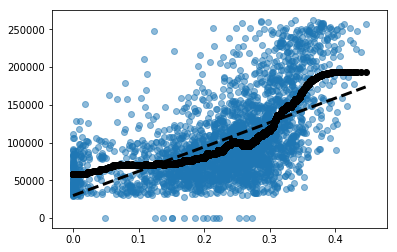

In [54]:
from scipy.stats import spearmanr

def normalize(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))


X = df_complete[['adpred','ActivityAAStarvation_Raw']].values

X = X[~np.isinf(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]
assert np.sum((np.isnan(X)) | (np.isinf(X)))==0, "still nans and/or infs in X"


plt.scatter(X[:,0], X[:,1], alpha=0.5)
print(np.corrcoef(X[:,0], X[:,1]))
print(spearmanr(X[:,0], np.log(X[:,1])))

from sklearn.neighbors import KNeighborsRegressor as kn
nbrs = kn(n_neighbors=200).fit(X[:,0].reshape(-1,1), X[:,1])
y_hat = nbrs.predict(X[:,0].reshape(-1,1))
plt.scatter(X[:,0], y_hat, c='k')

from scipy.stats import linregress
m, b0, R, p ,sd = linregress(X[:,0], X[:,1])
x_hat = np.sort(X[:,0])[np.array([0,-1])]
y_hat = [b0+m*i for i in x_hat]
plt.plot(x_hat, y_hat, ls='--', lw=3, c='k')
print(R,p,sd)

SpearmanrResult(correlation=0.5993668536772926, pvalue=3.472758353339306e-257)

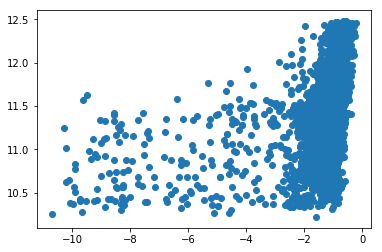

In [55]:
y = np.log(X[:,1])
x = np.array([np.log(p/(1-p)) for p in X[:,0]])
plt.scatter(x,y)
spearmanr(x,y)

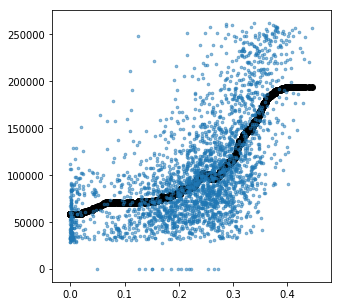

In [56]:
from sklearn.neighbors import KNeighborsRegressor

x, y = X[:,0], X[:,1]

nb = KNeighborsRegressor(n_neighbors=200).fit(x.reshape(-1,1), y)
y_hat = nb.predict(x.reshape(-1,1))

plt.figure(figsize=(5,5))
plt.scatter(x, y_hat, c='k')
plt.scatter(x, y, alpha=0.5, s=7)

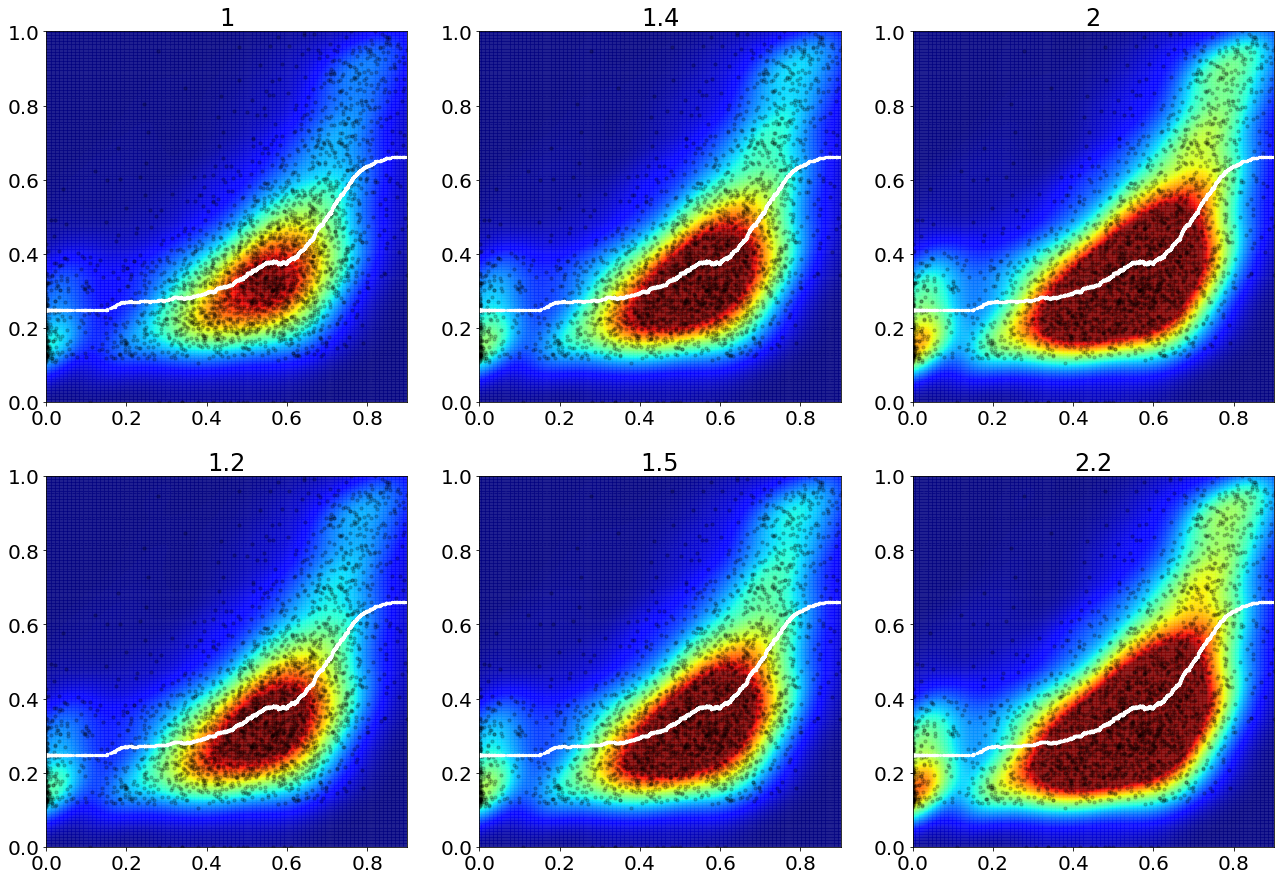

In [60]:
from scipy.stats import kde

matplotlib.rcParams.update({'font.size': 20})
f,ax = plt.subplots(2,3, figsize=(22,15))

# rescale x to between 0 anad 1
x = normalize(X[:,0])
y = normalize(X[:,1])
#x, y = X[:,0], X[:,1]

nbins=500
k = kde.gaussian_kde(np.vstack([x,y]))
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

nb = KNeighborsRegressor(n_neighbors=400).fit(x.reshape(-1,1), y)
y_hat = nb.predict(x.reshape(-1,1))

for i,j in zip(np.arange(6), [1, 1.2, 1.4, 1.5, 2, 2.2]):
    ax1, ax2 = i%2, i//2
    # saturate the scale earlier
    norm = plt.Normalize(np.min(zi), np.max(zi)/j)

    ax[ax1][ax2].pcolormesh(xi,yi,zi.reshape(xi.shape), cmap='jet', norm=norm, alpha=0.4)
    ax[ax1][ax2].scatter(x, y, alpha=0.2, s=10, c='k')
    ax[ax1][ax2].scatter(x, y_hat, c='white', s=5, alpha=0.9)

    ax[ax1][ax2].set_title(str(j))
    ax[ax1][ax2].set_xlim(0,0.9)
    ax[ax1][ax2].set_ylim(0,1)

matplotlib.rcParams.update({'font.size': 16})

In [893]:
db_file = 'data/data_complete.db'

import sqlite3
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

cursor.execute('')

In [ ]:
# test optimizing model to laater uses in the cluster for libraries O1 and O2
BS = 250
epochs = 100
input_shape = [len(data), 30, 23,1] 


# define model
K.clear_session()

inputs = Input(shape =  [len(data), 30, 23,1])
# convolutional layer
x = Conv2D(29, (6,23), activation=softplus)(inputs) # initializers are default in all layers.
x = Flatten()(x)
# first dense layer  
x = Dense(100, activation=softplus, kernel_regularizer=regularizers.l2(0.0010000000474974513))(x)
x = Dropout(0.5)(x)
# third/second dense layer
x = Dense(30, activation=softplus, kernel_regularizer=regularizers.l2(0.0010000000474974513))(x)
x = Dropout(0.5)(x)
# output
output = Dense(1, activation='sigmoid')(x)
# concatenate layers and compile
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc_pr])


for i in range(10):
    model.fit_generator(
                        epoch_generator(X['train']['negatives'], X['train']['positives'], batch_size=BS), 
                        validation_data=(X_valid.reshape(np.hstack([X_valid.shape,1])), y['validation']),
                        steps_per_epoch=int(len(X['train']['positives'])/BS),
                        epochs=epochs,
                        callbacks=[EarlyStopping(patience=3)],
                        verbose=0
                        )

    y_hat = model.predict( X_valid.reshape( np.hstack([X_valid.shape,1]) ) )
    auprc = average_precision_score(y['validation'], y_hat)
    


### predict ADs (in Rhino) and compare to what was found in the paper. E.g. correlate with cluster number or make sure few co-activtors have ADs

In [32]:
stampfel = {}
predicts = []

with open('review/Stumpfel_adpred.results.fasta','r') as f:
    while True:
        try:
            line = next(f).strip()
            if line[0]==">":
                if predicts != []:
                    stampfel[name] = predicts
                name = line[1:]
                predicts = []
            else:
                try:
                    predicts = np.array(line.split(',')).astype(float)
                except Exception:
                    print(name)
                    name=[]
                    predicts = []
        except StopIteration:
            break

FBgn0050420
FBgn0003715
FBgn0053936
FBgn0014467
FBgn0262707
FBgn0013948
FBgn0028420
FBgn0032904
FBgn0033310
FBgn0259172
FBgn0015014
FBgn0263350
FBgn0263347
FBgn0086697
FBgn0029704
FBgn0000258
FBgn0023444
FBgn0003600
FBgn0008654
FBgn0259719
FBgn0027936


In [33]:
def find_AD_lenghts(adpred_profile):
    r=[]
    
    long = 0
    for i in adpred_profile:
        if i<0.8:
            if long>=1: #5:
                r.append(long)
                long = 0
            else:
                continue
        else:
            long +=1
    return r

In [34]:
stampfel_results = {}
stampfel_lengths = {}
for k,v in stampfel.items():
    stampfel_results[k] = find_AD_lenghts(np.convolve(v, np.ones(5)/5, 'same'))
    stampfel_lengths[k] = len(v)

In [35]:
stampfel_type = {}
stampfel_cluster = {}
with open('review/Stampfel_Stark__41586_2015_BFnature15545_MOESM9_ESM.csv','r') as f:
    while True:
        try:
            line = next(f).strip().split(',')
            if line[2] in stampfel_results:
                stampfel_type[line[2]] = line[0]
                stampfel_cluster[line[2]] = line[5]
            elif line[3] in stampfel_results:
                stampfel_type[line[3]] = line[0]
                stampfel_cluster[line[3]] = line[5]
            else:
                print(line[:4])
        except StopIteration:
            break

['\ufeffTYPE', 'SYM', 'FBGN', 'CG']
['TF', 'CG10321', 'FBgn0034643', 'CG10321']
['TF', 'CG12071', 'FBgn0039808', 'CG12071']
['TF', 'CG13287', 'FBgn0035643', 'CG13287']
['TF', 'HLH4C', 'FBgn0011277', 'CG3052']
['TF', 'klu', 'FBgn0013469', 'CG12296']
['TF', 'Lim3', 'FBgn0002023', 'CG10699']
['TF', 'Spps', 'FBgn0039169', 'CG5669']
['TF', 'tj', 'FBgn0000964', 'CG10034']
['COFACTOR', 'CG15097', 'FBgn0034396', 'CG15097']
['COFACTOR', 'CG9784', 'FBgn0030761', 'CG9784']
['COFACTOR', 'dik', 'FBgn0030891', 'CG7098']
['COFACTOR', 'mbf1', 'FBgn0262732', 'CG4143']
['COFACTOR', 'MTA1-like', 'FBgn0027951', 'CG2244']
['COFACTOR', 'RhoBTB', 'FBgn0036980', 'CG5701']
['COFACTOR', 'vih', 'FBgn0027936', 'CG10682']


In [36]:
TFs = [k for k,v in stampfel_type.items() if v=='TF']
Cofs = [k for k,v in stampfel_type.items() if v!='TF']

In [37]:
print(np.sum([len(stampfel_results[i]) for i in TFs if stampfel_results[i]!=[]])/len(TFs))
print(np.sum([len(stampfel_results[i]) for i in Cofs if stampfel_results[i]!=[]])/len(Cofs))

1.0450643776824033
2.117824773413897


In [38]:
print('# ADs per sequence')
for i in range(1,16):
    d = [k for k,v in stampfel_cluster.items() if int(v)==i]
    ac = [k for k in d if k in TFs]
    co = [k for k in d if k in Cofs]
    print('cluster= {:>3} -->   TF vs Coact = {:>5.1f} | {:>5.1f}'.format(i, 
        #np.sum([len(stampfel_results[i]) for i in ac if stampfel_results[i]!=[]])/len(TFs), \
        #np.sum([len(stampfel_results[i]) for i in co if stampfel_results[i]!=[]])/len(Cofs)))
        np.sum([1 for i in ac if stampfel_results[i]!=[]])/len(TFs)/len(ac)*10e3, \
        np.sum([1 for i in co if stampfel_results[i]!=[]])/len(Cofs)/len(co)*10e3
        ))

# ADs per sequence
cluster=   1 -->   TF vs Coact =  13.3 |   0.0
cluster=   2 -->   TF vs Coact =  14.3 |  15.1
cluster=   3 -->   TF vs Coact =   9.4 |  21.6
cluster=   4 -->   TF vs Coact =  10.3 |  18.1
cluster=   5 -->   TF vs Coact =  10.7 |   nan
cluster=   6 -->   TF vs Coact =  12.8 |  25.0
cluster=   7 -->   TF vs Coact =   7.9 |  19.5
cluster=   8 -->   TF vs Coact =  14.0 |  24.2
cluster=   9 -->   TF vs Coact =   9.4 |  22.7
cluster=  10 -->   TF vs Coact =  19.2 |   6.0
cluster=  11 -->   TF vs Coact =  11.2 |  13.4
cluster=  12 -->   TF vs Coact =   9.5 |  19.4
cluster=  13 -->   TF vs Coact =   9.6 |  24.5
cluster=  14 -->   TF vs Coact =  17.7 |  20.1
cluster=  15 -->   TF vs Coact =   9.8 |  20.1


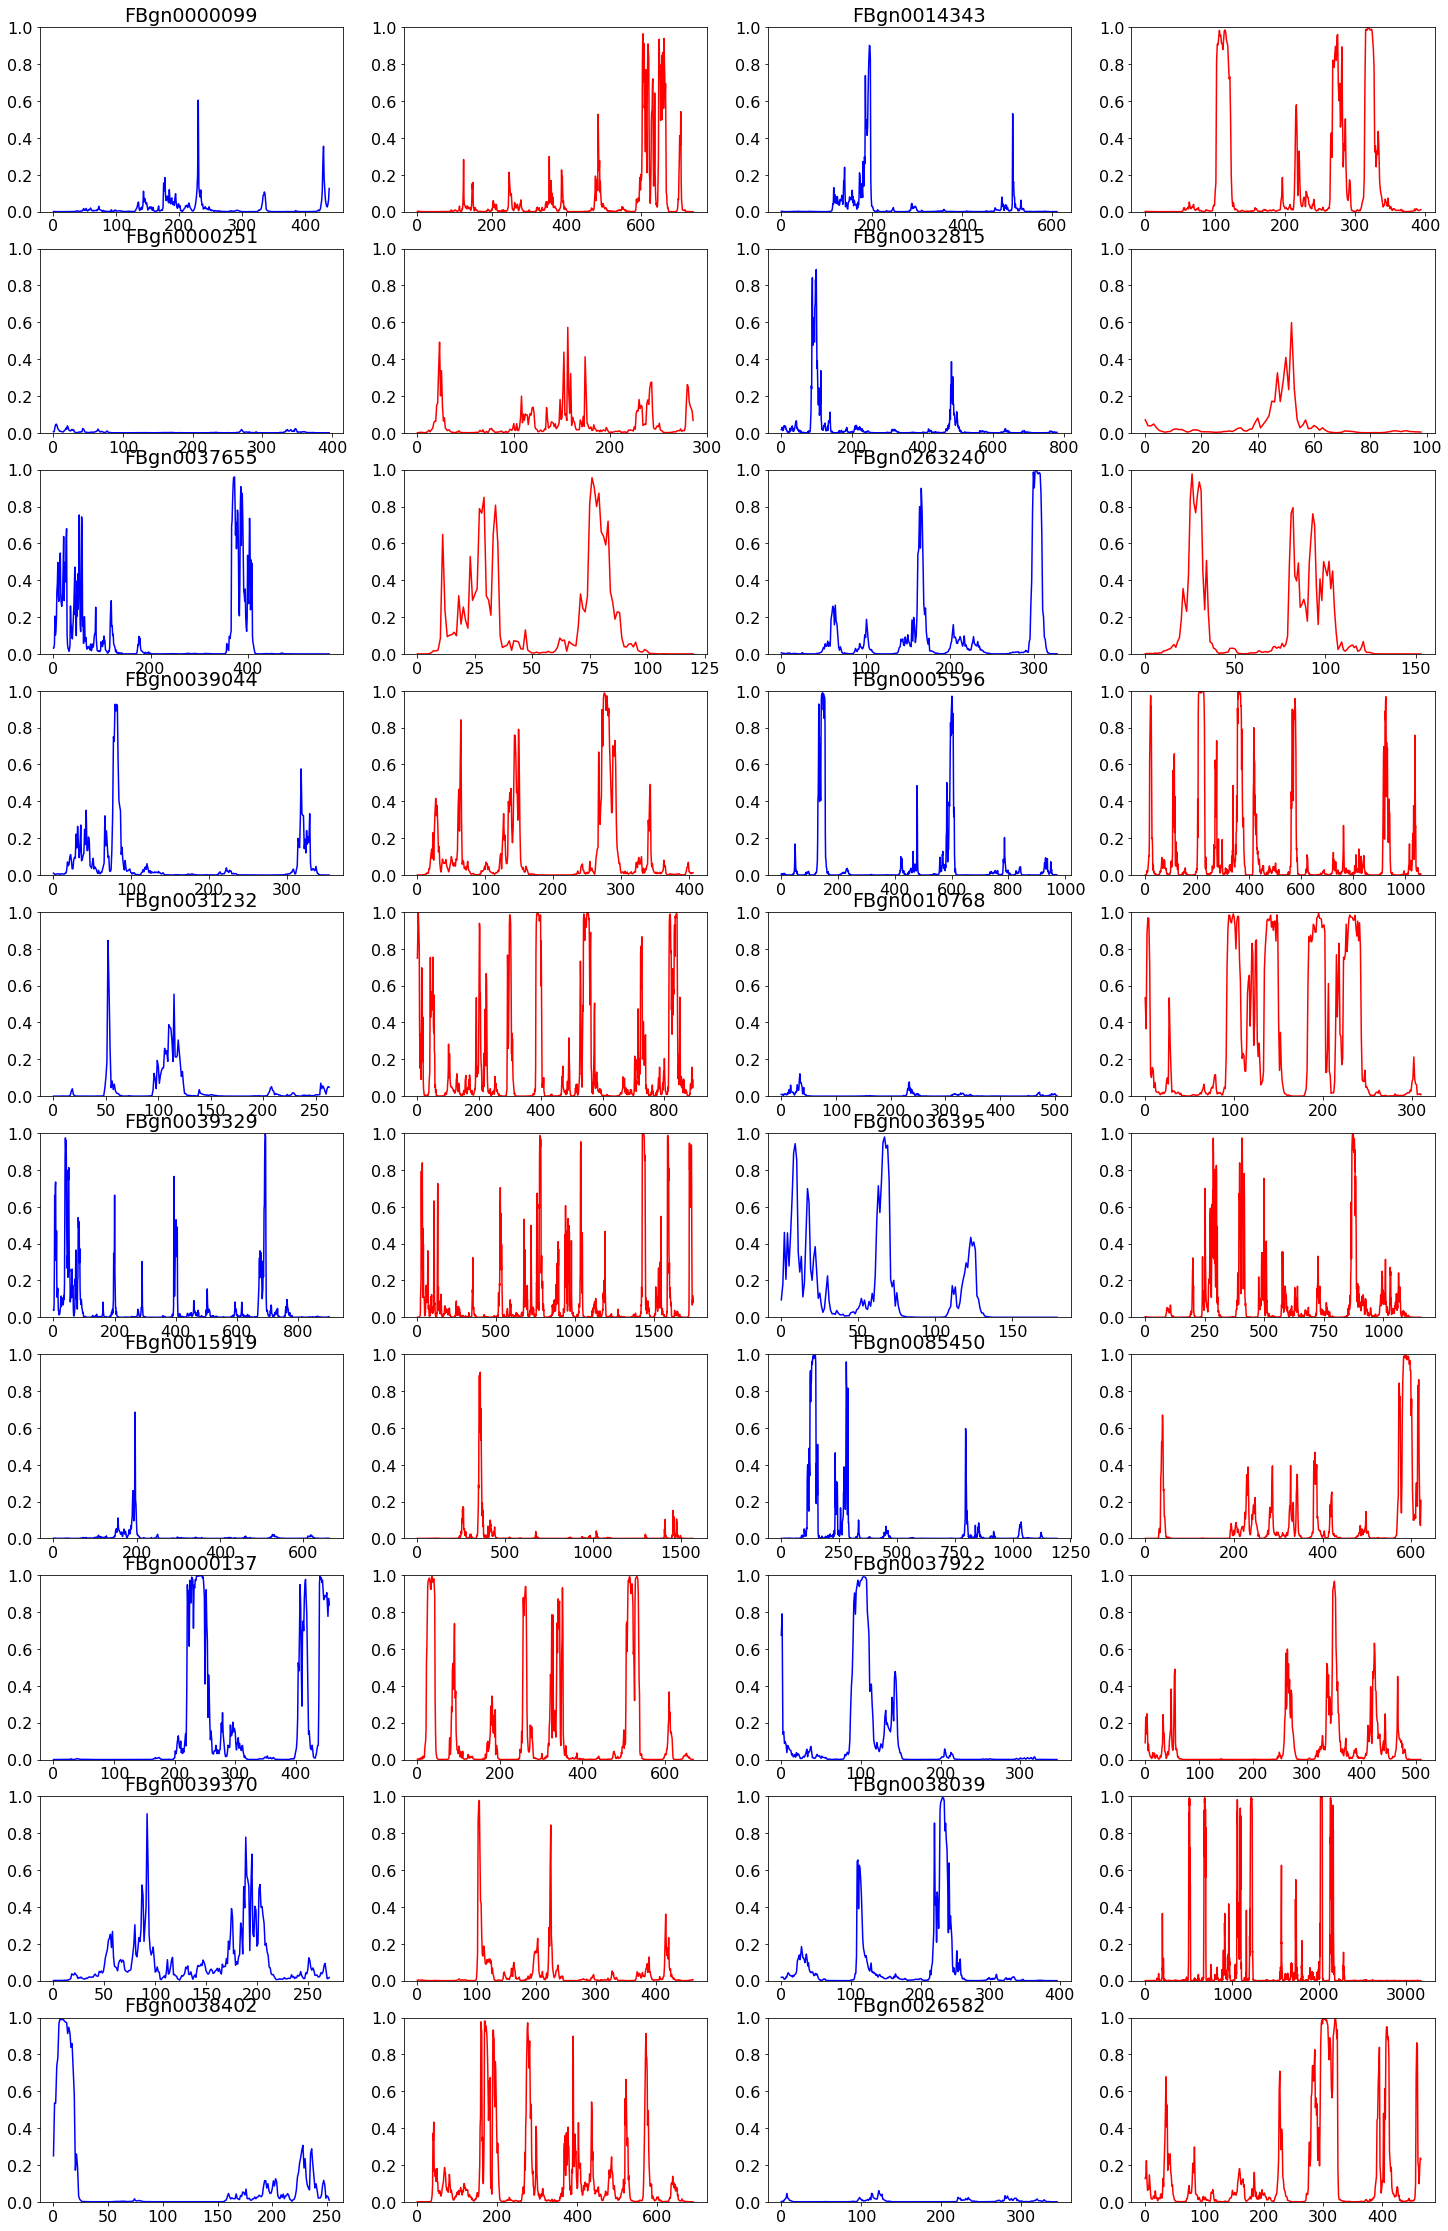

In [76]:
a = np.random.permutation(len(TFs))
b = np.random.permutation(len(Cofs))

f,ax = plt.subplots(10,4, figsize=(25,40))
n=0
for i,j in zip(a[:20], b[:20]):
    ax2, ax1 = n%4, n//4 
    ax[ax1][ax2].set_title(TFs[i])
    ax[ax1][ax2].plot(stampfel[TFs[i]], c='b')
    ax[ax1][ax2].set_ylim(0,1)
    n+=1
    ax2, ax1 = n%4, n//4
    ax[ax1][ax2].plot(stampfel[Cofs[j]], c='r')
    ax[ax1][ax2].set_ylim(0,1)
    n+=1

In [164]:
### Enrichment in these proteins compared to the fly proteome

In [39]:
Dir = 'review/enrichment_fly/'
f_adpreds = {}

with open(Dir + 'fly.adpred.results.uniprot','r') as f:
    while True:
        try:
            name, adpred = next(f).strip(), next(f).strip()
            
            # in case the header did not contain adpred results and the adpred line
            # is the next header
            if adpred == '': continue
            while adpred[0]==">":
                name = adpred
                adpred = next(f).strip()
                
                if len(adpred) == 0:
                    adpred = [">"]
            
            name = re.search("\|.*\|",name)
            if name == None: 
                continue
            name = name.group().replace("|",'')
            adpred = adpred.split(',')
            
            #assert name not in h_adpreds, "ups... {} repeatedd".format(name)
            
            f_adpreds[name] = np.array(adpred).astype(float)
        except StopIteration:
            break
            
        
        
        
        
with open(Dir + 'all','r') as f:
    f_proteome = {i.strip() for i in f}

#with open(Dir + 'tfs','r') as f:
#    f_TFs = {i.strip() for i in f}
 
f_TFs = set(stampfel.keys())

fly2uniprot = {}
with open(Dir + 'all_dict.tsv','r') as f:
    while True:
        try:
            line=next(f).strip().split('\t')
            fly2uniprot[line[0]] = line[1]
            
        except StopIteration:
            break

In [40]:
def find_AD_positions_considering_structure(uniprot_id, threshold=1):
    r=[]
    
    long = 0
    #for n,i in enumerate(proteome[guessKey[locus]]):  
    for n,i in enumerate(np.convolve( f_adpreds[uniprot_id], np.ones(12)/12, "same")):
        try:
            if i<0.8:
                if long>=threshold: #5:
                    r.append(n) #-long//2)
                    long = 0
                else:
                    continue

            else:
                long+=1
                #try:  # if n is larger than structures or doesn't exists...
                #    if h_structures[uniprot_id][n]==0:
                #        long+=1
                #except Exception:
                #     long+=1
                

        except Exception as e:
            print(str(e))
    return r 

In [42]:
from scipy.stats import hypergeom
def enrichment(M,n,N, x):
    '''
        Calculates the enrichment of genes in a Pugh group
        
        M = total number of proteins (population size)
        n = group with score>cutoff longer than 5 residues (# of successes in population) 
        N = total of group taken into account (e.g. tf_full) (sample size)
        x = number of successes (withTAD) in that group (drawn successes)
    '''
    if N==0: N=N+0.5
    enriched = (x/N)/(n/M)
    p_val = hypergeom.sf(x-1, M, n, N)
    
    return enriched, p_val
    


with open(Dir + 'filtered_flybase.ids','r') as f:
    Filter = [fly2uniprot[i.strip()] for i in f if i.strip() in fly2uniprot.keys()]

Filtered = [k for k in fly2uniprot.values() if k not in Filter]

TFs = {fly2uniprot[i] for i in f_TFs if i in fly2uniprot}.intersection(set(f_adpreds.keys()))
Proteome = {fly2uniprot[i] for i in f_proteome if i in fly2uniprot}.intersection(set(f_adpreds.keys()))

             
thresholds = [10,20,30,40,50,60] #np.arange(70) #[5,10,20,30,40,50]
TOTALs = {i:0 for i in thresholds}
TF = {i:0 for i in thresholds}
enrich, pval = [],[]
for threshold in thresholds:
    for k in Proteome:
        is_ad = len(find_AD_positions_considering_structure(k, threshold)) > 0
        
        TOTALs[threshold] += is_ad
        if k in TFs:
            TF[threshold] += is_ad

    ep = enrichment(len(Proteome), #len(f_adpreds), 
                    TOTALs[threshold],
                    len(TFs),
                    TF[threshold]
                   )
    enrich.append(ep[0])
    pval.append(ep[1])

In [43]:
fly_enrichments = []
for i in thresholds:
    fly_enrichments.append(
        enrichment(
        len(Proteome), #(len(f_adpreds),
        TOTALs[i],
        len(TFs),
        TF[i]
    ))
    #print(TOTALs[i]/len(f_adpreds), TF[i]/len(TFs))

[Text(0,0,'0'),
 Text(0,0,'5'),
 Text(0,0,'10'),
 Text(0,0,'20'),
 Text(0,0,'30'),
 Text(0,0,'40'),
 Text(0,0,'50')]

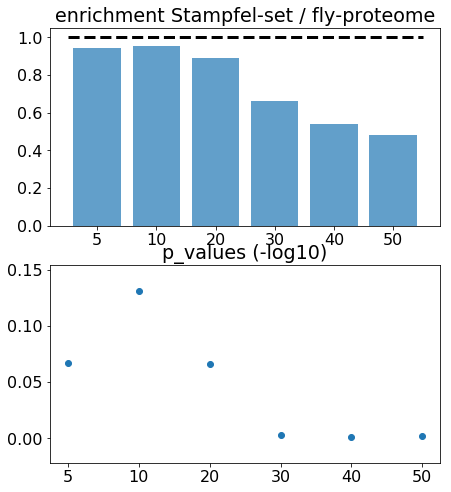

In [44]:
matplotlib.rcParams.update({'font.size': 16})
f,(ax1,ax2) = plt.subplots(2,1, figsize=(7,8))
ax1.bar(np.arange(len(thresholds)), np.array(fly_enrichments)[:,0], alpha=0.7)
ax1.set_xticklabels([0,5,10,20,30,40,50])
ax1.plot([-0.5,len(thresholds)-0.5], [1,1], ls='--', lw=3, c='k')

ax2.scatter(np.arange(len(thresholds)), -np.log10(np.array(fly_enrichments)[:,1]))
#ax2.set_yscale('log')

ax1.set_title('enrichment Stampfel-set / fly-proteome')
ax2.set_title('p_values (-log10)')
ax2.set_xticklabels([0,5,10,20,30,40,50])

ValueError: zero-size array to reduction operation minimum which has no identity

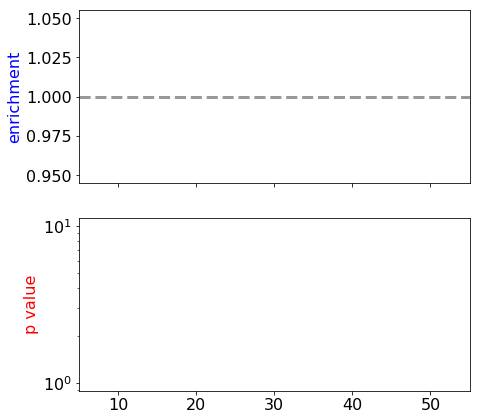

In [45]:
enrich2 = np.convolve(enrich, np.ones(4)/4, 'same')
pval2 = np.convolve(pval, np.ones(4)/4,'same')

    
ys = [np.mean(enrich2[i:i+10]) for i in np.arange(5, len(enrich2)-10, 10)]
ys2 = [np.mean(pval2[i:i+10]) for i in np.arange(5, len(pval2)-10, 10)]

####################
# plot enrichments #
####################

f,(ax1,ax2) = plt.subplots(2, sharex=True, figsize=(7,7))
ax1.bar(np.arange(len(ys)), ys, alpha=0.4, color='b')
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(np.arange(10,70,10))
ax2.scatter(np.arange(len(ys2)), ys2, alpha=0.4, color='r', s=100, marker='s')
ax1.set_ylabel('enrichment', color='b', fontsize=16)
ax1.plot(np.arange(6)-0.5, [1]*6, ls='--', alpha=0.4, color='k', lw=3)
ax2.plot(np.arange(len(ys2)), ys2, alpha=0.4, color='r')
ax2.set_ylabel('p value', color='r', fontsize=16)
ax2.set_yscale('log')
ax1.set_xlim(-0.5,4.5)

#print(ax2.get_ylim())
ax2.set_ylim((np.min(ys2)/3,1)[::-1])
matplotlib.rcParams.update({'font.size': 20})
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
matplotlib.rcParams.update({'font.size': 16})

In [46]:
ys2

[]

### Enrichments in TFs or Cofs

In [55]:
#f_adpreds
#TFs
#Proteome

uni_stampfel = {fly2uniprot[i] for i in stampfel.keys() if i in fly2uniprot}
uni_stampfel_tfs = {fly2uniprot[i] for i in stampfel.keys() if i in fly2uniprot and stampfel_type[i]=='TF'}
uni_stampfel_cof = {fly2uniprot[i] for i in stampfel.keys() if i in fly2uniprot and stampfel_type[i]!='TF'}

chosen_group =  uni_stampfel_cof

thresholds = [5,10,20,30,40,50]
TOTALs = {i:0 for i in thresholds}
TF = {i:0 for i in thresholds}
             
for threshold in thresholds:
    for k in Proteome:
        is_ad = len(find_AD_positions_considering_structure(k, threshold)) > 0
             
        TOTALs[threshold] += is_ad
        if k in chosen_group:
            TF[threshold] += is_ad

fly_enrichments = []
for i in thresholds:
    fly_enrichments.append(
        enrichment(
            len(Proteome), #len(f_adpreds),
            TOTALs[i],
            len(chosen_group),
            TF[i]
    ))

[Text(0,0,'0'),
 Text(0,0,'5'),
 Text(0,0,'10'),
 Text(0,0,'20'),
 Text(0,0,'30'),
 Text(0,0,'40'),
 Text(0,0,'50')]

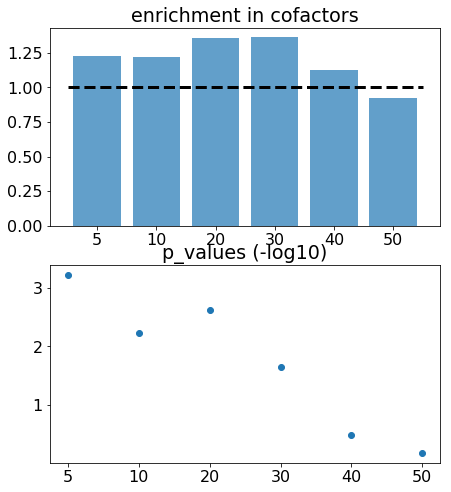

In [56]:
f,(ax1,ax2) = plt.subplots(2,1, figsize=(7,8))
ax1.bar(np.arange(len(thresholds)), np.array(fly_enrichments)[:,0], alpha=0.7)
ax1.set_xticklabels([0,5,10,20,30,40,50])
ax1.plot([-0.5,len(thresholds)-0.5], [1,1], ls='--', lw=3, c='k')

ax2.scatter(np.arange(len(thresholds)), -np.log10(np.array(fly_enrichments)[:,1]))
#ax2.set_yscale('log')

ax1.set_title('enrichment in cofactors')
ax2.set_title('p_values (-log10)')
ax2.set_xticklabels([0,5,10,20,30,40,50])

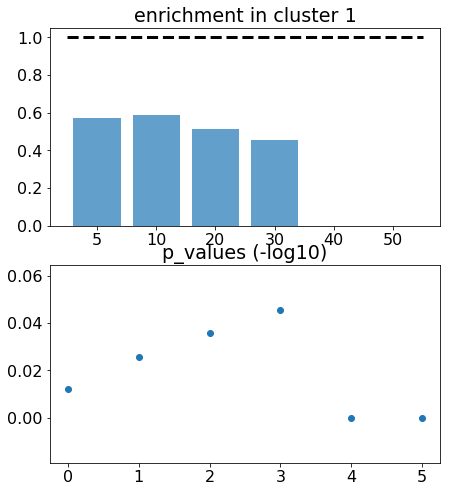

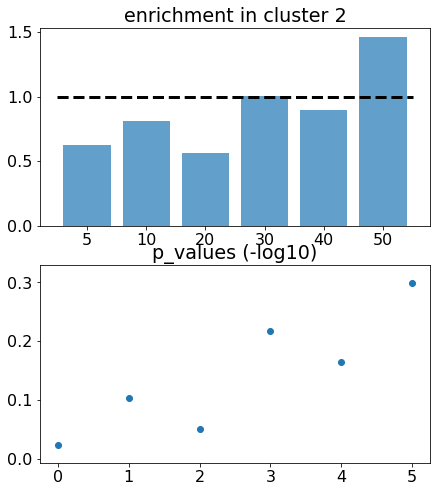

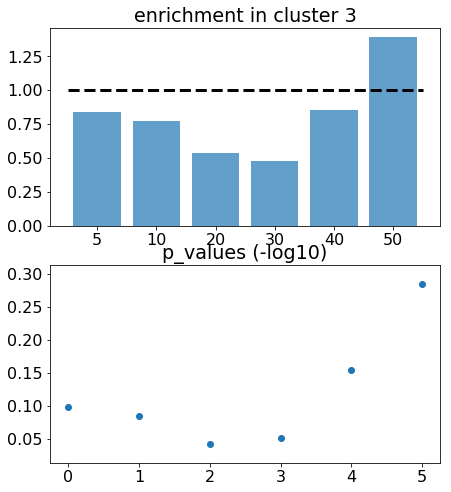

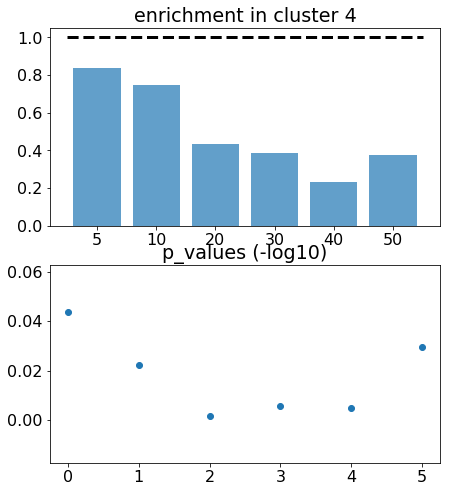

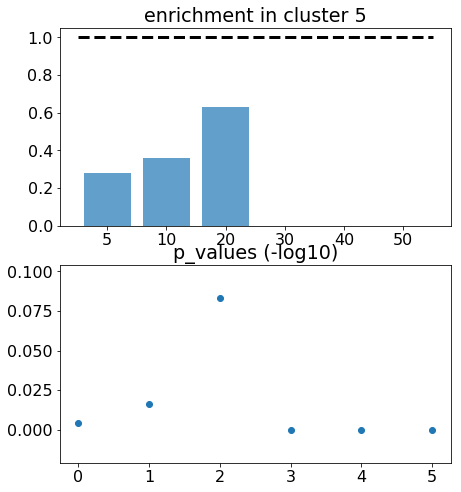

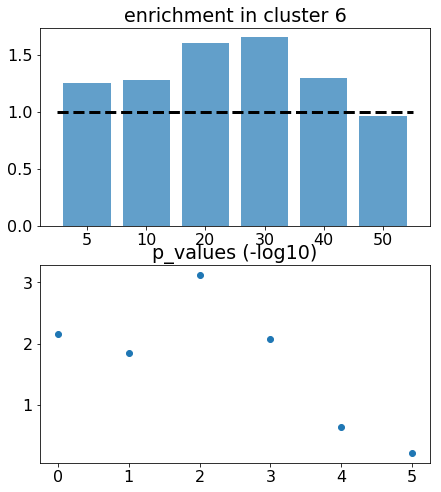

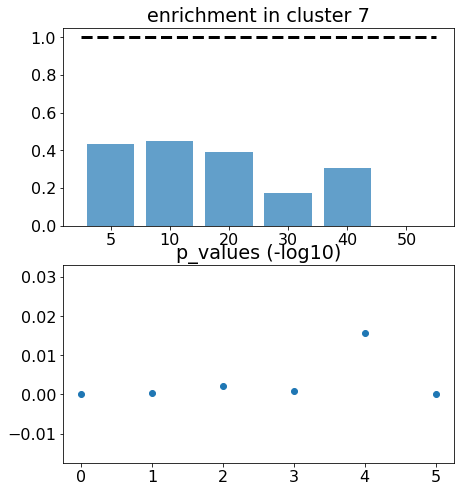

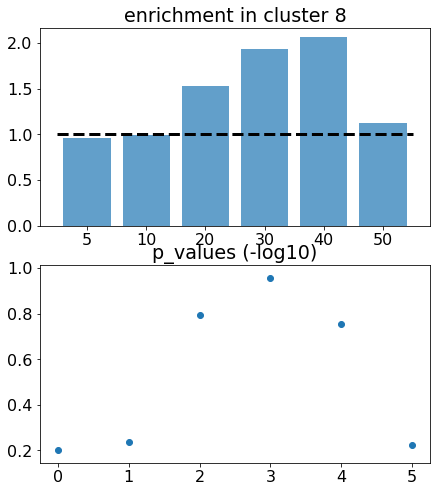

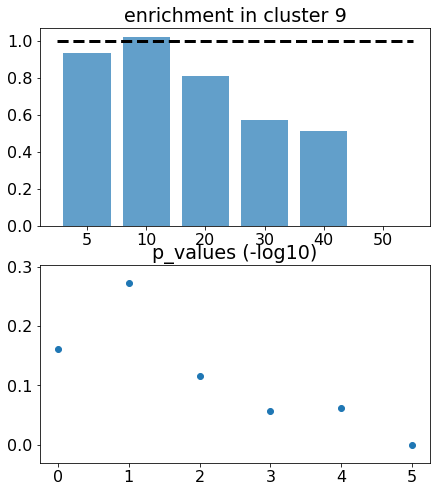

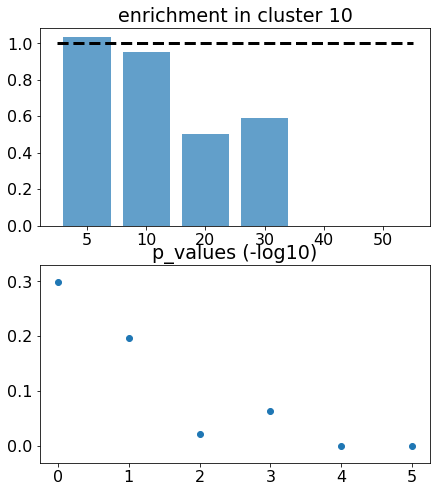

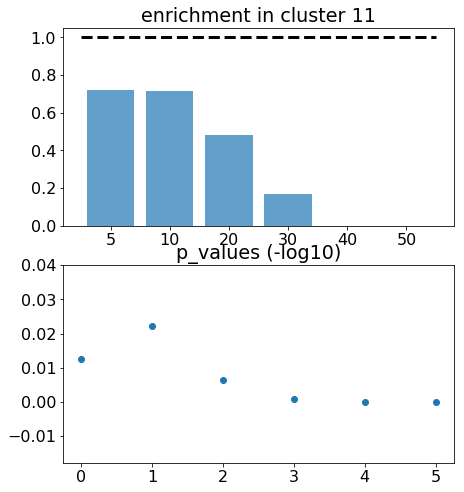

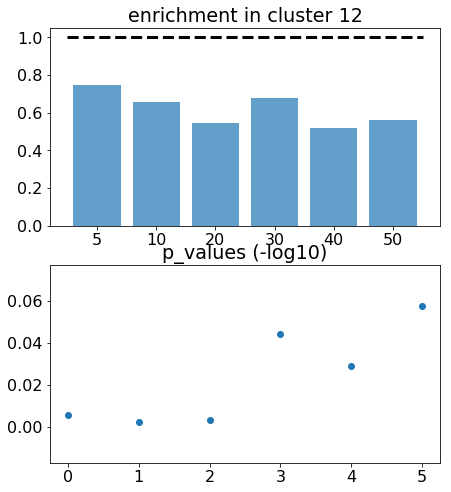

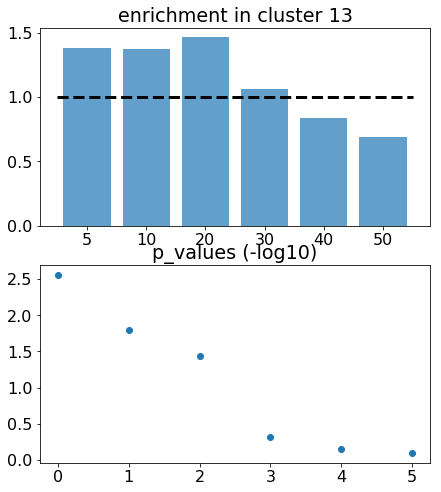

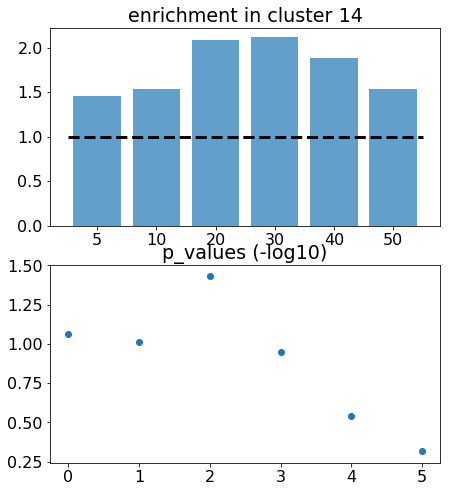

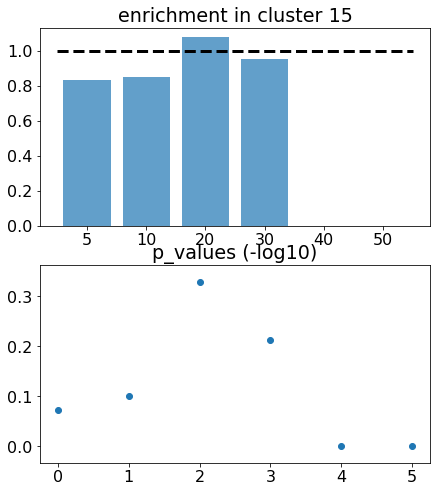

In [57]:
#f_adpreds
#TFs
#Proteome

johannes_heatmap = np.zeros(shape=(16,2))

for clust in range(1,16):
    
    uni_stampfel = {fly2uniprot[i] for i in stampfel.keys() if i in fly2uniprot and stampfel_cluster[i]==str(clust)}
    #uni_stampfel_tfs = {fly2uniprot[i] for i in stampfel.keys() if i in fly2uniprot and i in stampfel_type and stampfel_type[i]=='TF'}
    #uni_stampfel_cof = {fly2uniprot[i] for i in stampfel.keys() if i in fly2uniprot and i in stampfel_type and stampfel_type[i]!='TF'}


    thresholds = [5,10,20,30,40,50]
    TOTALs = {i:0 for i in thresholds}
    TF = {i:0 for i in thresholds}

    for threshold in thresholds:
        for k in Proteome:
            is_ad = len(find_AD_positions_considering_structure(k, threshold)) > 0

            TOTALs[threshold] += is_ad
            if k in uni_stampfel:
                TF[threshold] += is_ad

    fly_enrichments = []
    for i in thresholds:
        fly_enrichments.append(
            enrichment(
                len(Proteome), #len(f_adpreds),
                TOTALs[i],
                len(uni_stampfel),
                TF[i]
        ))

    johannes_heatmap[clust] = fly_enrichments[2]

    f,(ax1,ax2) = plt.subplots(2,1, figsize=(7,8))
    ax1.bar(np.arange(len(thresholds)), np.array(fly_enrichments)[:,0], alpha=0.7)
    ax1.set_xticklabels([0,5,10,20,30,40,50])
    ax1.plot([-0.5,len(thresholds)-0.5], [1,1], ls='--', lw=3, c='k')

    ax2.scatter(np.arange(len(thresholds)), -np.log10(np.array(fly_enrichments)[:,1]))
    #ax2.set_yscale('log')

    ax1.set_title('enrichment in cluster {}'.format(clust))
    ax2.set_title('p_values (-log10)')

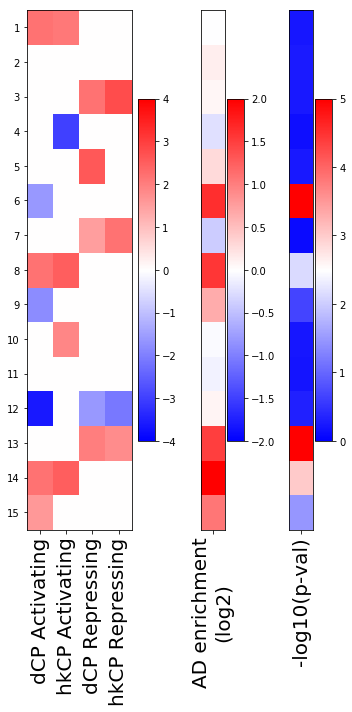

In [237]:
stampfel_2d = pd.read_csv('./review/41586_2015_BFnature15545_MOESM10_ESM.csv', index_col=0).iloc[:4,:-1].fillna(0).T

norm=plt.Normalize(-4,4)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","white","red"])

f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(5,10), gridspec_kw={'width_ratios': [3, 1, 1]}) #, sharey=True)

im = ax1.pcolor(stampfel_2d[::-1], cmap=cmap, norm=norm) #vmin=-4, vmax=4)
ax1.set_xticks(np.arange(4)+0.5)
ax1.set_xticklabels(stampfel_2d.columns, rotation=90, fontsize=20);
ax1.set_yticks(np.arange(15)+0.5);
ax1.set_yticklabels(np.arange(15,0,-1));

plt.colorbar(im, ax=ax1, fraction=0.4/3, pad=0.05)


norm=plt.Normalize(-2,2)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","white","red"])

im = ax2.pcolor(np.log2(johannes_heatmap[1:,0]).reshape(-1,1)[::-1], cmap=cmap, norm=norm)
ax2.set_yticks([]) 
#ax2.set_yticks(np.arange(15)+0.5);
#ax2.set_yticklabels(np.arange(15,0,-1));
ax2.set_xticks([0.5])
ax2.set_xticklabels(['AD enrichment\n(log2)'], rotation=90, fontsize=20)

plt.colorbar(im, ax=ax2, fraction=0.4, pad=0.05)


norm=plt.Normalize(0,5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","white","red"])

im = ax3.pcolor(-np.log10(johannes_heatmap[1:,1]).reshape(-1,1)[::-1], cmap=cmap, norm=norm)
ax3.set_yticks([]) 
#ax3.set_yticks(np.arange(15)+0.5);
#ax3.set_yticklabels(np.arange(15,0,-1));
ax3.set_xticks([0.5])
ax3.set_xticklabels(['-log10(p-val)'], rotation=90, fontsize=20)


plt.colorbar(im, ax=ax3, fraction=0.4, pad=0.05)



plt.tight_layout()

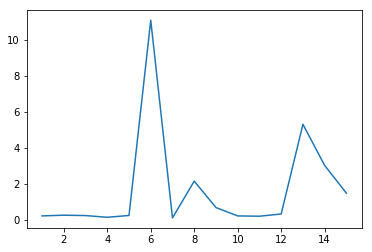

In [194]:
plt.plot(-np.log10(johannes_heatmap[:,1]))
#plt.plot(johannes_heatmap[:,1])